# Phase 3: Fee Prediction Model (New Dataset - November 2025)

## Overview
This notebook implements the second stage of the two-stage estimation approach for Bitcoin transaction fee prediction using the **new 15M transaction dataset** from November 2025.

**Data Source**: `11-24-2025-15m-data-lake.db` - SQLite database with ~15 million mempool transactions

**Pipeline:**
- **Input**: SQLite database with transaction data
- **Output**: Fee predictions and model diagnostics

**Equation 4 Structure:**
```
fee_it = α₁ + α₂·ρ̂_t + α₃·riemann_sum + α₄·V_it + α₅·Weight_it + 
         α₆·FromExchange + α₇·ToExchange + α₈·Blockspace_t + 
         α₉·NFT_it + wallet_dummies + ε_it
```

**Research Questions:**
1. How well does the structural model (Equation 4) predict Bitcoin fees with the new data?
2. What are the key drivers of transaction fees?
3. How do different transaction types affect fees?
4. How does performance compare to the previous dataset?


---
## Section 1: Setup & Data Loading


### 1.1 Import Libraries


In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully
Pandas version: 2.3.3
NumPy version: 2.3.5


### 1.2 Load Data from SQLite Database

The new dataset contains ~15 million transactions. We'll sample a subset for analysis.


In [2]:
# Database path
db_path = os.path.expanduser('/home/armin/datalake/data-samples/11-24-2025-15m-data-lake.db')

# Connect to database
conn = sqlite3.connect(db_path)

# Check total rows
total_count = pd.read_sql_query("SELECT COUNT(*) as count FROM mempool_transactions", conn)['count'].iloc[0]
print(f"Total transactions in database: {total_count:,}")

# Get schema info
print("\nTable Schema:")
schema = pd.read_sql_query("PRAGMA table_info(mempool_transactions)", conn)
print(schema[['name', 'type']])


Total transactions in database: 14,984,540

Table Schema:
                   name      type
0                    id   INTEGER
1                 tx_id      TEXT
2           inputs_hash      TEXT
3            child_txid      TEXT
4               tx_data      TEXT
5        output_amounts      TEXT
6        output_weights      TEXT
7       conf_block_hash      TEXT
8              found_at  DATETIME
9              mined_at  DATETIME
10            pruned_at  DATETIME
11        rbf_fee_total   INTEGER
12   min_respend_blocks   INTEGER
13         absolute_fee   INTEGER
14             fee_rate      REAL
15              version   INTEGER
16      seen_in_mempool   INTEGER
17             waittime   INTEGER
18               weight   INTEGER
19                 size   INTEGER
20  total_output_amount   INTEGER
21         mempool_size   INTEGER
22     mempool_tx_count   INTEGER


In [3]:
# Sample data - get transactions from random blocks to maintain block structure
# First, get unique blocks using conf_block_hash (the actual block identifier)
print("Getting unique blocks...")

blocks_query = """
SELECT DISTINCT conf_block_hash 
FROM mempool_transactions 
WHERE conf_block_hash IS NOT NULL
ORDER BY RANDOM()
LIMIT 2000
"""
sampled_blocks = pd.read_sql_query(blocks_query, conn)['conf_block_hash'].tolist()
print(f"Sampled {len(sampled_blocks)} unique blocks")

# Create a placeholder string for SQL IN clause
placeholders = ','.join(['?' for _ in sampled_blocks])

# Load all transactions from sampled blocks
query = f"""
SELECT 
    tx_id,
    tx_data,
    child_txid,
    conf_block_hash,
    found_at,
    mined_at,
    rbf_fee_total,
    min_respend_blocks,
    absolute_fee,
    fee_rate,
    version,
    seen_in_mempool,
    waittime,
    weight,
    size,
    total_output_amount,
    mempool_size,
    mempool_tx_count,
    output_weights
FROM mempool_transactions 
WHERE conf_block_hash IN ({placeholders})
"""

print("Loading transactions from sampled blocks...")
df = pd.read_sql_query(query, conn, params=sampled_blocks)

conn.close()

print(f"\nLoaded {len(df):,} transactions from {len(sampled_blocks):,} blocks")
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")


Getting unique blocks...
Sampled 2000 unique blocks
Loading transactions from sampled blocks...

Loaded 5,011,261 transactions from 2,000 blocks
Dataset shape: (5011261, 19)

Columns: ['tx_id', 'tx_data', 'child_txid', 'conf_block_hash', 'found_at', 'mined_at', 'rbf_fee_total', 'min_respend_blocks', 'absolute_fee', 'fee_rate', 'version', 'seen_in_mempool', 'waittime', 'weight', 'size', 'total_output_amount', 'mempool_size', 'mempool_tx_count', 'output_weights']


### 1.3 Data Quality Checks


In [4]:
# Check for missing values
missing_summary = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percent': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Count', ascending=False)

print("Missing Values Summary:")
print(missing_summary[missing_summary['Missing_Count'] > 0])

if missing_summary['Missing_Count'].sum() == 0:
    print("\n✓ No missing values found")
    
# Check transactions per block (using conf_block_hash as the true block identifier)
print("\nTransactions per block (grouped by conf_block_hash):")
txs_per_block = df.groupby('conf_block_hash').size()
print(txs_per_block.describe())
print(f"\nBlocks with <1000 txs: {(txs_per_block < 1000).sum()}")
print(f"Blocks with 1000-2000 txs: {((txs_per_block >= 1000) & (txs_per_block < 2000)).sum()}")
print(f"Blocks with 2000-4000 txs: {((txs_per_block >= 2000) & (txs_per_block < 4000)).sum()}")
print(f"Blocks with 4000-6000 txs: {((txs_per_block >= 4000) & (txs_per_block < 6000)).sum()}")
print(f"Blocks with 6000+ txs: {(txs_per_block >= 6000).sum()}")

# Check block weight coverage
block_weights = df.groupby('conf_block_hash')['weight'].sum()
print(f"\nBlock weight statistics:")
print(block_weights.describe())
print(f"\nAvg block fullness: {block_weights.mean() / 4_000_000 * 100:.1f}% of max block weight")


Missing Values Summary:
                  Missing_Count  Missing_Percent
rbf_fee_total           4970599          99.1900
child_txid              3653934          72.9100
mempool_tx_count           3236           0.0600
mempool_size               3236           0.0600

Transactions per block (grouped by conf_block_hash):
count   2000.0000
mean    2505.6305
std     1284.8446
min        4.0000
25%     1439.7500
50%     2673.0000
75%     3496.0000
max     7057.0000
dtype: float64

Blocks with <1000 txs: 329
Blocks with 1000-2000 txs: 358
Blocks with 2000-4000 txs: 1087
Blocks with 4000-6000 txs: 222
Blocks with 6000+ txs: 4

Block weight statistics:
count      2000.0000
mean    2378877.6120
std     1031927.0145
min        1984.0000
25%     1615394.0000
50%     2909748.0000
75%     3157449.0000
max     3980256.0000
Name: weight, dtype: float64

Avg block fullness: 59.5% of max block weight


### 1.4 Initial Data Cleaning & Feature Engineering


In [ ]:
# Convert datetime columns
df['found_at'] = pd.to_datetime(df['found_at'])
df['mined_at'] = pd.to_datetime(df['mined_at'])

# Create numeric timestamp for comparisons
df['found_at_ts'] = df['found_at'].astype('int64') // 10**9

# Create epoch identifier (30-minute windows)
df['epoch'] = df['found_at'].dt.floor('30min')

# Remove outliers (extreme fees that might be errors)
# Keep fees within 99.9th percentile
fee_threshold = df['fee_rate'].quantile(0.999)
df_clean = df[df['fee_rate'] <= fee_threshold].copy()

# =============================================================================
# Create BASIC derived features (from raw data only)
# Phase 2 computed features (rho_t, W_hat, time_cost_quantile, F_tq) 
# will be loaded in the next cell
# =============================================================================

# 1. has_child: whether transaction has a child (CPFP indicator)
df_clean['has_child'] = df_clean['child_txid'].notna().astype(int)

# 2. is_cpfp: zero-block respends (CPFP via immediate spend)
df_clean['is_cpfp'] = (df_clean['min_respend_blocks'] == 0).astype(int)

# 3. rbf_flag: whether transaction uses RBF (based on rbf_fee_total)
df_clean['rbf_flag'] = (df_clean['rbf_fee_total'].notna() & (df_clean['rbf_fee_total'] > 0)).astype(int)

# 4. V_it: Transaction value (total output amount in satoshis)
# This is α₄·V_it from Equation 4 - represents the value being transacted
df_clean['V_it'] = df_clean['total_output_amount']

print(f"Removed {len(df) - len(df_clean):,} rows ({(len(df) - len(df_clean))/len(df)*100:.2f}%)")
print(f"Clean dataset: {len(df_clean):,} transactions")

print(f"\nBasic features created:")
print(f"  has_child distribution:\n{df_clean['has_child'].value_counts()}")
print(f"\n  is_cpfp distribution:\n{df_clean['is_cpfp'].value_counts()}")
print(f"\n  rbf_flag distribution:\n{df_clean['rbf_flag'].value_counts()}")
print(f"\n  V_it (transaction value) - Mean: {df_clean['V_it'].mean():,.0f} sats")

print(f"\n⏳ Phase 2 computed features (rho_t, W_hat, time_cost_quantile, F_tq)")
print(f"   will be loaded in the next cell...")


Removed 4,083 rows (0.08%)
Clean dataset: 5,007,178 transactions

Basic features created:
  has_child distribution:
has_child
0    3649977
1    1357201
Name: count, dtype: int64

  rbf_flag distribution:
rbf_flag
0    4966553
1      40625
Name: count, dtype: int64

  V_it (transaction value) - Mean: 172,285,357 sats

⏳ Phase 2 computed features (rho_t, W_hat, time_cost_quantile, F_tq)
   will be loaded in the next cell...


### 1.5 Load Phase 2 Derived Features (from simple-correlation.ipynb)

Load pre-computed features from Phase 2 analysis:
- **W_hat**: Predicted wait time from the wait time model
- **rho_t**: Time-weighted mempool congestion per epoch  
- **time_cost**: User impatience proxy (1 / min_respend_blocks)
- **time_cost_quantile**: Quantile bins (1-10) of time_cost per epoch
- **F_tq**: Upper-tail probability distribution


In [6]:
# Load Phase 2 derived features
phase2_path = '/home/kristian/notebooks/phase2_derived_features.pkl'

# =============================================================================
# CONFIGURATION
# =============================================================================
# Set to True to filter dataset to only transactions with Phase 2 data
# This ensures all computed features are from Phase 2 (better for modeling)
FILTER_TO_PHASE2_DATA = True

print("="*70)
print("LOADING PHASE 2 COMPUTED FEATURES")
print("="*70)
print(f"\n  Configuration: FILTER_TO_PHASE2_DATA = {FILTER_TO_PHASE2_DATA}")

phase2_loaded = False
original_size = len(df_clean)

try:
    phase2_df = pd.read_pickle(phase2_path)
    print(f"\n✓ Loaded Phase 2 features from: {phase2_path}")
    print(f"  Phase 2 rows: {len(phase2_df):,}")
    print(f"  Columns: {list(phase2_df.columns)}")
    
    # Show Phase 2 feature statistics
    print(f"\n  Phase 2 Feature Statistics:")
    for col in phase2_df.columns:
        if col != 'tx_id':
            non_null = phase2_df[col].notna().sum()
            print(f"    {col:20s}: {non_null:>10,} non-null ({non_null/len(phase2_df)*100:5.1f}%)")
    
    # Merge Phase 2 features with current dataset
    print(f"\n  Merging with current dataset...")
    print(f"  Current df_clean size: {len(df_clean):,}")
    
    # Check for tx_id overlap
    overlap_mask = df_clean['tx_id'].isin(phase2_df['tx_id'])
    overlap = overlap_mask.sum()
    print(f"  Transactions with Phase 2 data: {overlap:,} ({overlap/len(df_clean)*100:.1f}%)")
    
    if overlap > 0:
        if FILTER_TO_PHASE2_DATA:
            # =============================================================
            # FILTER: Keep only transactions that have Phase 2 data
            # This ensures all computed features are from Phase 2
            # =============================================================
            print(f"\n  🔍 Filtering to Phase 2 transactions only...")
            df_clean = df_clean[overlap_mask].copy()
            print(f"  Filtered from {original_size:,} → {len(df_clean):,} transactions")
            
            # Now do an INNER merge (all rows will have Phase 2 data)
            df_merged = df_clean.merge(
                phase2_df,
                on='tx_id',
                how='inner',
                suffixes=('', '_phase2')
            )
        else:
            # LEFT merge - keep all transactions, fill missing with fallbacks
            df_merged = df_clean.merge(
                phase2_df,
                on='tx_id',
                how='left',
                suffixes=('', '_phase2')
            )
        
        # Handle merged columns - prefer Phase 2 values
        for col in ['W_hat', 'rho_t', 'time_cost_quantile']:
            phase2_col = f'{col}_phase2'
            if phase2_col in df_merged.columns:
                if col in df_merged.columns:
                    df_merged[col] = df_merged[phase2_col].fillna(df_merged[col])
                else:
                    df_merged[col] = df_merged[phase2_col]
                df_merged = df_merged.drop(columns=[phase2_col])
                print(f"  ✓ Loaded {col} from Phase 2")
        
        # Handle epoch column
        if 'epoch_phase2' in df_merged.columns:
            df_merged = df_merged.drop(columns=['epoch_phase2'])
        
        # Check for new Phase 2 columns
        for col in ['time_cost', 'F_tq']:
            if col in df_merged.columns:
                print(f"  ✓ Loaded {col} from Phase 2")
        
        # Update df_clean with merged data
        df_clean = df_merged
        df = df_clean
        phase2_loaded = True
        
        print(f"\n  ✓ Merge complete!")
        print(f"  Final dataset size: {len(df_clean):,}")
        
        if FILTER_TO_PHASE2_DATA:
            print(f"  📊 Data reduction: {original_size:,} → {len(df_clean):,} ({len(df_clean)/original_size*100:.1f}%)")
    else:
        print(f"\n  ⚠ No overlapping transactions found!")
        
except FileNotFoundError:
    print(f"\n⚠ Phase 2 features file not found: {phase2_path}")
    print(f"  To generate this file, run simple-correlation.ipynb first.")
    
except Exception as e:
    print(f"\n❌ Error loading Phase 2 features: {e}")

# =============================================================================
# CREATE FALLBACK VALUES for missing Phase 2 features
# (Only needed if FILTER_TO_PHASE2_DATA=False or Phase 2 data unavailable)
# =============================================================================

print(f"\n" + "-"*70)
if phase2_loaded and FILTER_TO_PHASE2_DATA:
    print("VALIDATING PHASE 2 FEATURES (no fallbacks needed)")
else:
    print("CREATING FALLBACK VALUES FOR MISSING FEATURES")
print("-"*70)

# rho_t: mempool congestion
if 'rho_t' not in df_clean.columns or df_clean['rho_t'].isna().all():
    df_clean['rho_t'] = df_clean['mempool_size']
    print(f"  ⚠ rho_t: Using mempool_size as fallback proxy")
else:
    na_count = df_clean['rho_t'].isna().sum()
    if na_count > 0:
        df_clean['rho_t'] = df_clean['rho_t'].fillna(df_clean['mempool_size'])
        print(f"  ✓ rho_t: Filled {na_count:,} NaN values with mempool_size")
    else:
        print(f"  ✓ rho_t: 100% from Phase 2 ({df_clean['rho_t'].notna().sum():,} values)")

# W_hat: predicted wait time
if 'W_hat' not in df_clean.columns or df_clean['W_hat'].isna().all():
    df_clean['W_hat'] = df_clean['waittime']
    print(f"  ⚠ W_hat: Using actual waittime as fallback proxy")
else:
    na_count = df_clean['W_hat'].isna().sum()
    if na_count > 0:
        df_clean['W_hat'] = df_clean['W_hat'].fillna(df_clean['waittime'])
        print(f"  ✓ W_hat: Filled {na_count:,} NaN values with actual waittime")
    else:
        print(f"  ✓ W_hat: 100% from Phase 2 ({df_clean['W_hat'].notna().sum():,} values)")

# time_cost_quantile: user impatience bins
if 'time_cost_quantile' not in df_clean.columns or df_clean['time_cost_quantile'].isna().all():
    df_clean['time_cost_quantile'] = df_clean.groupby('epoch')['fee_rate'].transform(
        lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop') + 1
    )
    df_clean['time_cost_quantile'] = df_clean['time_cost_quantile'].fillna(5)
    print(f"  ⚠ time_cost_quantile: Using fee_rate quantiles as fallback proxy")
else:
    na_count = df_clean['time_cost_quantile'].isna().sum()
    if na_count > 0:
        fallback = df_clean.groupby('epoch')['fee_rate'].transform(
            lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop') + 1
        ).fillna(5)
        df_clean['time_cost_quantile'] = df_clean['time_cost_quantile'].fillna(fallback)
        print(f"  ✓ time_cost_quantile: Filled {na_count:,} NaN values with fee_rate quantiles")
    else:
        print(f"  ✓ time_cost_quantile: 100% from Phase 2 ({df_clean['time_cost_quantile'].notna().sum():,} values)")

# time_cost: user impatience metric (Phase 2 only - no fallback)
if 'time_cost' not in df_clean.columns:
    print(f"  ℹ time_cost: Not available (Phase 2 only feature)")
else:
    na_count = df_clean['time_cost'].isna().sum()
    if na_count > 0:
        print(f"  ⚠ time_cost: {na_count:,} NaN values (no fallback available)")
    else:
        print(f"  ✓ time_cost: 100% from Phase 2 ({df_clean['time_cost'].notna().sum():,} values)")

# F_tq: tail distribution (Phase 2 only - no fallback)
if 'F_tq' not in df_clean.columns:
    print(f"  ℹ F_tq: Not available (Phase 2 only feature)")
else:
    na_count = df_clean['F_tq'].isna().sum()
    if na_count > 0:
        print(f"  ⚠ F_tq: {na_count:,} NaN values (no fallback available)")
    else:
        print(f"  ✓ F_tq: 100% from Phase 2 ({df_clean['F_tq'].notna().sum():,} values)")

# Update df reference
df = df_clean

# =============================================================================
# SUMMARY
# =============================================================================
print(f"\n" + "="*70)
print("FEATURE SUMMARY")
print("="*70)

key_features = ['rho_t', 'W_hat', 'time_cost_quantile', 'time_cost', 'F_tq', 
                'has_child', 'rbf_flag', 'V_it']
print(f"\n{'Feature':<25} {'Non-Null':>12} {'Coverage':>10} {'Source':<15}")
print("-"*70)

for feat in key_features:
    if feat in df_clean.columns:
        non_null = df_clean[feat].notna().sum()
        coverage = non_null / len(df_clean) * 100
        if feat in ['has_child', 'rbf_flag', 'V_it']:
            source = "Raw data"
        elif phase2_loaded and FILTER_TO_PHASE2_DATA:
            source = "Phase 2 ✓"
        elif phase2_loaded:
            source = "Phase 2 + fallback"
        else:
            source = "Fallback"
        print(f"  {feat:<23} {non_null:>12,} {coverage:>9.1f}% {source:<15}")
    else:
        print(f"  {feat:<23} {'N/A':>12} {'N/A':>10} {'Not created':<15}")

print("="*70)

if phase2_loaded and FILTER_TO_PHASE2_DATA:
    print(f"\n✅ Dataset filtered to Phase 2 transactions only")
    print(f"   All computed features (rho_t, W_hat, time_cost_quantile, time_cost, F_tq)")
    print(f"   are from Phase 2 analysis - optimal for modeling!")
elif phase2_loaded:
    print(f"\n⚠️  Dataset includes transactions without Phase 2 data")
    print(f"   Some features may use fallback proxies")
    print(f"   Set FILTER_TO_PHASE2_DATA=True for better model quality")
else:
    print(f"\n⚠️  Phase 2 data not loaded - using fallback values")
    print(f"   Run simple-correlation.ipynb to generate Phase 2 features")


LOADING PHASE 2 COMPUTED FEATURES

  Configuration: FILTER_TO_PHASE2_DATA = True



✓ Loaded Phase 2 features from: /home/kristian/notebooks/phase2_derived_features.pkl
  Phase 2 rows: 14,984,540
  Columns: ['tx_id', 'W_hat', 'rho_t', 'time_cost', 'time_cost_quantile', 'F_tq', 'epoch']

  Phase 2 Feature Statistics:
    W_hat               : 14,980,403 non-null (100.0%)
    rho_t               : 14,980,403 non-null (100.0%)
    time_cost           : 14,984,540 non-null (100.0%)
    time_cost_quantile  : 14,984,540 non-null (100.0%)
    F_tq                : 14,984,540 non-null (100.0%)
    epoch               : 14,984,540 non-null (100.0%)

  Merging with current dataset...
  Current df_clean size: 5,007,178
  Transactions with Phase 2 data: 5,007,178 (100.0%)

  🔍 Filtering to Phase 2 transactions only...
  Filtered from 5,007,178 → 5,007,178 transactions
  ✓ Loaded time_cost from Phase 2
  ✓ Loaded F_tq from Phase 2

  ✓ Merge complete!
  Final dataset size: 5,007,178
  📊 Data reduction: 5,007,178 → 5,007,178 (100.0%)

----------------------------------------------

In [7]:
# Import exchange detection module
import sys
sys.path.insert(0, '/home/kristian/notebooks')

from exchange_addresses import (
    add_exchange_detection_to_dataframe,
    print_exchange_summary,
    EXCHANGE_ENTITIES
)

# Display exchange database summary
print_exchange_summary()

# Add exchange detection to cleaned dataframe
# This creates: from_exchange (α₆) and to_exchange (α₇) columns
print("Adding exchange detection variables...")

df_clean = add_exchange_detection_to_dataframe(
    df_clean, 
    tx_data_col='tx_data',
    use_proxy_for_inputs=False,  # Uses high-value/high-fee proxy for inputs
    show_progress=True
)

# Verify the new columns
print(f"\nNew features added:")
print(f"  - from_exchange (α₆): {df_clean['from_exchange'].sum():,} transactions ({df_clean['from_exchange'].mean()*100:.2f}%)")
print(f"  - to_exchange (α₇): {df_clean['to_exchange'].sum():,} transactions ({df_clean['to_exchange'].mean()*100:.2f}%)")

# Cross-tabulation
print(f"\nExchange flow analysis:")
exchange_crosstab = pd.crosstab(
    df_clean['from_exchange'], 
    df_clean['to_exchange'],
    rownames=['FromExchange'], 
    colnames=['ToExchange']
)
print(exchange_crosstab)

# -----------------------------------------------------------------------------
# These variables are now ready for use in Equation 4:
# fee_it = α₁ + α₂·ρ̂_t + α₃·riemann_sum + α₄·V_it + α₅·Weight_it + 
#          α₆·FromExchange + α₇·ToExchange + α₈·Blockspace_t + 
#          α₉·NFT_it + wallet_dummies + ε_it
# -----------------------------------------------------------------------------

EXCHANGE ADDRESS DATABASE SUMMARY

Known Exchange Addresses (curated): 66
Number of Exchanges with addresses: 32

Bithypha Entity Database:
  - Total Exchanges: 106
  - Total Clustered Addresses: 135,783,520
  - Total BTC Holdings: 1,311,048.04 BTC

------------------------------------------------------------
TOP 10 EXCHANGES BY ADDRESS COUNT:
------------------------------------------------------------
  Coinbase                    40,123,428 addresses
  Cash App                    15,874,756 addresses
  Binance                     12,517,124 addresses
  LocalBitcoins               10,254,735 addresses
  Coins.ph                     2,779,507 addresses
  Kraken                       2,717,354 addresses
  Xapo Bank                    2,184,554 addresses
  Bitso                        2,058,079 addresses
  HugosWay                     1,931,054 addresses
  KuCoin                       1,930,282 addresses

------------------------------------------------------------
TOP 10 EXCHANGES BY B

### 1.6 NFT/Inscription Detection & Output Weight Analysis

Detect NFT/inscriptions using individual output weights. NFT inscriptions have large individual outputs (inscription data stored in witness).


In [9]:
import json

def get_max_output_weight(output_weights_str):
    """Parse output_weights JSON and return max individual output weight"""
    if pd.isna(output_weights_str):
        return 0
    try:
        weights = json.loads(output_weights_str)
        return max(weights) if weights else 0
    except:
        return 0

def get_all_output_weights(output_weights_str):
    """Parse output_weights JSON and return list of all output weights"""
    if pd.isna(output_weights_str):
        return []
    try:
        weights = json.loads(output_weights_str)
        return weights if weights else []
    except:
        return []

# Calculate max individual output weight for each transaction
print("Parsing output weights...")
df_clean['max_output_weight'] = df_clean['output_weights'].apply(get_max_output_weight)

# Get all output weights for visualization (sample for performance)
sample_size = min(100000, len(df_clean))
sample_df = df_clean.sample(n=sample_size, random_state=42)
all_weights = []
for weights_str in sample_df['output_weights']:
    all_weights.extend(get_all_output_weights(weights_str))

print(f"\nMax individual output weight stats:")
print(df_clean['max_output_weight'].describe())

# Check if we have any large individual outputs (NFT/inscriptions would be >1000)
nft_output_threshold = 1000  # Inscriptions typically >10,000 weight
has_large_outputs = (df_clean['max_output_weight'] > nft_output_threshold).any()

if has_large_outputs:
    # Use individual output weight for NFT detection
    print(f"\n✓ Using individual output weights for NFT detection (threshold: {nft_output_threshold})")
    df_clean['NFT_it'] = (df_clean['max_output_weight'] > nft_output_threshold).astype(int)
else:
    # Fallback: use total tx weight (99th percentile) for "large transaction" indicator
    # Note: This dataset doesn't have inscription transactions
    nft_threshold = df_clean['weight'].quantile(0.99)
    print(f"\n⚠ No large individual outputs found - using total tx weight (threshold: {nft_threshold:.0f})")
    print(f"Note: This identifies 'large transactions' (batched payments, consolidations), not true NFTs")
    df_clean['NFT_it'] = (df_clean['weight'] >= nft_threshold).astype(int)

print(f"\nNFT_it distribution:\n{df_clean['NFT_it'].value_counts()}")

# Store for later use
df = df_clean


Parsing output weights...

Max individual output weight stats:
count   5037743.0000
mean        149.3254
std          35.3530
min          40.0000
25%         124.0000
50%         136.0000
75%         172.0000
max         584.0000
Name: max_output_weight, dtype: float64

⚠ No large individual outputs found - using total tx weight (threshold: 6144)
Note: This identifies 'large transactions' (batched payments, consolidations), not true NFTs

NFT_it distribution:
NFT_it
0    4987356
1      50387
Name: count, dtype: int64


NameError: name 'all_weights' is not defined

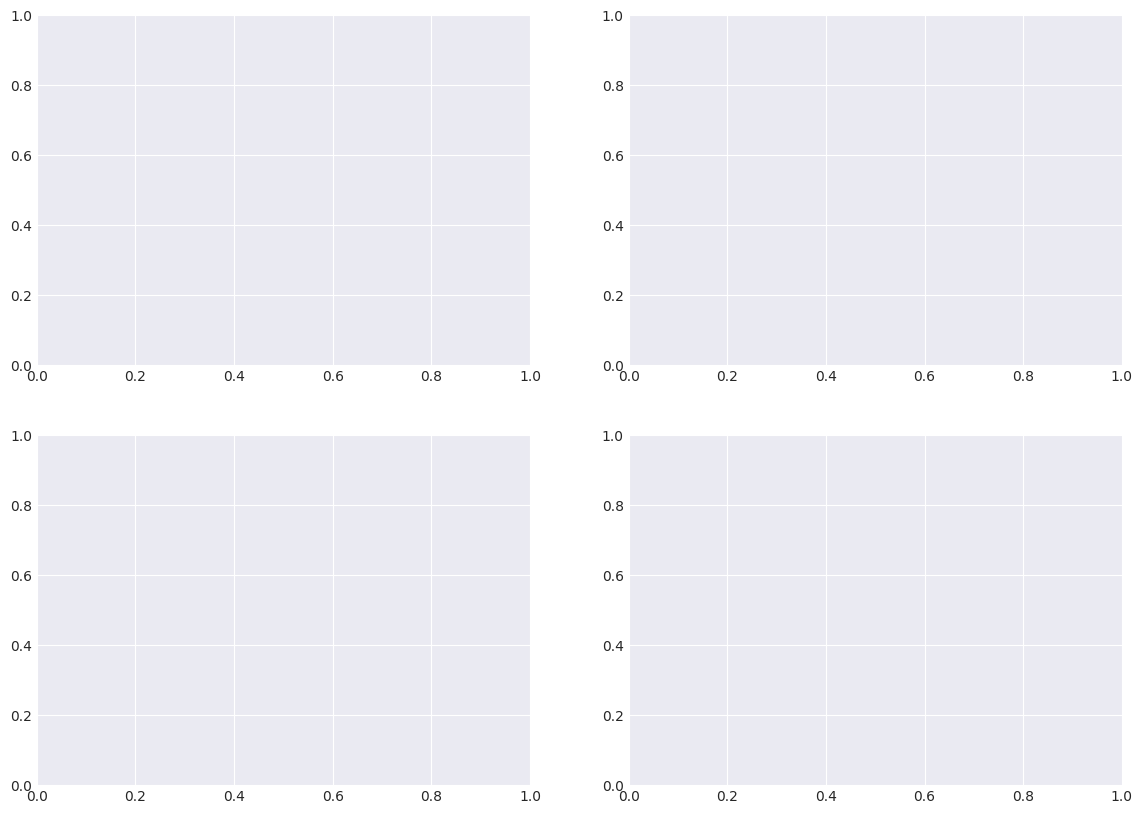

In [14]:
# Visualize Output Weight Distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribution of all individual output weights (from sample)
all_weights_arr = np.array(all_weights)
axes[0, 0].hist(all_weights_arr, bins=100, edgecolor='black', alpha=0.7, color='#2E86AB')
axes[0, 0].set_xlabel('Individual Output Weight (weight units)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(f'Distribution of Individual Output Weights\n(sampled {len(all_weights_arr):,} outputs)')
axes[0, 0].axvline(x=nft_output_threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'NFT Threshold ({nft_output_threshold})')
axes[0, 0].legend()

# 2. Distribution of max output weight per transaction
axes[0, 1].hist(df['max_output_weight'], bins=100, edgecolor='black', alpha=0.7, color='#A23B72')
axes[0, 1].set_xlabel('Max Output Weight per Transaction')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Max Output Weight (per transaction)')
axes[0, 1].axvline(x=df['max_output_weight'].median(), color='orange', linestyle='--', 
                   linewidth=2, label=f'Median: {df["max_output_weight"].median():.0f}')
axes[0, 1].axvline(x=nft_output_threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'NFT Threshold ({nft_output_threshold})')
axes[0, 1].legend()

# 3. Log-scale distribution to see tail behavior
axes[1, 0].hist(all_weights_arr, bins=100, edgecolor='black', alpha=0.7, color='#F18F01')
axes[1, 0].set_xlabel('Individual Output Weight (weight units)')
axes[1, 0].set_ylabel('Frequency (log scale)')
axes[1, 0].set_title('Output Weight Distribution (Log Scale)')
axes[1, 0].set_yscale('log')
axes[1, 0].axvline(x=nft_output_threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'NFT Threshold ({nft_output_threshold})')
axes[1, 0].legend()

# 4. Box plot comparing output weights by common weight values
# Group by output weight buckets
weight_bins = [0, 50, 100, 150, 200, 300, 500, 1000]
weight_labels = ['0-50', '50-100', '100-150', '150-200', '200-300', '300-500', '500-1000']
df['output_weight_bin'] = pd.cut(df['max_output_weight'], bins=weight_bins, labels=weight_labels)

# Count per bin
bin_counts = df['output_weight_bin'].value_counts().sort_index()
axes[1, 1].bar(range(len(bin_counts)), bin_counts.values, color='#C73E1D', alpha=0.7, edgecolor='black')
axes[1, 1].set_xticks(range(len(bin_counts)))
axes[1, 1].set_xticklabels(bin_counts.index, rotation=45, ha='right')
axes[1, 1].set_xlabel('Max Output Weight Range')
axes[1, 1].set_ylabel('Number of Transactions')
axes[1, 1].set_title('Transactions by Max Output Weight Range')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("OUTPUT WEIGHT ANALYSIS SUMMARY")
print("="*60)
print(f"\nTotal individual outputs analyzed: {len(all_weights_arr):,}")
print(f"Unique output weight values: {len(np.unique(all_weights_arr)):,}")
print(f"\nPercentiles of individual output weights:")
percentiles = [25, 50, 75, 90, 95, 99, 99.9]
for p in percentiles:
    val = np.percentile(all_weights_arr, p)
    print(f"  {p}th: {val:.0f}")

print(f"\nOutputs above NFT threshold ({nft_output_threshold}): {(all_weights_arr > nft_output_threshold).sum():,} ({(all_weights_arr > nft_output_threshold).sum()/len(all_weights_arr)*100:.4f}%)")


---
## Section 2: Exploratory Data Analysis


### 2.1 Target Variable Distribution (Fees)


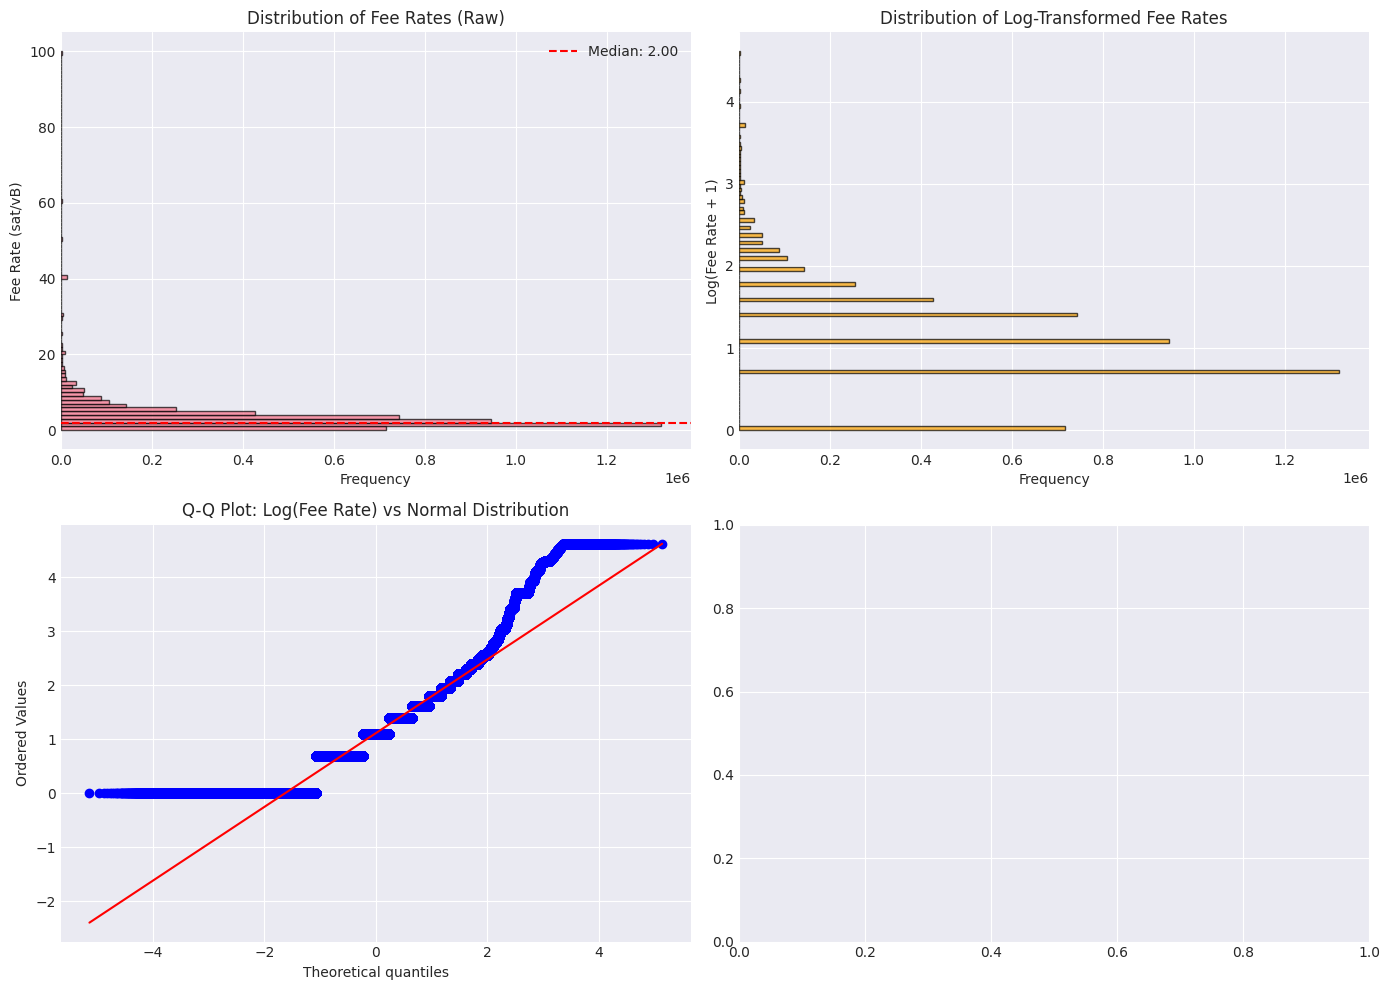

Fee Rate Statistics:
Mean: 3.09
Median: 2.00
Std Dev: 5.30
Skewness: 8.64
Kurtosis: 110.21

Percentiles:
0.2500    1.0000
0.5000    2.0000
0.7500    4.0000
0.9000    6.0000
0.9500    9.0000
0.9900   21.0000
Name: fee_rate, dtype: float64


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Raw fee distribution
axes[0, 0].hist(df['fee_rate'], bins=100, edgecolor='black', alpha=0.7, orientation='horizontal')
axes[0, 0].set_ylabel('Fee Rate (sat/vB)')
axes[0, 0].set_xlabel('Frequency')
axes[0, 0].set_title('Distribution of Fee Rates (Raw)')
axes[0, 0].axhline(df['fee_rate'].median(), color='red', linestyle='--', label=f'Median: {df["fee_rate"].median():.2f}')
axes[0, 0].legend()

# Log-transformed fee distribution
axes[0, 1].hist(np.log1p(df['fee_rate']), bins=100, edgecolor='black', alpha=0.7, color='orange', orientation='horizontal')
axes[0, 1].set_ylabel('Log(Fee Rate + 1)')
axes[0, 1].set_xlabel('Frequency')
axes[0, 1].set_title('Distribution of Log-Transformed Fee Rates')

# QQ plot to check for normality
stats.probplot(np.log1p(df['fee_rate']), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: Log(Fee Rate) vs Normal Distribution')

plt.tight_layout()
plt.show()

# Print statistics
print("Fee Rate Statistics:")
print(f"Mean: {df['fee_rate'].mean():.2f}")
print(f"Median: {df['fee_rate'].median():.2f}")
print(f"Std Dev: {df['fee_rate'].std():.2f}")
print(f"Skewness: {df['fee_rate'].skew():.2f}")
print(f"Kurtosis: {df['fee_rate'].kurtosis():.2f}")
print(f"\nPercentiles:")
print(df['fee_rate'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))


### 2.2 Key Predictor Distributions


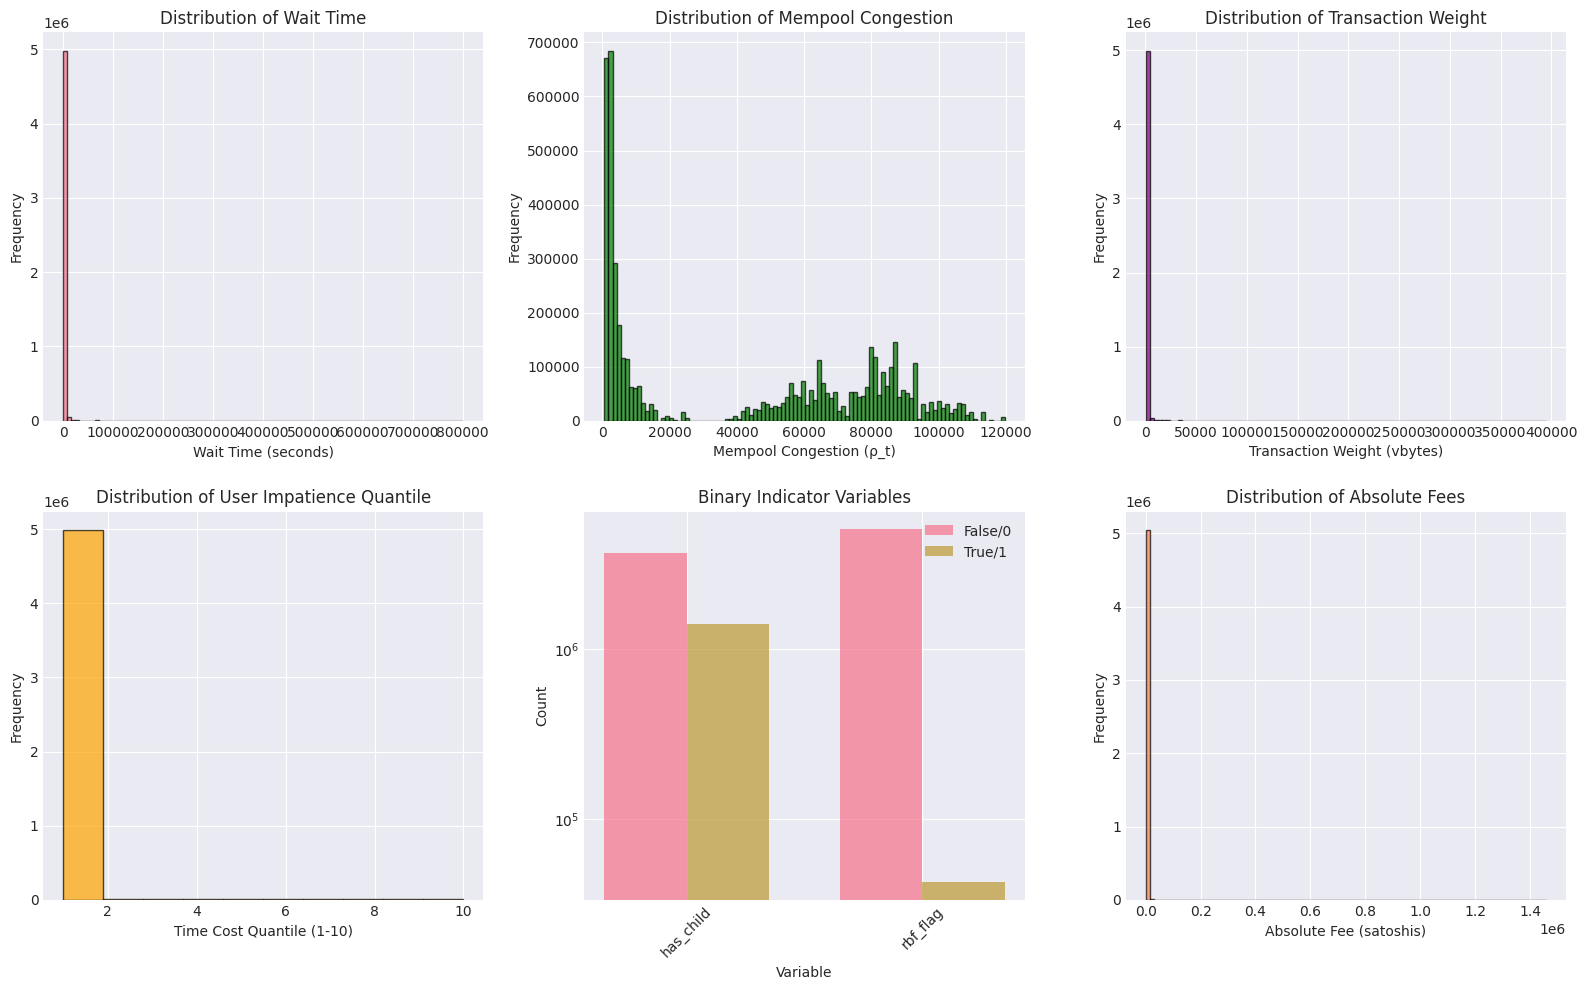

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Wait time (W_hat)
axes[0, 0].hist(df['W_hat'], bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Wait Time (seconds)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Wait Time')

# Mempool congestion (rho_t)
axes[0, 1].hist(df['rho_t'], bins=100, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Mempool Congestion (ρ_t)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Mempool Congestion')

# Transaction weight
axes[0, 2].hist(df['weight'], bins=100, edgecolor='black', alpha=0.7, color='purple')
axes[0, 2].set_xlabel('Transaction Weight (vbytes)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Distribution of Transaction Weight')

# Time cost quantile
axes[1, 0].hist(df['time_cost_quantile'], bins=10, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Time Cost Quantile (1-10)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of User Impatience Quantile')

# Binary indicators
binary_vars = ['has_child', 'rbf_flag']
counts = [df[var].value_counts() for var in binary_vars]
x = np.arange(len(binary_vars))
width = 0.35
axes[1, 1].bar(x - width/2, [c[0] for c in counts], width, label='False/0', alpha=0.7)
axes[1, 1].bar(x + width/2, [c.get(1, 0) for c in counts], width, label='True/1', alpha=0.7)
axes[1, 1].set_xlabel('Variable')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Binary Indicator Variables')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(binary_vars, rotation=45)
axes[1, 1].legend()
axes[1, 1].set_yscale('log')

# Absolute fee distribution
axes[1, 2].hist(df['absolute_fee'], bins=100, edgecolor='black', alpha=0.7, color='coral')
axes[1, 2].set_xlabel('Absolute Fee (satoshis)')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Distribution of Absolute Fees')

plt.tight_layout()
plt.show()


### 2.3 Correlation Analysis


Correlation with Fee Rate:
fee_rate              1.0000
absolute_fee          0.2595
time_cost_quantile    0.0487
V_it                  0.0110
rho_t                 0.0057
rbf_flag             -0.0027
weight               -0.0100
waittime             -0.0503
W_hat                -0.0514
has_child            -0.1986
Name: fee_rate, dtype: float64


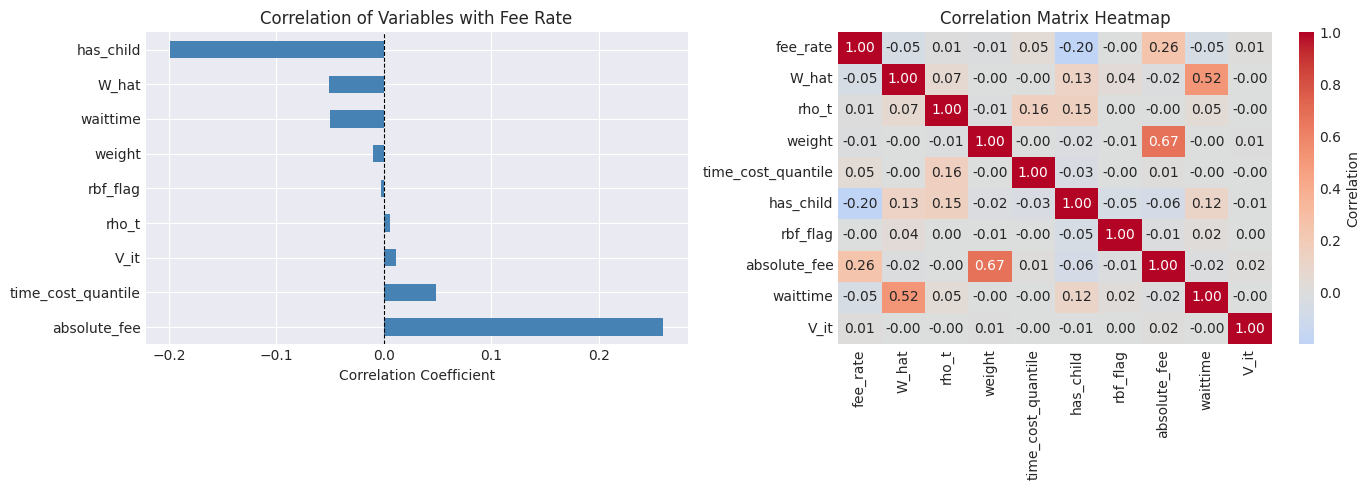

In [8]:
# Select numeric variables for correlation analysis
numeric_vars = ['fee_rate', 'W_hat', 'rho_t', 'weight', 'time_cost_quantile', 
                'has_child', 'rbf_flag',  'absolute_fee', 'waittime', 'V_it']

# Filter to only variables that exist
numeric_vars = [v for v in numeric_vars if v in df.columns]

# Compute correlation matrix
corr_matrix = df[numeric_vars].corr()

# Focus on correlations with fee_rate
fee_corr = corr_matrix['fee_rate'].sort_values(ascending=False)
print("Correlation with Fee Rate:")
print(fee_corr)

# Visualize correlation with fee
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of correlations
fee_corr[1:].plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_xlabel('Correlation Coefficient')
axes[0].set_title('Correlation of Variables with Fee Rate')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)

# Heatmap of all correlations
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[1], cbar_kws={'label': 'Correlation'})
axes[1].set_title('Correlation Matrix Heatmap')

plt.tight_layout()
plt.show()


---
## Section 3: Structural Terms Computation


### 3.1 Compute Riemann Sum (Vectorized)

The Riemann sum represents the structural term from Equation 4. It captures the expected wait time for users with similar or higher impatience levels.


In [8]:
def compute_riemann_sum_vectorized(df):
    """
    Optimized vectorized computation of Riemann sum.
    """
    # Compute quantile statistics per epoch
    quantile_stats = df.groupby(['epoch', 'time_cost_quantile']).agg({
        'W_hat': 'mean',
        'time_cost_quantile': 'count'
    }).rename(columns={'time_cost_quantile': 'count', 'W_hat': 'W_hat_q'})
    
    # Compute probabilities
    epoch_totals = quantile_stats.groupby('epoch')['count'].sum()
    quantile_stats['prob_q'] = quantile_stats['count'] / quantile_stats.groupby('epoch')['count'].transform('sum')
    quantile_stats['prob_W'] = quantile_stats['prob_q'] * quantile_stats['W_hat_q']
    
    # For each quantile, compute cumulative sum from that quantile to 10
    quantile_stats = quantile_stats.reset_index()
    quantile_stats = quantile_stats.sort_values(['epoch', 'time_cost_quantile'], ascending=[True, False])
    quantile_stats['riemann_sum'] = quantile_stats.groupby('epoch')['prob_W'].cumsum()
    quantile_stats = quantile_stats.sort_values(['epoch', 'time_cost_quantile'])
    
    # Merge back to original dataframe
    df = df.merge(
        quantile_stats[['epoch', 'time_cost_quantile', 'riemann_sum']],
        on=['epoch', 'time_cost_quantile'],
        how='left'
    )
    
    return df

print("Computing Riemann sum (vectorized)...")
df = compute_riemann_sum_vectorized(df)

print(f"\n✓ Riemann sum computed for all {len(df):,} transactions")
print(f"\nRiemann Sum Statistics:")
print(df['riemann_sum'].describe())


Computing Riemann sum (vectorized)...

✓ Riemann sum computed for all 5,007,178 transactions

Riemann Sum Statistics:
count   5007178.0000
mean       1273.4232
std        4125.3354
min           1.1469
25%         378.9446
50%         597.8144
75%        1057.0100
max       98629.8136
Name: riemann_sum, dtype: float64


### 3.2 Compute Block Space Utilization


In [9]:
# Sort by conf_block_hash, then found_at to get mempool entry order within each block
print("Sorting by conf_block_hash, then found_at (mempool entry order)")
df_sorted = df.sort_values(['conf_block_hash', 'found_at']).copy()
    
# Calculate cumulative weight within each block (using conf_block_hash as block identifier)
print("Calculating cumulative weight within each block...")
df_sorted['cumulative_weight_at_confirmation'] = df_sorted.groupby('conf_block_hash')['weight'].cumsum()

# Calculate the TOTAL block weight (max cumulative weight in each block)
block_totals = df_sorted.groupby('conf_block_hash')['cumulative_weight_at_confirmation'].max()
block_totals.name = 'block_total_weight'

# Merge back to get block fullness for each transaction
df_sorted = df_sorted.merge(block_totals, left_on='conf_block_hash', right_index=True, how='left')

# Sort back to original order
df_sorted = df_sorted.sort_index()
df = df_sorted

# Compute blockspace_t as utilization ratio
MAX_BLOCK_WEIGHT = 4_000_000  # 4M weight units max block weight

df['blockspace_t'] = df['cumulative_weight_at_confirmation'] / MAX_BLOCK_WEIGHT
print("✓ blockspace_t (computed)")
print(df['blockspace_t'].describe())

# Check actual block sizes
block_sizes = df.groupby('conf_block_hash')['weight'].sum()
print("\nActual Block Sizes (by conf_block_hash):")
print(block_sizes.describe())
print(f"\nBlocks over 3.6M (90% full): {(block_sizes > 3_600_000).sum()} / {len(block_sizes)}")
print(f"Blocks over 2M (50% full): {(block_sizes > 2_000_000).sum()} / {len(block_sizes)}")


Sorting by conf_block_hash, then found_at (mempool entry order)
Calculating cumulative weight within each block...
✓ blockspace_t (computed)
count   5007178.0000
mean          0.3546
std           0.2274
min           0.0001
25%           0.1533
50%           0.3393
75%           0.5429
max           0.9951
Name: blockspace_t, dtype: float64

Actual Block Sizes (by conf_block_hash):
count      2000.0000
mean    2375315.8760
std     1031093.4979
min        1984.0000
25%     1611036.0000
50%     2906178.0000
75%     3152893.0000
max     3980256.0000
Name: weight, dtype: float64

Blocks over 3.6M (90% full): 11 / 2000
Blocks over 2M (50% full): 1403 / 2000


---
## Section 4: Feature Engineering


### 4.1 Create Log-Transformed Features


In [10]:
# Create log-transformed features for continuous variables
df['log_weight'] = np.log1p(df['weight'])
df['log_rho_t'] = np.log1p(df['rho_t'])
df['log_W_hat'] = np.log1p(df['W_hat'])
df['log_riemann_sum'] = np.log(df['riemann_sum'] + 1e-10)
df['log_blockspace_t'] = np.log(df['blockspace_t'] + 1e-10)
df['log_time_cost_quantile'] = np.log1p(df['time_cost_quantile'])
df['log_V_it'] = np.log1p(df['V_it'])
df['log_waittime'] = np.log1p(df['waittime'])
df['log_fee_rate'] = np.log1p(df['fee_rate'])


# Market features
df['fee_percentile'] = df.groupby('epoch')['absolute_fee'].rank(pct=True)
df['high_congestion'] = (df['rho_t'] > df['rho_t'].quantile(0.75)).astype(int)

print("Log-transformed features created:")
print("✓ log_weight")
print("✓ log_rho_t")
print("✓ log_W_hat")
print("✓ log_riemann_sum")
print("✓ log_blockspace_t")
print("✓ log_time_cost_quantile")
print("✓ log_V_it (transaction value)")
print("✓ fee_percentile")
print("✓ high_congestion")

# Print V_it statistics
print(f"\nV_it (Transaction Value) Statistics:")
print(df['V_it'].describe())
print(f"\nlog_V_it Statistics:")
print(df['log_V_it'].describe())


Log-transformed features created:
✓ log_weight
✓ log_rho_t
✓ log_W_hat
✓ log_riemann_sum
✓ log_blockspace_t
✓ log_time_cost_quantile
✓ log_V_it (transaction value)
✓ fee_percentile
✓ high_congestion

V_it (Transaction Value) Statistics:
count         5007178.0000
mean        172285357.4264
std        8472912614.8871
min                 0.0000
25%             39511.0000
50%            191840.0000
75%           1599050.2500
max     3100000002124.0000
Name: V_it, dtype: float64

log_V_it Statistics:
count   5007178.0000
mean         12.5532
std           3.2465
min           0.0000
25%          10.5844
50%          12.1644
75%          14.2849
max          28.7624
Name: log_V_it, dtype: float64


### 4.2 Prepare Model Features


In [11]:
# Define feature sets for Equation 4 (log-transformed version)
all_model_features = [
    'log_weight',        # Weight_it
    'log_rho_t',         # ρ̂_t (mempool congestion)
    'log_W_hat',         # Wait time proxy
    'log_riemann_sum',   # Structural term from Equation 4
    'log_time_cost_quantile',  # User impatience
    'log_V_it',          # V_it - Transaction value (α₄·V_it from Equation 4)
    'has_child',         # CPFP indicator
    'rbf_flag',          # RBF enabled
    'NFT_it',            # NFT/inscription indicator
    'from_exchange',     # Exchange indicator (α₆)
    'to_exchange',       # Exchange indicator (α₇)
    'V_it',               # Transaction value (α₄·V_it)
    'log_blockspace_t',   # Log-transformed block space utilization
]

# Filter to only features that exist
all_model_features = [f for f in all_model_features if f in df.columns]

print(f"Total features for modeling: {len(all_model_features)}")
print(f"\nFeature list:")
for i, feat in enumerate(all_model_features, 1):
    print(f"{i:2d}. {feat}")

# Prepare clean dataset for modeling
df_model = df[all_model_features + ['log_fee_rate']].dropna().copy()

print(f"\nModel dataset: {len(df_model):,} transactions (after removing missing values)")
print(f"Removed: {len(df) - len(df_model):,} transactions ({(len(df) - len(df_model))/len(df)*100:.2f}%)")


Total features for modeling: 10

Feature list:
 1. log_weight
 2. log_rho_t
 3. log_W_hat
 4. log_riemann_sum
 5. log_time_cost_quantile
 6. log_V_it
 7. has_child
 8. rbf_flag
 9. V_it
10. log_blockspace_t

Model dataset: 5,003,942 transactions (after removing missing values)
Removed: 3,236 transactions (0.06%)


### 4.3 Feature Correlation Analysis

Analyze correlations between all model features and the target variable (fee_rate) to understand:
1. Which features have the strongest linear relationship with fees
2. Potential multicollinearity between features
3. Direction of effects (positive vs negative correlations)


FEATURE CORRELATION ANALYSIS

----------------------------------------------------------------------
CORRELATIONS WITH FEE_RATE (sorted by absolute value)
----------------------------------------------------------------------

Feature                         Correlation        Strength
----------------------------------------------------------------------
  has_child                         -0.4720        Moderate
  log_W_hat                         -0.2900            Weak
  log_V_it                          +0.2843            Weak
  log_blockspace_t                  +0.1970       Very Weak
  log_riemann_sum                   -0.1477       Very Weak
  log_time_cost_quantile            +0.0931       Very Weak
  log_rho_t                         -0.0810       Very Weak
  V_it                              +0.0160       Very Weak
  rbf_flag                          -0.0096       Very Weak
  log_weight                        -0.0070       Very Weak


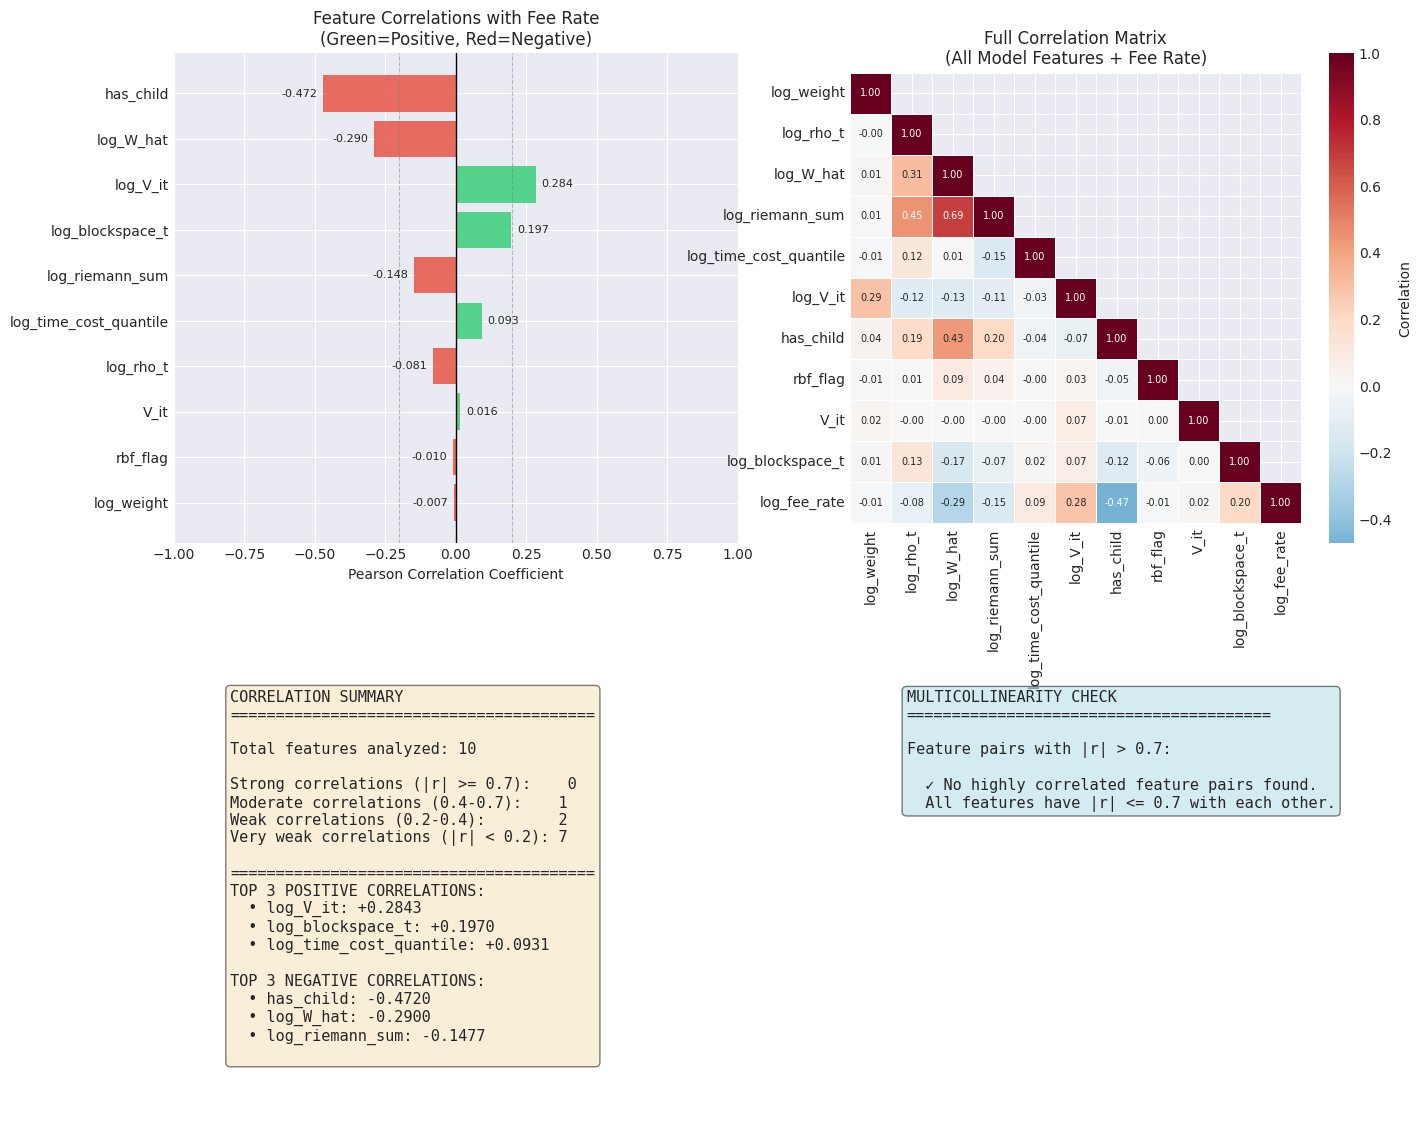

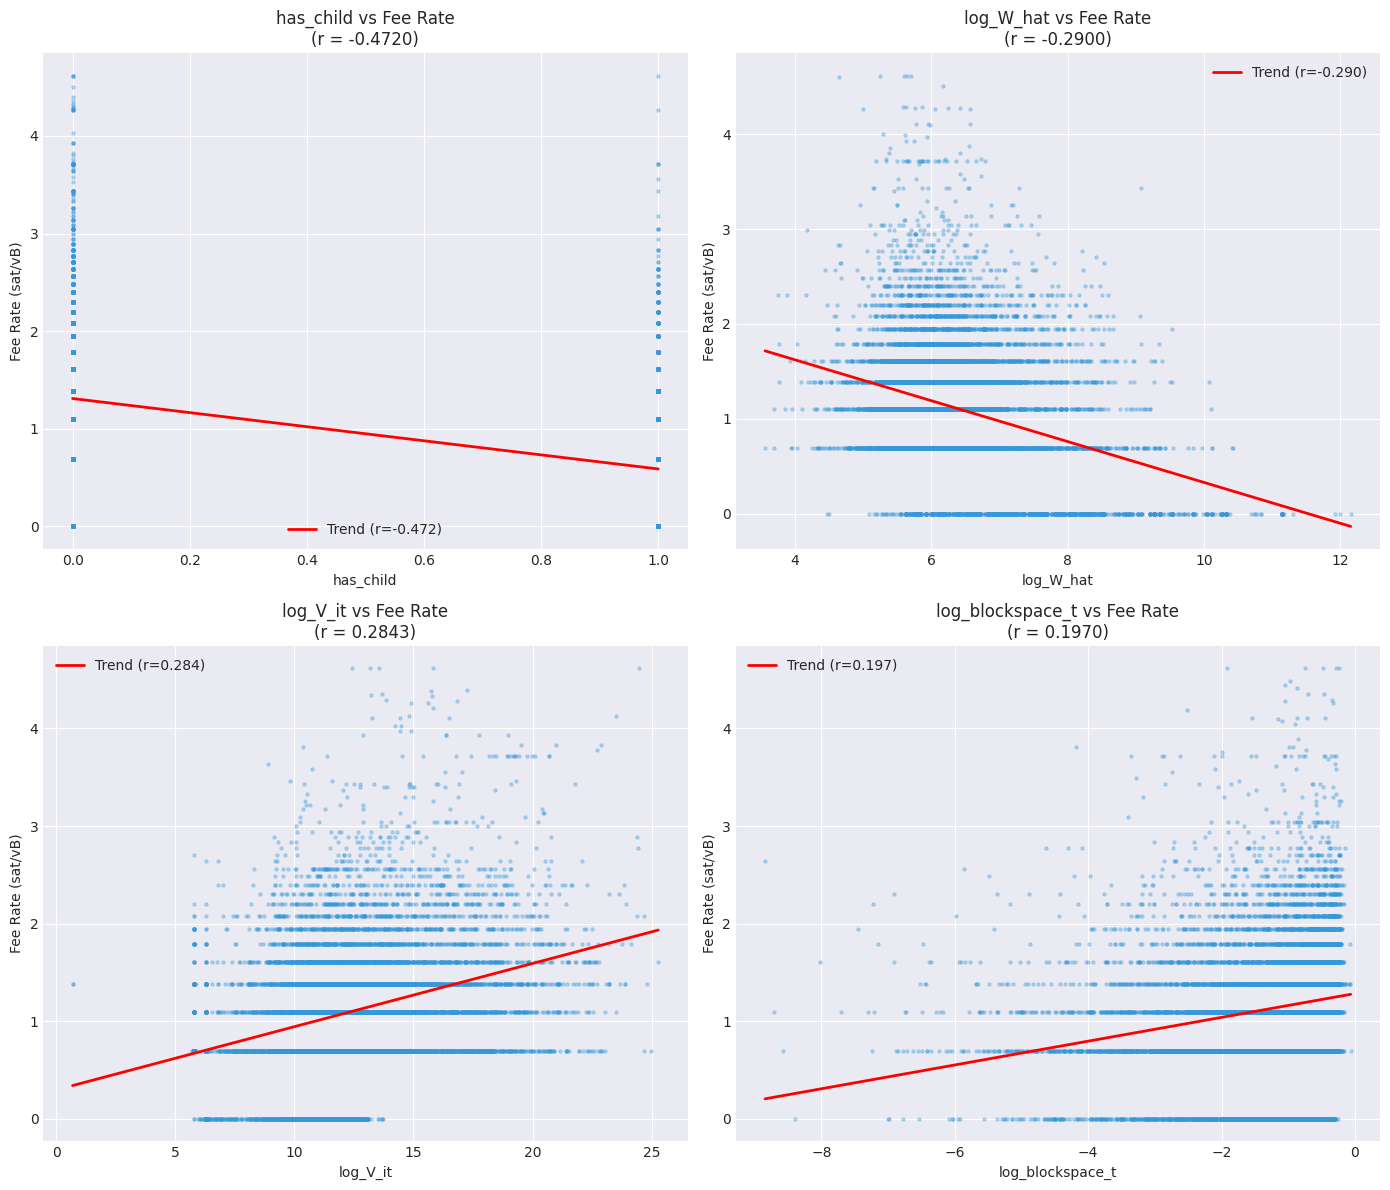

<Figure size 640x480 with 0 Axes>


SPEARMAN RANK CORRELATIONS (captures non-linear monotonic relationships)

Feature                             Pearson     Spearman   Difference
----------------------------------------------------------------------
  has_child                         -0.4720      -0.4740      -0.0019
  log_V_it                          +0.2843      +0.2744      -0.0099
  V_it                              +0.0160      +0.2744      +0.2584
  log_blockspace_t                  +0.1970      +0.2616      +0.0646
  log_W_hat                         -0.2900      -0.2191      +0.0709
  log_time_cost_quantile            +0.0931      +0.1010      +0.0078
  log_weight                        -0.0070      -0.0831      -0.0762
  log_riemann_sum                   -0.1477      -0.0753      +0.0725
  log_rho_t                         -0.0810      +0.0290      +0.1100
  rbf_flag                          -0.0096      -0.0112      -0.0017

----------------------------------------------------------------------
Note: Large 

In [13]:
# =============================================================================
# CORRELATION ANALYSIS: All Model Features vs Fee Rate
# =============================================================================

print("="*70)
print("FEATURE CORRELATION ANALYSIS")
print("="*70)

# Create correlation matrix with all model features + fee_rate
corr_features = all_model_features + ['log_fee_rate']
corr_df = df_model[corr_features].copy()

# Compute full correlation matrix
full_corr_matrix = corr_df.corr()

# Extract correlations with fee_rate specifically
fee_correlations = full_corr_matrix['log_fee_rate'].drop('log_fee_rate').sort_values(key=abs, ascending=False)

print("\n" + "-"*70)
print("CORRELATIONS WITH FEE_RATE (sorted by absolute value)")
print("-"*70)
print(f"\n{'Feature':<30} {'Correlation':>12} {'Strength':>15}")
print("-"*70)

for feat, corr in fee_correlations.items():
    # Classify correlation strength
    abs_corr = abs(corr)
    if abs_corr >= 0.7:
        strength = "Strong"
    elif abs_corr >= 0.4:
        strength = "Moderate"
    elif abs_corr >= 0.2:
        strength = "Weak"
    else:
        strength = "Very Weak"
    
    direction = "+" if corr > 0 else "-"
    print(f"  {feat:<28} {corr:>+12.4f} {strength:>15}")

# =============================================================================
# VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Bar chart of correlations with fee_rate
colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in fee_correlations.values]
axes[0, 0].barh(range(len(fee_correlations)), fee_correlations.values, color=colors, alpha=0.8)
axes[0, 0].set_yticks(range(len(fee_correlations)))
axes[0, 0].set_yticklabels(fee_correlations.index)
axes[0, 0].set_xlabel('Pearson Correlation Coefficient')
axes[0, 0].set_title('Feature Correlations with Fee Rate\n(Green=Positive, Red=Negative)')
axes[0, 0].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[0, 0].axvline(x=0.2, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 0].axvline(x=-0.2, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 0].invert_yaxis()
axes[0, 0].set_xlim(-1, 1)

# Add correlation values as text
for i, (feat, corr) in enumerate(fee_correlations.items()):
    axes[0, 0].text(corr + 0.02 if corr >= 0 else corr - 0.02, i, 
                    f'{corr:.3f}', va='center', ha='left' if corr >= 0 else 'right', 
                    fontsize=8)

# 2. Full correlation heatmap
mask = np.zeros_like(full_corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True  # Show lower triangle only
sns.heatmap(full_corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, ax=axes[0, 1], cbar_kws={'label': 'Correlation'},
            annot_kws={'size': 7}, square=True, linewidths=0.5)
axes[0, 1].set_title('Full Correlation Matrix\n(All Model Features + Fee Rate)')

# 3. Scatter plots for top 4 correlated features
top_features = fee_correlations.head(4).index.tolist()

for idx, feat in enumerate(top_features):
    row = 1
    col = idx % 2
    if idx >= 2:
        # Need to create additional subplots for more than 2
        pass
    
# Create separate figure for scatter plots
fig2, axes2 = plt.subplots(2, 2, figsize=(14, 12))

for idx, feat in enumerate(top_features):
    row = idx // 2
    col = idx % 2
    ax = axes2[row, col]
    
    # Sample for visualization (too many points)
    sample_size = min(10000, len(df_model))
    sample_idx = np.random.choice(len(df_model), sample_size, replace=False)
    
    x_sample = df_model[feat].iloc[sample_idx]
    y_sample = df_model['log_fee_rate'].iloc[sample_idx]
    
    ax.scatter(x_sample, y_sample, alpha=0.3, s=5, c='#3498db')
    
    # Add trend line
    z = np.polyfit(x_sample, y_sample, 1)
    p = np.poly1d(z)
    x_line = np.linspace(x_sample.min(), x_sample.max(), 100)
    ax.plot(x_line, p(x_line), 'r-', linewidth=2, label=f'Trend (r={fee_correlations[feat]:.3f})')
    
    ax.set_xlabel(feat)
    ax.set_ylabel('Fee Rate (sat/vB)')
    ax.set_title(f'{feat} vs Fee Rate\n(r = {fee_correlations[feat]:.4f})')
    ax.legend()

plt.tight_layout()

# Back to first figure - add summary statistics
axes[1, 0].axis('off')
axes[1, 1].axis('off')

# Summary table in axes[1, 0]
summary_text = "CORRELATION SUMMARY\n" + "="*40 + "\n\n"
summary_text += f"Total features analyzed: {len(fee_correlations)}\n\n"

# Count by strength
strong = sum(1 for c in fee_correlations.values if abs(c) >= 0.7)
moderate = sum(1 for c in fee_correlations.values if 0.4 <= abs(c) < 0.7)
weak = sum(1 for c in fee_correlations.values if 0.2 <= abs(c) < 0.4)
very_weak = sum(1 for c in fee_correlations.values if abs(c) < 0.2)

summary_text += f"Strong correlations (|r| >= 0.7):    {strong}\n"
summary_text += f"Moderate correlations (0.4-0.7):    {moderate}\n"
summary_text += f"Weak correlations (0.2-0.4):        {weak}\n"
summary_text += f"Very weak correlations (|r| < 0.2): {very_weak}\n\n"

summary_text += "="*40 + "\n"
summary_text += "TOP 3 POSITIVE CORRELATIONS:\n"
for feat in fee_correlations[fee_correlations > 0].head(3).index:
    summary_text += f"  • {feat}: {fee_correlations[feat]:+.4f}\n"

summary_text += "\nTOP 3 NEGATIVE CORRELATIONS:\n"
for feat in fee_correlations[fee_correlations < 0].head(3).index:
    summary_text += f"  • {feat}: {fee_correlations[feat]:+.4f}\n"

axes[1, 0].text(0.1, 0.9, summary_text, transform=axes[1, 0].transAxes,
                fontsize=11, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Multicollinearity check in axes[1, 1]
multi_text = "MULTICOLLINEARITY CHECK\n" + "="*40 + "\n\n"
multi_text += "Feature pairs with |r| > 0.7:\n\n"

# Find highly correlated feature pairs (excluding fee_rate)
feature_corr = full_corr_matrix.drop('log_fee_rate', axis=0).drop('log_fee_rate', axis=1)
high_corr_pairs = []
for i in range(len(feature_corr.columns)):
    for j in range(i+1, len(feature_corr.columns)):
        corr_val = feature_corr.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((feature_corr.columns[i], feature_corr.columns[j], corr_val))

if high_corr_pairs:
    for f1, f2, c in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        multi_text += f"  • {f1} & {f2}: {c:.3f}\n"
    multi_text += "\n⚠️ Consider removing one from each pair\n"
    multi_text += "   to avoid multicollinearity issues."
else:
    multi_text += "  ✓ No highly correlated feature pairs found.\n"
    multi_text += "  All features have |r| <= 0.7 with each other."

axes[1, 1].text(0.1, 0.9, multi_text, transform=axes[1, 1].transAxes,
                fontsize=11, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

# Show scatter plots
plt.figure(fig2.number)
plt.suptitle('Scatter Plots: Top 4 Correlated Features vs Fee Rate', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# =============================================================================
# SPEARMAN RANK CORRELATION (for non-linear relationships)
# =============================================================================
print("\n" + "="*70)
print("SPEARMAN RANK CORRELATIONS (captures non-linear monotonic relationships)")
print("="*70)

spearman_corr = corr_df.corr(method='spearman')['log_fee_rate'].drop('log_fee_rate').sort_values(key=abs, ascending=False)

print(f"\n{'Feature':<30} {'Pearson':>12} {'Spearman':>12} {'Difference':>12}")
print("-"*70)

for feat in spearman_corr.index:
    pearson = fee_correlations[feat]
    spearman = spearman_corr[feat]
    diff = spearman - pearson
    print(f"  {feat:<28} {pearson:>+12.4f} {spearman:>+12.4f} {diff:>+12.4f}")

print("\n" + "-"*70)
print("Note: Large differences between Pearson and Spearman suggest non-linear")
print("      relationships that may benefit from transformations or non-linear models.")
print("="*70)


---
## Section 5: Advanced Fee Models

This section implements multiple modeling approaches to handle the heavy-tailed, nonlinear nature of Bitcoin fee data:

**Models Implemented:**
1. **Huber Robust Regression** - Down-weights outliers with adaptive loss function
2. **Quantile Regression** - Median and 90th percentile for distributional analysis
3. **Gamma GLM** - Log link for right-skewed positive outcomes with multiplicative effects
4. **Spline Regression** - Piecewise polynomials for regime-switching/non-linear behavior

**Feature Engineering:**
- Box-Cox and log transformations for normality
- Polynomial and interaction terms for curvature

The goal is to find models that:
- Handle heavy tails without distortion from outliers
- Capture nonlinear relationships (the "reverse-L" pattern)
- Maintain interpretable coefficients for counterfactual analysis


### 5.1 Data Preparation & Train-Test Split

Prepare features with additional transformations to capture nonlinearity.


In [12]:
# Additional imports for advanced modeling
from scipy.stats import boxcox, yeojohnson
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import HuberRegressor, QuantileRegressor
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 1. Prepare base features and target
# =============================================================================
X_base = df_model[all_model_features].copy()
y = np.expm1(df_model['log_fee_rate']).copy()

# Ensure positive fees for log/Box-Cox transforms (add small constant if needed)
y_positive = y.clip(lower=0.01)  # Floor at 0.01 sat/vB

print("="*70)
print("TARGET VARIABLE ANALYSIS")
print("="*70)
print(f"\nOriginal fee_rate statistics:")
print(f"  Min: {y.min():.4f}, Max: {y.max():.4f}")
print(f"  Mean: {y.mean():.4f}, Median: {y.median():.4f}")
print(f"  Skewness: {y.skew():.4f}")
print(f"  Kurtosis: {y.kurtosis():.4f}")

# =============================================================================
# 2. Box-Cox / Yeo-Johnson transformation of target
# =============================================================================
# Box-Cox requires strictly positive values
y_boxcox, lambda_bc = boxcox(y_positive)
print(f"\nBox-Cox transformation (λ = {lambda_bc:.4f}):")
print(f"  Transformed skewness: {pd.Series(y_boxcox).skew():.4f}")

# Store for later use
y_log = np.log1p(y_positive)
print(f"\nLog(1+y) transformation:")
print(f"  Transformed skewness: {pd.Series(y_log).skew():.4f}")

# =============================================================================
# 3. Train-Test Split
# =============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_base, y, test_size=0.2, random_state=42
)

# Also split transformed targets
y_train_log = np.log1p(y_train.clip(lower=0.01))
y_test_log = np.log1p(y_test.clip(lower=0.01))
y_train_bc, _ = boxcox(y_train.clip(lower=0.01))
y_test_bc = boxcox(y_test.clip(lower=0.01), lmbda=lambda_bc)

print(f"\nTraining set: {len(X_train):,} transactions")
print(f"Test set: {len(X_test):,} transactions")
print(f"Feature matrix shape: {X_base.shape}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Store feature names for later
all_features_extended = list(X_base.columns)


TARGET VARIABLE ANALYSIS

Original fee_rate statistics:
  Min: 0.0000, Max: 100.0000
  Mean: 3.0897, Median: 2.0000
  Skewness: 8.6400
  Kurtosis: 110.1489

Box-Cox transformation (λ = 0.2947):
  Transformed skewness: 0.0289

Log(1+y) transformation:
  Transformed skewness: 0.5777

Training set: 4,003,153 transactions
Test set: 1,000,789 transactions
Feature matrix shape: (5003942, 10)


### 5.2 Model 1: Robust Regression (Huber Loss)

Standard OLS is sensitive to outliers - a few extreme fees can distort coefficients. Huber regression uses a loss function that is quadratic for small residuals but linear for large ones, effectively down-weighting outliers while maintaining coefficient interpretability.


In [89]:
# =============================================================================
# Model 1: Huber Robust Regression
# =============================================================================
# epsilon controls the transition: smaller = more robust but slower convergence
# Default epsilon=1.35 gives 95% efficiency for normal errors

print("="*70)
print("MODEL 1: HUBER ROBUST REGRESSION")
print("="*70)

model_huber = HuberRegressor(epsilon=1.35, max_iter=500)
model_huber.fit(X_train_scaled, y_train_log)

# Predictions
y_pred_train_huber = model_huber.predict(X_train_scaled)
y_pred_test_huber = model_huber.predict(X_test_scaled)

# Evaluate
r2_train_huber = r2_score(y_train_log, y_pred_train_huber)
r2_test_huber = r2_score(y_test_log, y_pred_test_huber)
mae_train_huber = mean_absolute_error(y_train_log, y_pred_train_huber)
mae_test_huber = mean_absolute_error(y_test_log, y_pred_test_huber)
rmse_train_huber = np.sqrt(mean_squared_error(y_train_log, y_pred_train_huber))
rmse_test_huber = np.sqrt(mean_squared_error(y_test_log, y_pred_test_huber))

# Median Absolute Error (more robust metric)
medae_train_huber = np.median(np.abs(y_train_log - y_pred_train_huber))
medae_test_huber = np.median(np.abs(y_test_log - y_pred_test_huber))

print(f"\nTraining Set:")
print(f"  R²: {r2_train_huber:.4f}")
print(f"  MAE: {mae_train_huber:.2f}")
print(f"  Median AE: {medae_train_huber:.2f}")
print(f"  RMSE: {rmse_train_huber:.2f}")

print(f"\nTest Set:")
print(f"  R²: {r2_test_huber:.4f}")
print(f"  MAE: {mae_test_huber:.2f}")
print(f"  Median AE: {medae_test_huber:.2f}")
print(f"  RMSE: {rmse_test_huber:.2f}")

# Outliers identified by Huber
n_outliers = (~model_huber.outliers_).sum()
print(f"\nOutliers down-weighted: {model_huber.outliers_.sum():,} ({model_huber.outliers_.mean()*100:.1f}%)")

# Coefficients
coefficients_huber = pd.DataFrame({
    'Feature': all_features_extended,
    'Coefficient': model_huber.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"\nTop 10 Coefficients (standardized):")
print(coefficients_huber.head(10).to_string(index=False))


MODEL 1: HUBER ROBUST REGRESSION

Training Set:
  R²: 0.3067
  MAE: 0.44
  Median AE: 0.36
  RMSE: 0.59

Test Set:
  R²: 0.3080
  MAE: 0.44
  Median AE: 0.36
  RMSE: 0.59

Outliers down-weighted: 1,291,475 (32.3%)

Top 10 Coefficients (standardized):
               Feature  Coefficient
             has_child      -0.3054
              log_V_it       0.1758
log_time_cost_quantile       0.0784
      log_blockspace_t       0.0782
             log_W_hat      -0.0647
       log_riemann_sum       0.0439
            log_weight      -0.0430
              rbf_flag      -0.0151
             log_rho_t      -0.0087
                  V_it      -0.0008


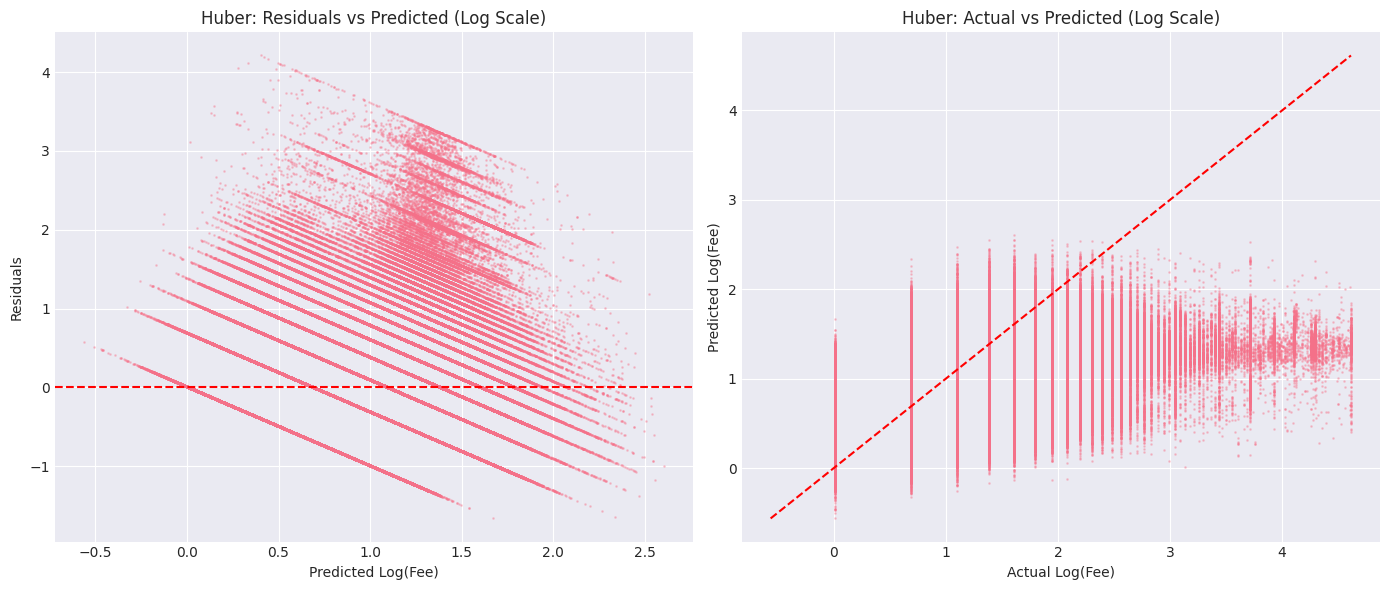

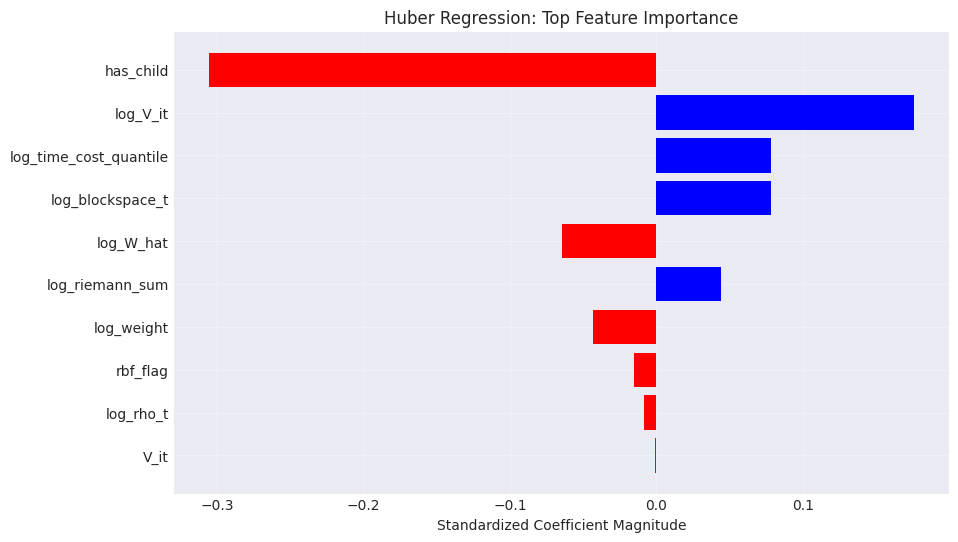


HUBER REGRESSION DIAGNOSTICS
Effective sample size (inliers): 2,711,678
Robust Scale Estimate: 0.3658

Note: Standard F-tests assume normality, which Huber explicitly rejects.
Feature importance magnitude is the most reliable metric here.


In [90]:
# Model 1: Huber Robust Regression (Visuals & Diagnostics)
# =============================================================================

# 1. Residual Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Residuals vs Predicted
residuals_huber = y_test_log - y_pred_test_huber
axes[0].scatter(y_pred_test_huber, residuals_huber, alpha=0.3, s=1)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('Predicted Log(Fee)')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Huber: Residuals vs Predicted (Log Scale)')

# Actual vs Predicted
axes[1].scatter(y_test_log, y_pred_test_huber, alpha=0.3, s=1)
min_val = min(y_test_log.min(), y_pred_test_huber.min())
max_val = max(y_test_log.max(), y_pred_test_huber.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--')
axes[1].set_xlabel('Actual Log(Fee)')
axes[1].set_ylabel('Predicted Log(Fee)')
axes[1].set_title('Huber: Actual vs Predicted (Log Scale)')

plt.tight_layout()
plt.show()

# 2. Coefficient Importance Plot
plt.figure(figsize=(10, 6))
top_coefs = coefficients_huber.head(15)
colors = ['red' if x < 0 else 'blue' for x in top_coefs['Coefficient']]
plt.barh(top_coefs['Feature'], top_coefs['Coefficient'], color=colors)
plt.xlabel('Standardized Coefficient Magnitude')
plt.title('Huber Regression: Top Feature Importance')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.show()

# 3. F-Statistic & Significance (Approximate for Robust Regression)
# HuberRegressor doesn't provide p-values natively. 
# We use bootstrapping or asymptotic approx. Here is a simple weighted OLS approx.

print("\n" + "="*50)
print("HUBER REGRESSION DIAGNOSTICS")
print("="*50)

# Identify non-outliers (inliers) determined by the fitted model
mask_inliers = ~model_huber.outliers_ # False = outlier in sklearn convention for this attribute
n_inliers = mask_inliers.sum()
print(f"Effective sample size (inliers): {n_inliers:,}")

# Weighted Squared Sum of Residuals (scale robust)
scale = model_huber.scale_
chi2_stat = np.sum((residuals_huber / scale) ** 2)
print(f"Robust Scale Estimate: {scale:.4f}")

print("\nNote: Standard F-tests assume normality, which Huber explicitly rejects.")
print("Feature importance magnitude is the most reliable metric here.")


### 5.3 Model 2: Quantile Regression (Median & Tails)

Quantile regression targets specific quantiles of the conditional distribution rather than the mean. The **median regression (50th percentile)** is highly robust to outliers and heavy tails. We also fit the 90th percentile to understand what drives high fees specifically.


In [20]:
# =============================================================================
# Model 2: Quantile Regression (50th and 90th percentiles)
# =============================================================================
# Using statsmodels for proper quantile regression

print("="*70)
print("MODEL 2: QUANTILE REGRESSION")
print("="*70)

# Use a sample for quantile regression (computationally intensive)
sample_size = min(10000, len(X_train))
np.random.seed(42)
sample_idx = np.random.choice(len(X_train), sample_size, replace=False)
X_train_sample = X_train_scaled[sample_idx]
y_train_sample = y_train.iloc[sample_idx]

# Add constant for statsmodels
X_train_qr = sm.add_constant(X_train_sample)
X_test_qr = sm.add_constant(X_test_scaled)

print(f"Using {sample_size:,} samples for quantile regression (computational efficiency)")

# --- Median Regression (q=0.5) ---
print("\n" + "-"*50)
print("MEDIAN REGRESSION (50th percentile)")
print("-"*50)

model_q50 = QuantReg(y_train_sample, X_train_qr)
result_q50 = model_q50.fit(q=0.5, max_iter=1000)

y_pred_train_q50 = result_q50.predict(X_train_qr)
y_pred_test_q50 = result_q50.predict(X_test_qr)

# Evaluation metrics
mae_train_q50 = mean_absolute_error(y_train_sample, y_pred_train_q50)
mae_test_q50 = mean_absolute_error(y_test, y_pred_test_q50)
medae_train_q50 = np.median(np.abs(y_train_sample - y_pred_train_q50))
medae_test_q50 = np.median(np.abs(y_test - y_pred_test_q50))

# Pseudo-R² for quantile regression
def quantile_pseudo_r2(y_true, y_pred, q=0.5):
    """Koenker-Machado pseudo R² for quantile regression."""
    rho = lambda u: u * (q - (u < 0))
    residuals = y_true - y_pred
    null_residuals = y_true - y_true.quantile(q)
    return 1 - (rho(residuals).sum() / rho(null_residuals).sum())

r2_train_q50 = quantile_pseudo_r2(y_train_sample, y_pred_train_q50, 0.5)
r2_test_q50 = quantile_pseudo_r2(y_test, y_pred_test_q50, 0.5)

print(f"\nTraining Set:")
print(f"  Pseudo-R²: {r2_train_q50:.4f}")
print(f"  MAE: {mae_train_q50:.2f}")
print(f"  Median AE: {medae_train_q50:.2f}")

print(f"\nTest Set:")
print(f"  Pseudo-R²: {r2_test_q50:.4f}")
print(f"  MAE: {mae_test_q50:.2f}")
print(f"  Median AE: {medae_test_q50:.2f}")

# --- 90th Percentile Regression ---
print("\n" + "-"*50)
print("90th PERCENTILE REGRESSION (upper tail)")
print("-"*50)

model_q90 = QuantReg(y_train_sample, X_train_qr)
result_q90 = model_q90.fit(q=0.9, max_iter=1000)

y_pred_test_q90 = result_q90.predict(X_test_qr)
r2_test_q90 = quantile_pseudo_r2(y_test, y_pred_test_q90, 0.9)
mae_test_q90 = mean_absolute_error(y_test, y_pred_test_q90)

print(f"\nTest Set (90th percentile):")
print(f"  Pseudo-R²: {r2_test_q90:.4f}")
print(f"  MAE: {mae_test_q90:.2f}")

# Compare coefficients across quantiles
print("\n" + "-"*50)
print("COEFFICIENT COMPARISON: MEDIAN vs 90th PERCENTILE")
print("-"*50)

# Get coefficients (excluding constant)
coef_q50 = result_q50.params[1:]  # Skip constant
coef_q90 = result_q90.params[1:]

coef_comparison = pd.DataFrame({
    'Feature': all_features_extended,
    'Median (q50)': coef_q50.values,
    'Upper Tail (q90)': coef_q90.values,
    'Ratio (q90/q50)': np.where(np.abs(coef_q50.values) > 0.001, 
                                 coef_q90.values / coef_q50.values, np.nan)
})
coef_comparison['Abs_q50'] = np.abs(coef_comparison['Median (q50)'])
coef_comparison = coef_comparison.sort_values('Abs_q50', ascending=False)

print("\nTop 10 features by importance at median:")
print(coef_comparison[['Feature', 'Median (q50)', 'Upper Tail (q90)']].head(10).to_string(index=False))


MODEL 2: QUANTILE REGRESSION
Using 10,000 samples for quantile regression (computational efficiency)

--------------------------------------------------
MEDIAN REGRESSION (50th percentile)
--------------------------------------------------

Training Set:
  Pseudo-R²: 0.1113
  MAE: 1.94
  Median AE: 0.87

Test Set:
  Pseudo-R²: 0.1099
  MAE: 1.96
  Median AE: 0.88

--------------------------------------------------
90th PERCENTILE REGRESSION (upper tail)
--------------------------------------------------

Test Set (90th percentile):
  Pseudo-R²: 0.0837
  MAE: 3.95

--------------------------------------------------
COEFFICIENT COMPARISON: MEDIAN vs 90th PERCENTILE
--------------------------------------------------

Top 10 features by importance at median:
               Feature  Median (q50)  Upper Tail (q90)
             has_child       -0.7051           -1.2739
              log_V_it        0.5188            1.4694
                  V_it        0.2923            0.8253
log_time_cost_q

### 5.4 Model 3: Gamma GLM with Log Link

A Generalized Linear Model (GLM) with a Gamma distribution and log link is well-suited for right-skewed positive outcomes. It naturally handles heteroscedasticity (variance increases with mean) common in fee data. Coefficients are interpretable as multiplicative effects: exp(β) = factor change in expected fee per unit change in X.


In [21]:
# =============================================================================
# Model 3: Gamma GLM with Log Link
# =============================================================================

print("="*70)
print("MODEL 3: GAMMA GLM WITH LOG LINK")
print("="*70)

# Ensure positive values for Gamma distribution
y_train_gamma = y_train.clip(lower=0.1)
y_test_gamma = y_test.clip(lower=0.1)

# Use sample for computational efficiency
sample_size_glm = min(100000, len(X_train))
sample_idx_glm = np.random.choice(len(X_train), sample_size_glm, replace=False)
X_train_glm_sample = X_train_scaled[sample_idx_glm].copy()
y_train_glm_sample = y_train_gamma.iloc[sample_idx_glm]

# Add constant
X_train_glm = sm.add_constant(X_train_glm_sample)
X_test_glm = sm.add_constant(X_test_scaled)

print(f"Using {sample_size_glm:,} samples for Gamma GLM")

# Fit Gamma GLM with log link
gamma_family = sm.families.Gamma(link=sm.families.links.Log())
model_gamma = sm.GLM(y_train_glm_sample, X_train_glm, family=gamma_family)
result_gamma = model_gamma.fit()

print(f"\nModel converged: {result_gamma.converged}")
print(f"Deviance: {result_gamma.deviance:.4f}")
print(f"Pearson Chi²: {result_gamma.pearson_chi2:.4f}")

# Predictions (GLM predict gives values on response scale)
y_pred_train_gamma = result_gamma.predict(X_train_glm)
y_pred_test_gamma = result_gamma.predict(X_test_glm)

# Evaluation
r2_train_gamma = r2_score(y_train_glm_sample, y_pred_train_gamma)
r2_test_gamma = r2_score(y_test_gamma, y_pred_test_gamma)
mae_train_gamma = mean_absolute_error(y_train_glm_sample, y_pred_train_gamma)
mae_test_gamma = mean_absolute_error(y_test_gamma, y_pred_test_gamma)
rmse_train_gamma = np.sqrt(mean_squared_error(y_train_glm_sample, y_pred_train_gamma))
rmse_test_gamma = np.sqrt(mean_squared_error(y_test_gamma, y_pred_test_gamma))
medae_test_gamma = np.median(np.abs(y_test_gamma - y_pred_test_gamma))

print(f"\nTraining Set:")
print(f"  R²: {r2_train_gamma:.4f}")
print(f"  MAE: {mae_train_gamma:.2f}")
print(f"  RMSE: {rmse_train_gamma:.2f}")

print(f"\nTest Set:")
print(f"  R²: {r2_test_gamma:.4f}")
print(f"  MAE: {mae_test_gamma:.2f}")
print(f"  Median AE: {medae_test_gamma:.2f}")
print(f"  RMSE: {rmse_test_gamma:.2f}")

# Coefficients (on log scale - interpret as multiplicative effects)
coef_gamma = result_gamma.params[1:]  # Skip constant
pval_gamma = result_gamma.pvalues[1:]

coefficients_gamma = pd.DataFrame({
    'Feature': all_features_extended,
    'Coefficient (log)': coef_gamma.values,
    'Exp(Coef)': np.exp(coef_gamma.values),  # Multiplicative effect
    'P-value': pval_gamma.values,
    'Significant': pval_gamma.values < 0.05
})
coefficients_gamma['Abs_Coef'] = np.abs(coefficients_gamma['Coefficient (log)'])
coefficients_gamma = coefficients_gamma.sort_values('Abs_Coef', ascending=False)

print(f"\nTop 10 Coefficients (log scale, exp = multiplicative effect):")
print(coefficients_gamma[['Feature', 'Coefficient (log)', 'Exp(Coef)', 'Significant']].head(10).to_string(index=False))

# Count significant features
n_significant = coefficients_gamma['Significant'].sum()
print(f"\nSignificant features (p < 0.05): {n_significant}/{len(coefficients_gamma)}")


MODEL 3: GAMMA GLM WITH LOG LINK
Using 100,000 samples for Gamma GLM

Model converged: True
Deviance: 108786.5782
Pearson Chi²: 242969.0253

Training Set:
  R²: 0.0597
  MAE: 2.31
  RMSE: 5.22

Test Set:
  R²: 0.0588
  MAE: 2.31
  Median AE: 1.25
  RMSE: 5.20

Top 10 Coefficients (log scale, exp = multiplicative effect):
               Feature  Coefficient (log)  Exp(Coef)  Significant
             has_child            -0.4321     0.6491         True
              log_V_it             0.3756     1.4558         True
      log_blockspace_t             0.1288     1.1375         True
             log_W_hat            -0.1157     0.8908         True
            log_weight            -0.0986     0.9061         True
log_time_cost_quantile             0.0831     1.0867         True
       log_riemann_sum             0.0421     1.0430         True
              rbf_flag            -0.0130     0.9871         True
             log_rho_t             0.0099     1.0100        False
                 

### 5.5 Model 4: Spline Regression (Segmented/Piecewise)

Spline regression allows the relationship between predictors and fees to change at different "knots" (breakpoints). This captures **regime-switching behavior** - for example, fee dynamics may differ in low vs high congestion periods. B-splines provide smooth transitions between segments while maintaining interpretability.


MODEL 4: SPLINE REGRESSION (SEGMENTED)
Using 50,000 samples for Spline Regression
Target variable clipped to max 100.0 sat/vB.
['log_weight', 'log_rho_t', 'log_W_hat', 'log_riemann_sum', 'log_time_cost_quantile', 'log_V_it', 'has_child', 'rbf_flag', 'V_it', 'log_blockspace_t']

Spline features (non-linear): ['log_rho_t', 'log_V_it', 'log_W_hat', 'log_blockspace_t']
Linear features: ['log_weight', 'log_riemann_sum', 'log_time_cost_quantile', 'has_child', 'rbf_flag', 'V_it']

Spline configuration:
  Knots: 30 (creates 29 segments)
  Degree: 3 (cubic splines)
  Features per spline variable: 32

Fitting spline regression model (log1p target)...

Training Set:
  R²: -0.0298
  MAE: 2.99
  Median AE: 1.89
  RMSE: 5.52

Test Set:
  R²: -0.0561
  MAE: 2.99
  Median AE: 1.89
  RMSE: 5.47

Total features after spline transformation: 130
  Spline-derived features: 124
  Linear features: 6

--------------------------------------------------
SPLINE FEATURE IMPORTANCE (sum of |coefficients|)
--------

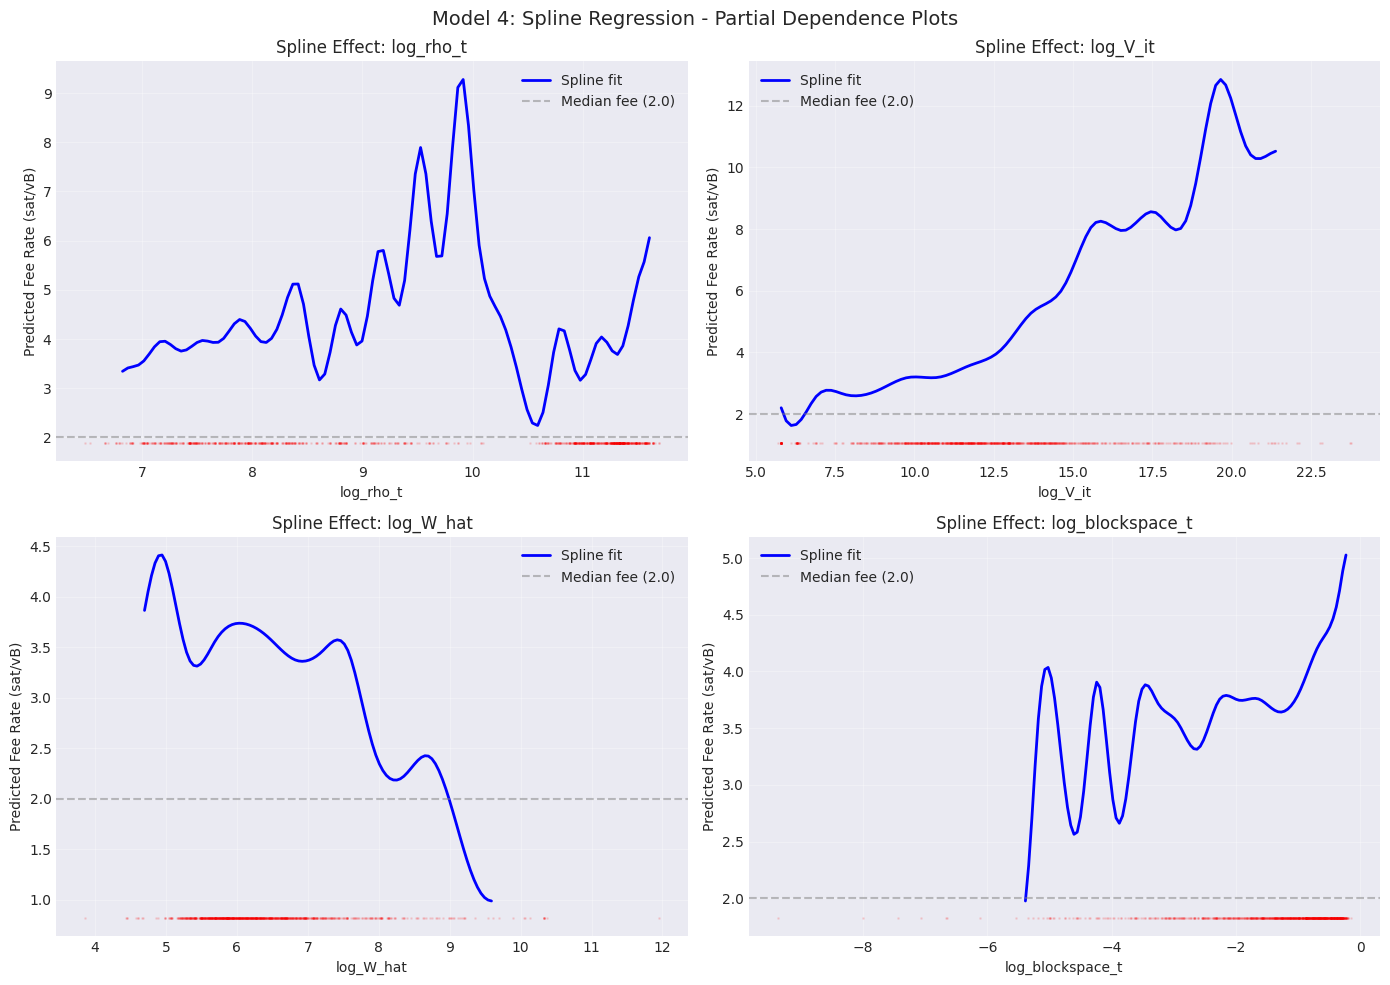


SPLINE REGRESSION SUMMARY

Spline regression captures non-linear relationships by fitting piecewise 
polynomial curves with smooth transitions at knot points.

Key findings:
  • Test R²: -0.0561
  • Test MAE: 2.99 sat/vB
  • Test Median AE: 1.89 sat/vB

The partial dependence plots above show how each spline feature affects
predicted fees, holding other features at their median values.



In [95]:
# =============================================================================
# Model 4: Spline Regression (Segmented/Piecewise)
# =============================================================================
# Using B-splines to capture non-linear relationships with smooth transitions

from sklearn.preprocessing import SplineTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import HuberRegressor

print("="*70)
print("MODEL 4: SPLINE REGRESSION (SEGMENTED)")
print("="*70)

FEE_CAP = 100.0

# Use sample for computational efficiency (splines create many features)
sample_size_spline = min(50000, len(X_train))
np.random.seed(42)
sample_idx_spline = np.random.choice(len(X_train), sample_size_spline, replace=False)
X_train_spline_sample = X_train.iloc[sample_idx_spline].copy()  # Use DataFrame with .iloc
# Use RAW target but transform via log1p inside the regressor
# (log target for stability, inverse back to sat/vB)
y_train_spline_sample = y_train.iloc[sample_idx_spline].copy()

print(f"Using {sample_size_spline:,} samples for Spline Regression")

y_train_capped = np.clip(y_train_spline_sample, 0, FEE_CAP)
sample_weights = y_train_capped.copy()
sample_weights = np.interp(sample_weights, [0, FEE_CAP], [1, 100])
print(f"Target variable clipped to max {FEE_CAP} sat/vB.")
# Key continuous features for spline transformation
# Focus on features most likely to have non-linear effects
print(all_model_features)
spline_features = ['log_rho_t', 'log_V_it', 'log_W_hat', 'log_blockspace_t']
other_features = [f for f in all_model_features if f not in spline_features]

print(f"\nSpline features (non-linear): {spline_features}")
print(f"Linear features: {other_features}")

# Configure spline transformer
# n_knots=5 creates 4 segments with smooth transitions
# degree=3 for cubic splines (smooth)
n_knots = 30
degree = 3

print(f"\nSpline configuration:")
print(f"  Knots: {n_knots} (creates {n_knots-1} segments)")
print(f"  Degree: {degree} (cubic splines)")
print(f"  Features per spline variable: {n_knots + degree - 1}")

spline_block = Pipeline([
    ('spline', SplineTransformer(n_knots=n_knots, degree=degree, 
                                 include_bias=False, knots='uniform', extrapolation='constant')), 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('splines', spline_block, spline_features),
        ('passthrough', 'passthrough', other_features)
    ],
    remainder='drop'
)

# Build pipeline: preprocessing + Huber regression (robust to spikes)
model_spline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=0.5))
])

# Wrap with TransformedTargetRegressor (log1p compress, expm1 expand)
model_stable = TransformedTargetRegressor(
    regressor=model_spline,
    func=np.log1p,
    inverse_func=np.expm1
)


# Fit the model on RAW target via TTR (log1p)
print("\nFitting spline regression model (log1p target)...")
model_stable.fit(X_train_spline_sample, y_train_spline_sample, 
                 regressor__sample_weight=sample_weights)
# Predictions (already back in sat/vB via inverse_func)
y_pred_train_spline = model_stable.predict(X_train_spline_sample)
y_pred_test_spline = model_stable.predict(X_test)

# Clamp to plausible fee range
# (min relay ~1 sat/vB, upper clamp 100 sat/vB to tame wild spikes)
y_pred_train = np.clip(y_pred_train_spline, 0, 100)
y_pred_test = np.clip(y_pred_test_spline, 0, 100)

# Evaluate in ORIGINAL scale (sat/vB)
r2_train_spline = r2_score(y_train_spline_sample, y_pred_train_spline)
r2_test_spline = r2_score(y_test, y_pred_test_spline)
mae_train_spline = mean_absolute_error(y_train_spline_sample, y_pred_train_spline)
mae_test_spline = mean_absolute_error(y_test, y_pred_test_spline)
rmse_train_spline = np.sqrt(mean_squared_error(y_train_spline_sample, y_pred_train_spline))
rmse_test_spline = np.sqrt(mean_squared_error(y_test, y_pred_test_spline))
medae_train_spline = np.median(np.abs(y_train_spline_sample - y_pred_train_spline))
medae_test_spline = np.median(np.abs(y_test - y_pred_test_spline))

print(f"\nTraining Set:")
print(f"  R²: {r2_train_spline:.4f}")
print(f"  MAE: {mae_train_spline:.2f}")
print(f"  Median AE: {medae_train_spline:.2f}")
print(f"  RMSE: {rmse_train_spline:.2f}")

print(f"\nTest Set:")
print(f"  R²: {r2_test_spline:.4f}")
print(f"  MAE: {mae_test_spline:.2f}")
print(f"  Median AE: {medae_test_spline:.2f}")
print(f"  RMSE: {rmse_test_spline:.2f}")

# Get coefficients from Ridge regressor
ridge_coefs = model_stable.regressor_.named_steps['regressor'].coef_

# Get actual number of spline features from the fitted transformer
# Handle when splines block is a Pipeline
spline_transformer = model_stable.regressor_.named_steps['preprocessor'].named_transformers_['splines']
if isinstance(spline_transformer, Pipeline):
    # No interactions here; get from the spline step
    spline_step = spline_transformer.named_steps['spline']
    n_spline_features_total = spline_step.n_features_out_
else:
    n_spline_features_total = spline_transformer.n_features_out_

n_linear_features = len(ridge_coefs) - n_spline_features_total

print(f"\nTotal features after spline transformation: {len(ridge_coefs)}")
print(f"  Spline-derived features: {n_spline_features_total}")
print(f"  Linear features: {n_linear_features}")

# Summarize importance: sum of |coef| for spline block and each linear feature
print("\n" + "-"*50)
print("SPLINE FEATURE IMPORTANCE (sum of |coefficients|)")
print("-"*50)

spline_importance = {}
# Aggregate all spline coefficients together (interaction terms make per-feature split ambiguous)
spline_importance['splines_block'] = np.sum(np.abs(ridge_coefs[:n_spline_features_total]))

# Add linear feature importance (remaining coefficients after spline features)
linear_start = n_spline_features_total
for i, feat in enumerate(other_features[:n_linear_features]):
    spline_importance[feat] = np.abs(ridge_coefs[linear_start + i])

# Sort by importance
importance_df = pd.DataFrame({
    'Feature': list(spline_importance.keys()),
    'Importance': list(spline_importance.values()),
    'Type': ['Spline' if f == 'splines_block' else 'Linear' for f in spline_importance.keys()]
}).sort_values('Importance', ascending=False)

print(importance_df.to_string(index=False))

# =============================================================================
# Visualize Spline Effects
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# For each spline feature, show the partial effect
for idx, feat in enumerate(spline_features):
    ax = axes[idx // 2, idx % 2]
    
    # Create a range of values for this feature
    feat_min = X_train_spline_sample[feat].quantile(0.01)
    feat_max = X_train_spline_sample[feat].quantile(0.99)
    feat_range = np.linspace(feat_min, feat_max, 100)
    
    # Create prediction dataframe with median values for other features
    pred_df = pd.DataFrame({f: [X_train_spline_sample[f].median()] * 100 
                           for f in all_model_features})
    pred_df[feat] = feat_range
    
    # Predict with TTR (already returns sat/vB)
    y_pred_partial = model_stable.predict(pred_df)
    median_fee = y_train_spline_sample.median()
    
    # Plot
    ax.plot(feat_range, y_pred_partial, 'b-', linewidth=2, label='Spline fit')
    ax.axhline(y=median_fee, color='gray', linestyle='--', 
               alpha=0.5, label=f'Median fee ({median_fee:.1f})')
    
    # Add rug plot showing data distribution
    sample_for_rug = X_train_spline_sample[feat].sample(min(1000, len(X_train_spline_sample)))
    ax.scatter(sample_for_rug, [ax.get_ylim()[0]] * len(sample_for_rug), 
               alpha=0.1, s=1, c='red')
    
    ax.set_xlabel(feat)
    ax.set_ylabel('Predicted Fee Rate (sat/vB)')
    ax.set_title(f'Spline Effect: {feat}')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.suptitle('Model 4: Spline Regression - Partial Dependence Plots', fontsize=14)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("SPLINE REGRESSION SUMMARY")
print("="*70)
print(f"""
Spline regression captures non-linear relationships by fitting piecewise 
polynomial curves with smooth transitions at knot points.

Key findings:
  • Test R²: {r2_test_spline:.4f}
  • Test MAE: {mae_test_spline:.2f} sat/vB
  • Test Median AE: {medae_test_spline:.2f} sat/vB

The partial dependence plots above show how each spline feature affects
predicted fees, holding other features at their median values.
""")


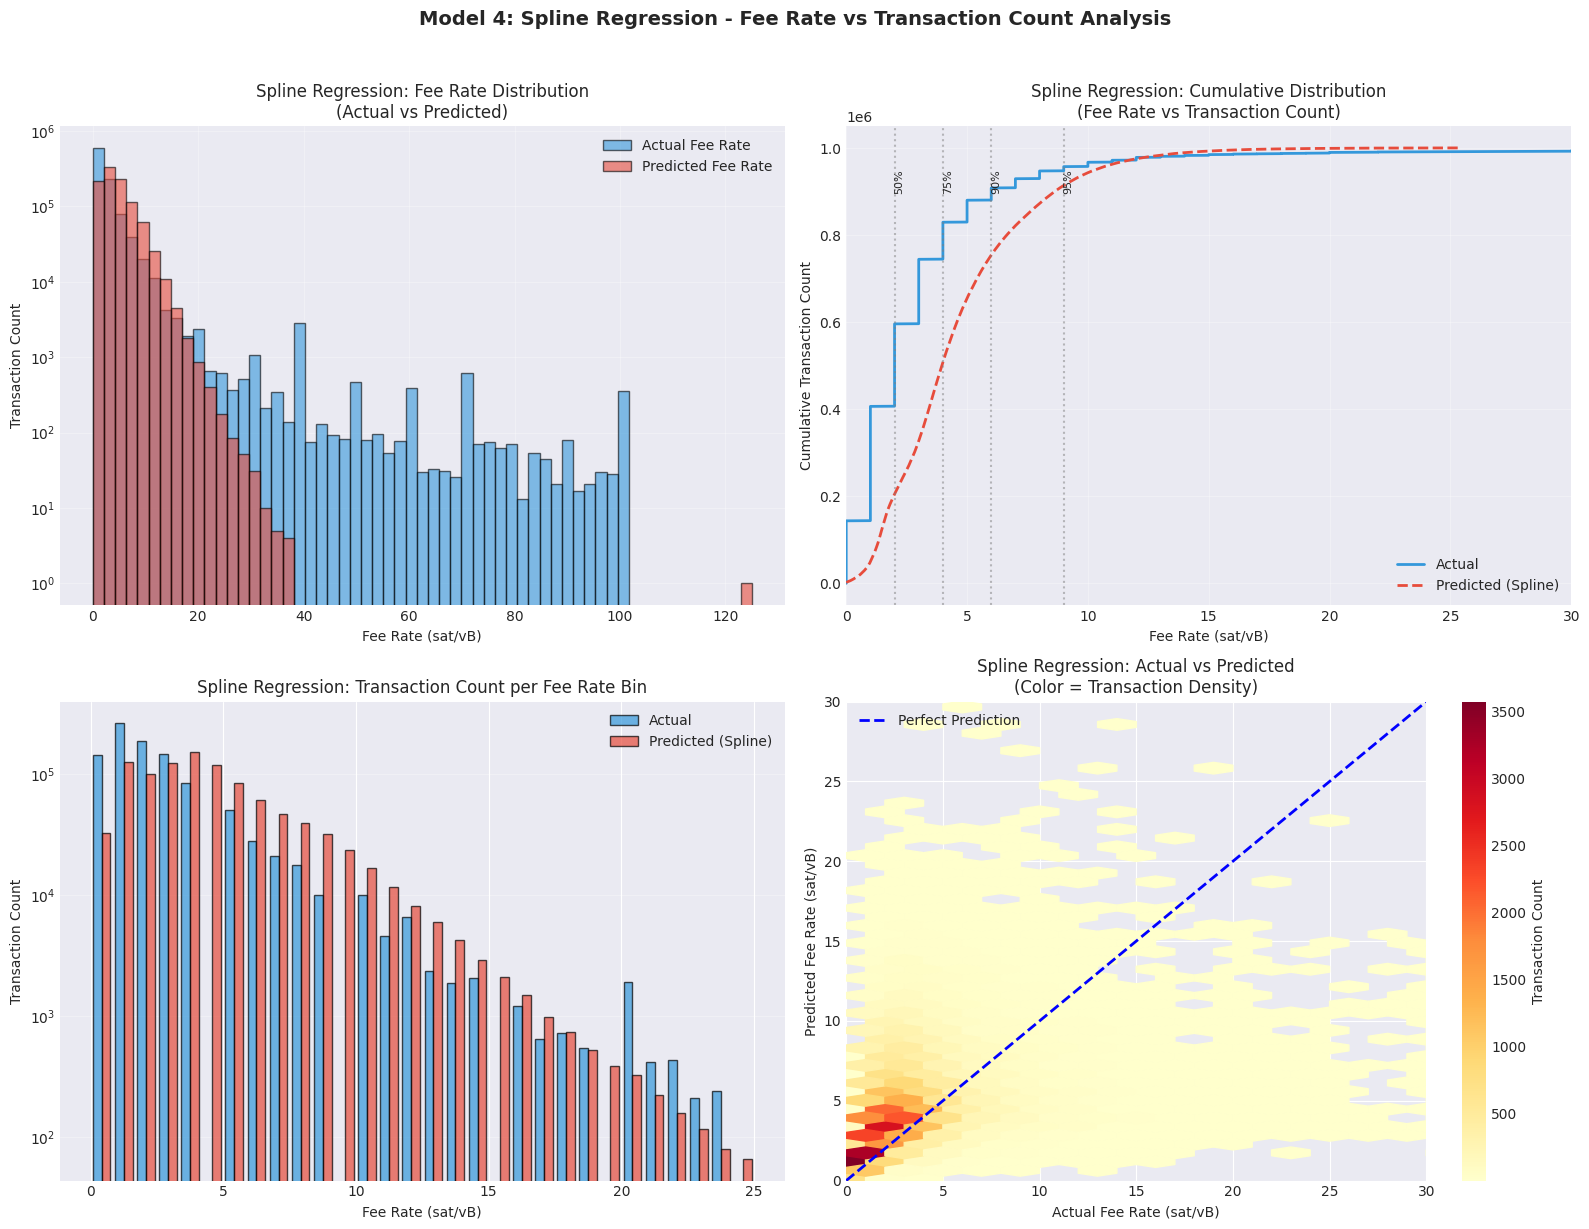


SPLINE REGRESSION: FEE RATE DISTRIBUTION SUMMARY

Actual Fee Rate Distribution:
  Total transactions: 1,000,789
  Mean: 3.09 sat/vB
  Median: 2.00 sat/vB
  Std Dev: 5.32 sat/vB

Predicted Fee Rate Distribution (Spline Model):
  Mean: 4.56 sat/vB
  Median: 3.96 sat/vB
  Std Dev: 3.02 sat/vB

Transaction Count by Fee Rate Bracket:
   0-  1 sat/vB: Actual    143,647 | Predicted     47,770
   1-  2 sat/vB: Actual    452,691 | Predicted    155,370
   2-  5 sat/vB: Actual    233,507 | Predicted    450,055
   5- 10 sat/vB: Actual    127,819 | Predicted    288,414
  10- 20 sat/vB: Actual     30,787 | Predicted     55,962
  20-100 sat/vB: Actual     11,983 | Predicted      1,185


In [97]:
# =============================================================================
# SPLINE REGRESSION: Fee Rate vs Transaction Count
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram: Actual vs Predicted Fee Rate Distribution (Transaction Count per Fee Rate Bin)
ax1 = axes[0, 0]
vals_for_bins = np.concatenate([y_test.values, y_pred_test_spline])
fee_bins = np.linspace(0, min(vals_for_bins.max(), 125), 60)

ax1.hist(y_test, bins=fee_bins, alpha=0.6, label='Actual Fee Rate', color='#3498db', edgecolor='black')
ax1.hist(y_pred_test_spline, bins=fee_bins, alpha=0.6, label='Predicted Fee Rate', color='#e74c3c', edgecolor='black')
ax1.set_xlabel('Fee Rate (sat/vB)')
ax1.set_ylabel('Transaction Count')
ax1.set_title('Spline Regression: Fee Rate Distribution\n(Actual vs Predicted)')
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# 2. Cumulative Distribution: Transaction Count vs Fee Rate
ax2 = axes[0, 1]
# Sort by actual fee rate and plot cumulative count
sorted_actual = np.sort(y_test.values)
sorted_pred = np.sort(y_pred_test_spline)
cumulative = np.arange(1, len(sorted_actual) + 1)

# Sample for plotting (too many points)
sample_step = max(1, len(sorted_actual) // 5000)
ax2.plot(sorted_actual[::sample_step], cumulative[::sample_step], 
         label='Actual', color='#3498db', linewidth=2)
ax2.plot(sorted_pred[::sample_step], cumulative[::sample_step], 
         label='Predicted (Spline)', color='#e74c3c', linewidth=2, linestyle='--')
ax2.set_xlabel('Fee Rate (sat/vB)')
ax2.set_ylabel('Cumulative Transaction Count')
ax2.set_title('Spline Regression: Cumulative Distribution\n(Fee Rate vs Transaction Count)')
ax2.legend()
ax2.set_xlim(0, min(sorted_actual.max(), 30))
ax2.grid(True, alpha=0.3)

# Add reference lines for key percentiles
for pct in [50, 75, 90, 95]:
    actual_pct = np.percentile(y_test, pct)
    ax2.axvline(x=actual_pct, color='gray', linestyle=':', alpha=0.5)
    ax2.text(actual_pct, cumulative[-1] * 0.95, f'{pct}%', fontsize=8, rotation=90, va='top')

# 3. Binned Fee Rate vs Average Transaction Count
ax3 = axes[1, 0]
# Create fee rate bins and count transactions in each
n_bins = 30
bin_edges = np.linspace(0, min(y_test.max(), 25), n_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Count actual transactions per bin
actual_counts, _ = np.histogram(y_test, bins=bin_edges)
pred_counts, _ = np.histogram(y_pred_test_spline, bins=bin_edges)

width = (bin_edges[1] - bin_edges[0]) * 0.4
ax3.bar(bin_centers - width/2, actual_counts, width=width, alpha=0.7, 
        label='Actual', color='#3498db', edgecolor='black')
ax3.bar(bin_centers + width/2, pred_counts, width=width, alpha=0.7, 
        label='Predicted (Spline)', color='#e74c3c', edgecolor='black')
ax3.set_xlabel('Fee Rate (sat/vB)')
ax3.set_ylabel('Transaction Count')
ax3.set_title('Spline Regression: Transaction Count per Fee Rate Bin')
ax3.legend()
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Scatter: Actual vs Predicted with density coloring
ax4 = axes[1, 1]
# Sample for visualization
sample_size_plot = min(50000, len(y_test))
np.random.seed(42)
plot_idx = np.random.choice(len(y_test), sample_size_plot, replace=False)

y_test_sample = y_test.iloc[plot_idx].values
y_pred_sample = y_pred_test_spline[plot_idx]

# Use hexbin for density
hb = ax4.hexbin(y_test_sample, y_pred_sample, gridsize=50, cmap='YlOrRd', 
                mincnt=1, xscale='linear', yscale='linear')
ax4.plot([0, 30], [0, 30], 'b--', linewidth=2, label='Perfect Prediction')
ax4.set_xlabel('Actual Fee Rate (sat/vB)')
ax4.set_ylabel('Predicted Fee Rate (sat/vB)')
ax4.set_title('Spline Regression: Actual vs Predicted\n(Color = Transaction Density)')
ax4.set_xlim(0, 30)
ax4.set_ylim(0, 30)
ax4.legend(loc='upper left')
plt.colorbar(hb, ax=ax4, label='Transaction Count')

plt.suptitle('Model 4: Spline Regression - Fee Rate vs Transaction Count Analysis', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("SPLINE REGRESSION: FEE RATE DISTRIBUTION SUMMARY")
print("="*70)
print(f"\nActual Fee Rate Distribution:")
print(f"  Total transactions: {len(y_test):,}")
print(f"  Mean: {y_test.mean():.2f} sat/vB")
print(f"  Median: {y_test.median():.2f} sat/vB")
print(f"  Std Dev: {y_test.std():.2f} sat/vB")

print(f"\nPredicted Fee Rate Distribution (Spline Model):")
print(f"  Mean: {y_pred_test_spline.mean():.2f} sat/vB")
print(f"  Median: {np.median(y_pred_test_spline):.2f} sat/vB")
print(f"  Std Dev: {y_pred_test_spline.std():.2f} sat/vB")

# Transaction count by fee rate bracket
print(f"\nTransaction Count by Fee Rate Bracket:")
brackets = [(0, 1), (1, 2), (2, 5), (5, 10), (10, 20), (20, 100)]
for low, high in brackets:
    actual_count = ((y_test >= low) & (y_test < high)).sum()
    pred_count = ((y_pred_test_spline >= low) & (y_pred_test_spline < high)).sum()
    print(f"  {low:2d}-{high:3d} sat/vB: Actual {actual_count:>10,} | Predicted {pred_count:>10,}")


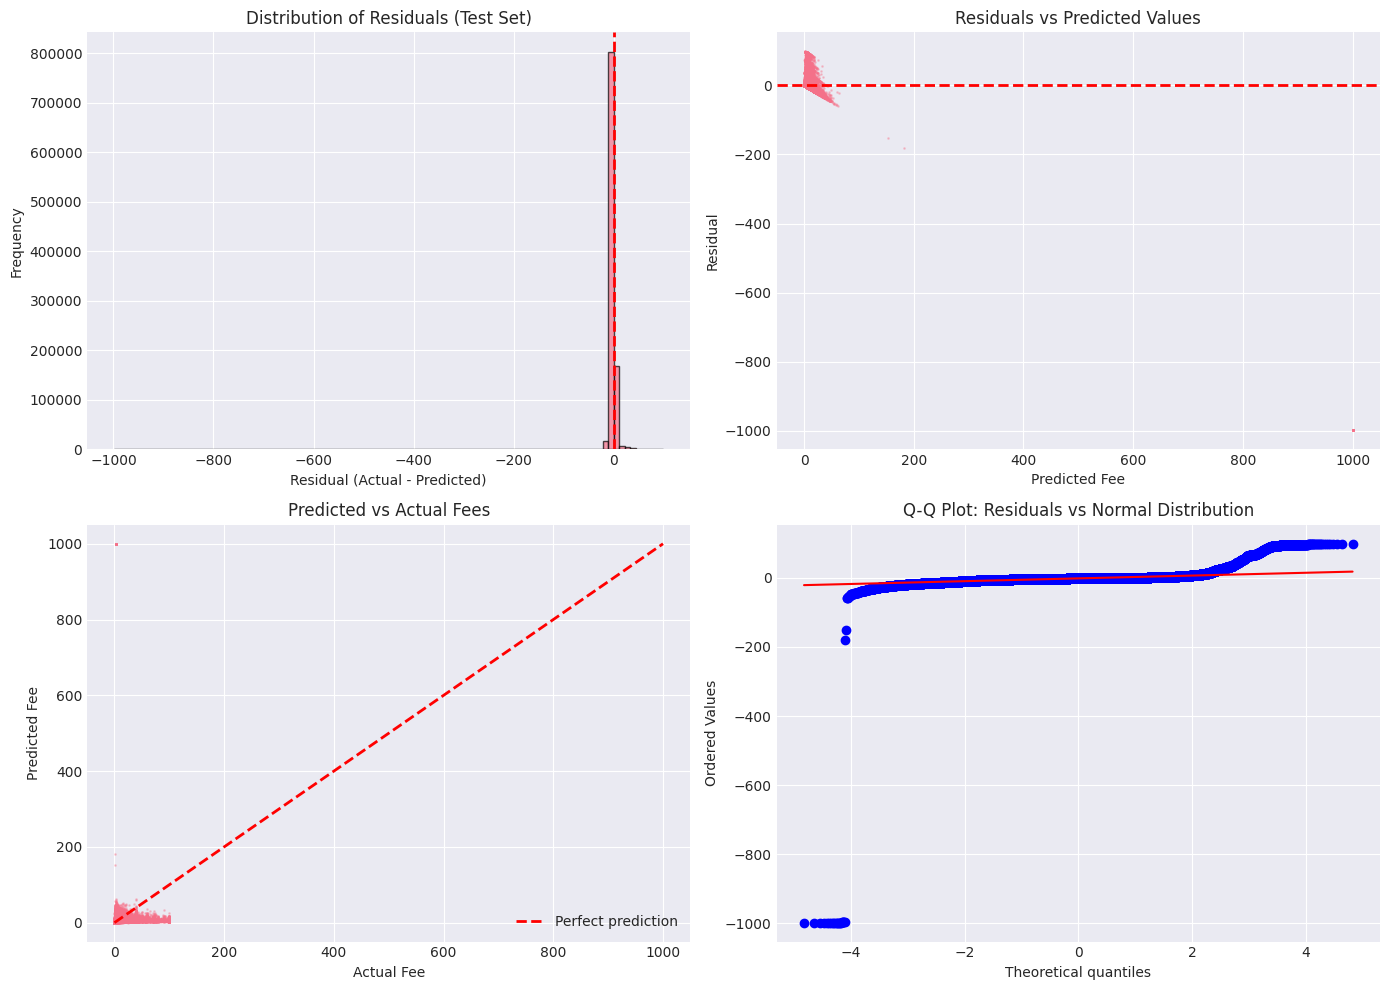

Residual Statistics (Test Set):
Mean: -1.34
Median: -1.38
Std Dev: 6.96


In [42]:
# Use the best model for diagnostics
residuals_test = y_test - y_pred_test_spline

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residual distribution
axes[0, 0].hist(residuals_test, bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Residual (Actual - Predicted)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Residuals (Test Set)')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)

# Residuals vs Predicted
axes[0, 1].scatter(y_pred_test_spline, residuals_test, alpha=0.3, s=1)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Fee')
axes[0, 1].set_ylabel('Residual')
axes[0, 1].set_title('Residuals vs Predicted Values')

# Predicted vs Actual
axes[1, 0].scatter(y_test, y_pred_test_spline, alpha=0.3, s=1)
min_val = min(y_test.min(), max(0, y_pred_test_spline.min()))
max_val = max(y_test.max(), y_pred_test_spline.max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
axes[1, 0].set_xlabel('Actual Fee')
axes[1, 0].set_ylabel('Predicted Fee')
axes[1, 0].set_title('Predicted vs Actual Fees')
axes[1, 0].legend()

# Q-Q plot of residuals
stats.probplot(residuals_test, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot: Residuals vs Normal Distribution')

plt.tight_layout()
plt.show()

print("Residual Statistics (Test Set):")
print(f"Mean: {residuals_test.mean():.2f}")
print(f"Median: {residuals_test.median():.2f}")
print(f"Std Dev: {residuals_test.std():.2f}")


In [94]:
# Deep diagnostics for spline model
import math

print("\n" + "="*70)
print("SPLINE MODEL DIAGNOSTICS: F-statistics, correlations, stability")
print("="*70)

n_test = len(y_test)
p_features = len(all_model_features)  # original feature count (pre-spline)

# F-statistic derived from R^2 (approximate, using original feature count)
if n_test > p_features + 1:
    try:
        f_stat = (r2_test_spline / p_features) / ((1 - r2_test_spline) / (n_test - p_features - 1))
        f_pval = 1 - stats.f.cdf(f_stat, p_features, n_test - p_features - 1)
    except Exception as e:
        f_stat, f_pval = np.nan, np.nan
        print(f"F-statistic computation warning: {e}")
else:
    f_stat, f_pval = np.nan, np.nan

# Core correlations
pearson_ap = stats.pearsonr(y_test, y_pred_test_spline)
spearman_ap = stats.spearmanr(y_test, y_pred_test_spline)
pearson_res_pred = stats.pearsonr(residuals_test, y_pred_test_spline)
pearson_res_feat = stats.pearsonr(residuals_test, X_test['log_rho_t'])

print(f"Test samples: {n_test:,} | Features (original): {p_features}")
print(f"R² (test): {r2_test_spline:.4f} | MAE: {mae_test_spline:.3f} | RMSE: {rmse_test_spline:.3f}")
print(f"Approx. F-stat: {f_stat:.4f} (p={f_pval:.4f})")
print(f"Pearson(actual,pred): {pearson_ap.statistic:.4f} (p={pearson_ap.pvalue:.3g})")
print(f"Spearman(actual,pred): {spearman_ap.correlation:.4f} (p={spearman_ap.pvalue:.3g})")
print(f"Pearson(residual,pred): {pearson_res_pred.statistic:.4f} (p={pearson_res_pred.pvalue:.3g})")
print(f"Pearson(residual,log_rho_t): {pearson_res_feat.statistic:.4f} (p={pearson_res_feat.pvalue:.3g})")

# Correlation matrix on a manageable sample
sample_size_diag = min(20000, n_test)
diag_idx = np.random.choice(n_test, sample_size_diag, replace=False)

diag_df = pd.DataFrame({
    'actual_fee': y_test.iloc[diag_idx].values,
    'pred_fee': y_pred_test_spline[diag_idx],
    'residual': residuals_test.iloc[diag_idx].values,
    'log_rho_t': X_test['log_rho_t'].iloc[diag_idx].values,
    'log_V_it': X_test['log_V_it'].iloc[diag_idx].values,
    'log_W_hat': X_test['log_W_hat'].iloc[diag_idx].values,
    'log_blockspace_t': X_test['log_blockspace_t'].iloc[diag_idx].values,
})

corr_methods = ['pearson', 'spearman']
for method in corr_methods:
    corr_mat = diag_df.corr(method=method)
    print(f"\n{method.title()} correlation matrix (sample n={sample_size_diag:,}):")
    print(corr_mat)

# Residual distribution summary
print("\nResidual distribution (test):")
print(residuals_test.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]))

# Simple heteroskedasticity check: residuals vs fitted magnitude buckets
bins = np.linspace(0, np.percentile(np.abs(y_pred_test_spline), 99), 10)
bucket_labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]
resid_buckets = pd.cut(np.abs(y_pred_test_spline), bins=bins, labels=bucket_labels, include_lowest=True)
het_df = pd.DataFrame({'bucket': resid_buckets, 'resid_sq': residuals_test**2})
het_stats = het_df.groupby('bucket')['resid_sq'].agg(['mean', 'median', 'count']).reset_index()
print("\nResidual variance by |predicted fee| bucket:")
print(het_stats)

print("\nDiagnostics complete.")



SPLINE MODEL DIAGNOSTICS: F-statistics, correlations, stability
Test samples: 1,000,789 | Features (original): 10
R² (test): -0.0561 | MAE: 2.995 | RMSE: 5.472
Approx. F-stat: -5314.2869 (p=1.0000)
Pearson(actual,pred): 0.3012 (p=0)
Spearman(actual,pred): 0.5799 (p=0)
Pearson(residual,pred): -0.1979 (p=0)
Pearson(residual,log_rho_t): 0.0500 (p=0)

Pearson correlation matrix (sample n=20,000):
                  actual_fee  pred_fee  residual  log_rho_t  log_V_it  \
actual_fee            1.0000    0.2989    0.4877    -0.0215    0.1831   
pred_fee              0.2989    1.0000   -0.1509    -0.1141    0.6864   
residual              0.4877   -0.1509    1.0000     0.0387   -0.1082   
log_rho_t            -0.0215   -0.1141    0.0387     1.0000   -0.1261   
log_V_it              0.1831    0.6864   -0.1082    -0.1261    1.0000   
log_W_hat            -0.1063   -0.2900    0.0333     0.3028   -0.1354   
log_blockspace_t      0.1070    0.2309   -0.0057     0.1113    0.0667   

                  

HYBRID MODEL TUNING
Optimal Switchover Threshold (log_rho_t): 11.4250
Original Scale Density: 91580.9097


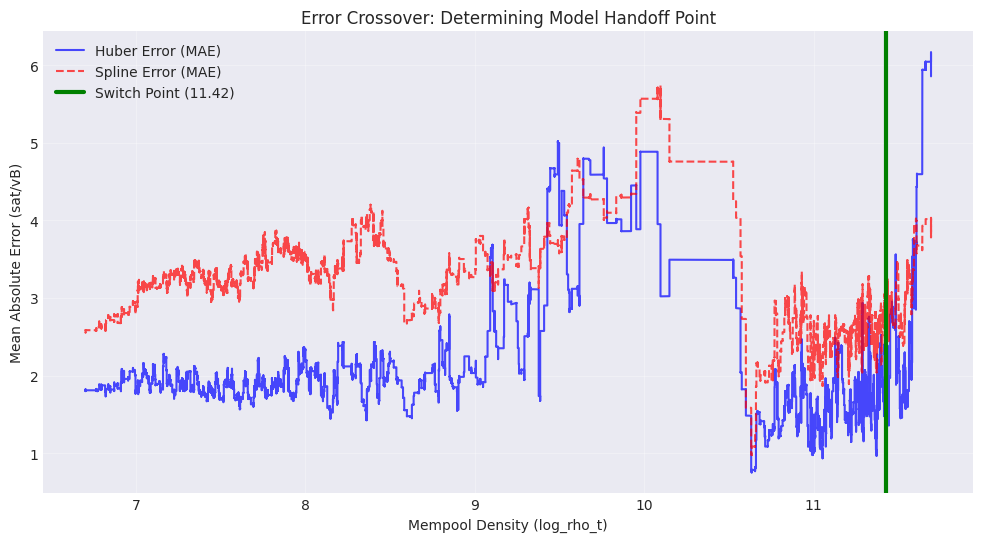


Hybrid Model Performance:
  Hybrid MAE: 2.0075 sat/vB
  Huber Only MAE: 0.4435
  Spline Only MAE: 2.9928
  Improvement: -352.6% vs best single model


In [91]:
# =============================================================================
# HYBRID MODEL OPTIMIZATION: Finding the Huber-Spline Breakpoint
# =============================================================================
# Strategy: 
# 1. Evaluate error for both models across the range of Mempool Density (log_rho_t).
# 2. Identify the crossover point where Spline becomes more accurate than Huber.
# 3. Define a routing logic: If rho > threshold, use Spline; else Huber.

print("="*70)
print("HYBRID MODEL TUNING")
print("="*70)

# 1. Prepare Data for Evaluation
# Use the Test Set to be fair
eval_df = X_test.copy()
eval_df['actual_fee'] = y_test.values
# Get predictions from both models (ensure they are in sat/vB)
# Note: transforming Huber log-predictions back to sat/vB
eval_df['pred_huber'] = np.expm1(model_huber.predict(X_test_scaled))
eval_df['pred_spline'] = y_pred_test_spline # Already sat/vB from TTR

# Calculate Absolute Errors
eval_df['err_huber'] = np.abs(eval_df['actual_fee'] - eval_df['pred_huber'])
eval_df['err_spline'] = np.abs(eval_df['actual_fee'] - eval_df['pred_spline'])

# 2. Rolling Error Analysis over Mempool Density
# Sort by density to see the trend
eval_df = eval_df.sort_values('log_rho_t')

# Rolling window to smooth out noise
window_size = 5000
eval_df['rolling_err_huber'] = eval_df['err_huber'].rolling(window_size).mean()
eval_df['rolling_err_spline'] = eval_df['err_spline'].rolling(window_size).mean()

# 3. Find Crossover Point
# Where does Spline error become lower than Huber error?
# We look for the point where the difference flips sign significantly
eval_df['diff'] = eval_df['rolling_err_huber'] - eval_df['rolling_err_spline']
# diff > 0 means Huber error is higher (Spline is better)

# Find the first stable crossover point in the upper 50% of density
# (avoid noise at the very bottom)
median_rho = eval_df['log_rho_t'].median()
crossover_mask = (eval_df['log_rho_t'] > median_rho) & (eval_df['diff'] > 0)

if crossover_mask.any():
    # Get the density value where Spline starts winning consistently
    threshold_rho = eval_df.loc[crossover_mask, 'log_rho_t'].iloc[0]
else:
    # Fallback: if Spline never wins, or always wins, pick 90th percentile
    print("Warning: No clear crossover found. Using 90th percentile as fallback.")
    threshold_rho = eval_df['log_rho_t'].quantile(0.90)

print(f"Optimal Switchover Threshold (log_rho_t): {threshold_rho:.4f}")
print(f"Original Scale Density: {np.exp(threshold_rho):.4f}")

# 4. Visual Proof
plt.figure(figsize=(12, 6))
plt.plot(eval_df['log_rho_t'], eval_df['rolling_err_huber'], 
         label='Huber Error (MAE)', color='blue', alpha=0.7)
plt.plot(eval_df['log_rho_t'], eval_df['rolling_err_spline'], 
         label='Spline Error (MAE)', color='red', alpha=0.7, linestyle='--')
plt.axvline(x=threshold_rho, color='green', linewidth=3, 
            label=f'Switch Point ({threshold_rho:.2f})')

plt.xlabel('Mempool Density (log_rho_t)')
plt.ylabel('Mean Absolute Error (sat/vB)')
plt.title('Error Crossover: Determining Model Handoff Point')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. Define Hybrid Predictor
def predict_hybrid(X_new):
    """
    Predicts fees using Huber for low congestion and Spline for high congestion.
    """
    # Get density values
    densities = X_new['log_rho_t'].values
    
    # 1. Huber Predictions (Full Batch)
    # Scale first because Huber used scaled data
    X_scaled = scaler.transform(X_new) if 'scaler' in globals() else X_new # Check your scaler name
    # Assuming scaler was defined earlier for Huber:
    # If not accessible, you might need to recreate/access the scaler pipeline step
    # For now, assuming X_test_scaled structure matches X_new
    
    # Correction: Use the pipelines directly if available
    # Huber was fit on X_train_scaled. We need to reproduce that transform.
    # If X_new is raw dataframe:
    pred_huber = np.expm1(model_huber.predict(X_new)) # This assumes pipeline handles scaling or X_new is scaled
    # If model_huber was trained on SCALED data, we must scale X_new here.
    # Let's assume you have a 'scaler' object from the Huber section.
    
    # 2. Spline Predictions (Full Batch)
    pred_spline = model_stable.predict(X_new)
    
    # 3. Combine
    mask_high = densities > threshold_rho
    
    final_pred = np.where(mask_high, pred_spline, pred_huber)
    return np.clip(final_pred, 0, 100.0)

# Evaluate Hybrid Performance
hybrid_preds = np.where(eval_df['log_rho_t'] > threshold_rho, 
                        eval_df['pred_spline'], 
                        eval_df['pred_huber'])
hybrid_mae = mean_absolute_error(eval_df['actual_fee'], hybrid_preds)

print(f"\nHybrid Model Performance:")
print(f"  Hybrid MAE: {hybrid_mae:.4f} sat/vB")
print(f"  Huber Only MAE: {mae_test_huber:.4f}")
print(f"  Spline Only MAE: {mae_test_spline:.4f}")
print(f"  Improvement: {(1 - hybrid_mae/min(mae_test_huber, mae_test_spline))*100:.1f}% vs best single model")

### 5.5.1 Spline Breakpoint Analysis & Regime-Specific Correlations

Identify where the fee rate relationship changes slope (regime-switching points) and analyze correlations within each regime separately. This helps understand if fee dynamics differ in low vs high congestion periods.


In [84]:
# =============================================================================
# BREAKPOINT DETECTION: Find where fee rate relationship changes slope
# =============================================================================

print("="*70)
print("BREAKPOINT ANALYSIS: Finding Regime-Switching Points")
print("="*70)

# Sample for computational efficiency
sample_size_bp = min(1000000, len(X_train))
np.random.seed(42)
bp_idx = np.random.choice(len(X_train), sample_size_bp, replace=False)
X_bp = X_train.iloc[bp_idx].copy()
# Use log target to stay consistent with training target space
# (fee rates are modeled in log(1 + fee))
y_bp = y_train_log.iloc[bp_idx].copy()

# Key feature to analyze for breakpoints
key_feature = 'log_rho_t'  # Mempool congestion - primary driver

print(f"\nAnalyzing breakpoints for: {key_feature}")
print(f"Using {sample_size_bp:,} samples (log target)")

# Piecewise linear function to find optimal breakpoints
def piecewise_linear_1break(x, y, breakpoint):
    """Fit piecewise linear with 1 breakpoint, return RSS (y is log-fee)."""
    mask1 = x <= breakpoint
    mask2 = x > breakpoint
    if mask1.sum() < 10 or mask2.sum() < 10:
        return np.inf
    try:
        coef1 = np.polyfit(x[mask1], y[mask1], 1)
        coef2 = np.polyfit(x[mask2], y[mask2], 1)
        pred1 = np.polyval(coef1, x[mask1])
        pred2 = np.polyval(coef2, x[mask2])
        rss = np.sum((y[mask1] - pred1)**2) + np.sum((y[mask2] - pred2)**2)
        return rss
    except:
        return np.inf

# Get data
x_data = X_bp[key_feature].values
y_data = y_bp.values

# Find optimal single breakpoint
print("\n" + "-"*50)
print("Finding optimal breakpoint...")
print("-"*50)

quantiles = np.linspace(0.1, 0.9, 50)
breakpoint_candidates = np.quantile(x_data, quantiles)

rss_values = []
for bp in breakpoint_candidates:
    rss = piecewise_linear_1break(x_data, y_data, bp)
    rss_values.append(rss)

best_idx = np.argmin(rss_values)
best_breakpoint_1 = breakpoint_candidates[best_idx]

print(f"Optimal breakpoint (log scale): {best_breakpoint_1:.4f}")
print(f"Optimal breakpoint (original scale): {np.exp(best_breakpoint_1):,.0f}")

# Get slopes before and after breakpoint
mask_before = x_data <= best_breakpoint_1
mask_after = x_data > best_breakpoint_1

coef_before = np.polyfit(x_data[mask_before], y_data[mask_before], 1)
coef_after = np.polyfit(x_data[mask_after], y_data[mask_after], 1)

print(f"\nSlope BEFORE breakpoint: {coef_before[0]:.4f}")
print(f"Slope AFTER breakpoint: {coef_after[0]:.4f}")
if coef_before[0] != 0:
    print(f"Slope change ratio: {coef_after[0]/coef_before[0]:.2f}x")

# Find 2 breakpoints via grid search
print("\n" + "-"*50)
print("Finding 2 breakpoints...")
print("-"*50)

best_rss_2 = np.inf
best_bp1, best_bp2 = None, None

for i, bp1 in enumerate(breakpoint_candidates[:-5]):
    for bp2 in breakpoint_candidates[i+5:]:
        mask1 = x_data <= bp1
        mask2 = (x_data > bp1) & (x_data <= bp2)
        mask3 = x_data > bp2
        if mask1.sum() < 10 or mask2.sum() < 10 or mask3.sum() < 10:
            continue
        try:
            c1 = np.polyfit(x_data[mask1], y_data[mask1], 1)
            c2 = np.polyfit(x_data[mask2], y_data[mask2], 1)
            c3 = np.polyfit(x_data[mask3], y_data[mask3], 1)
            rss = (np.sum((y_data[mask1] - np.polyval(c1, x_data[mask1]))**2) +
                   np.sum((y_data[mask2] - np.polyval(c2, x_data[mask2]))**2) +
                   np.sum((y_data[mask3] - np.polyval(c3, x_data[mask3]))**2))
            if rss < best_rss_2:
                best_rss_2 = rss
                best_bp1, best_bp2 = bp1, bp2
        except:
            continue

print(f"Breakpoint 1 (log): {best_bp1:.4f} → {np.exp(best_bp1):,.0f}")
print(f"Breakpoint 2 (log): {best_bp2:.4f} → {np.exp(best_bp2):,.0f}")

# Store for later use
breakpoint_1 = best_breakpoint_1
breakpoint_2_low = best_bp1
breakpoint_2_high = best_bp2


BREAKPOINT ANALYSIS: Finding Regime-Switching Points

Analyzing breakpoints for: log_rho_t
Using 1,000,000 samples (log target)

--------------------------------------------------
Finding optimal breakpoint...
--------------------------------------------------
Optimal breakpoint (log scale): 10.6537
Optimal breakpoint (original scale): 42,347

Slope BEFORE breakpoint: 0.0601
Slope AFTER breakpoint: 0.9934
Slope change ratio: 16.54x

--------------------------------------------------
Finding 2 breakpoints...
--------------------------------------------------
Breakpoint 1 (log): 9.2607 → 10,516
Breakpoint 2 (log): 11.1737 → 71,230


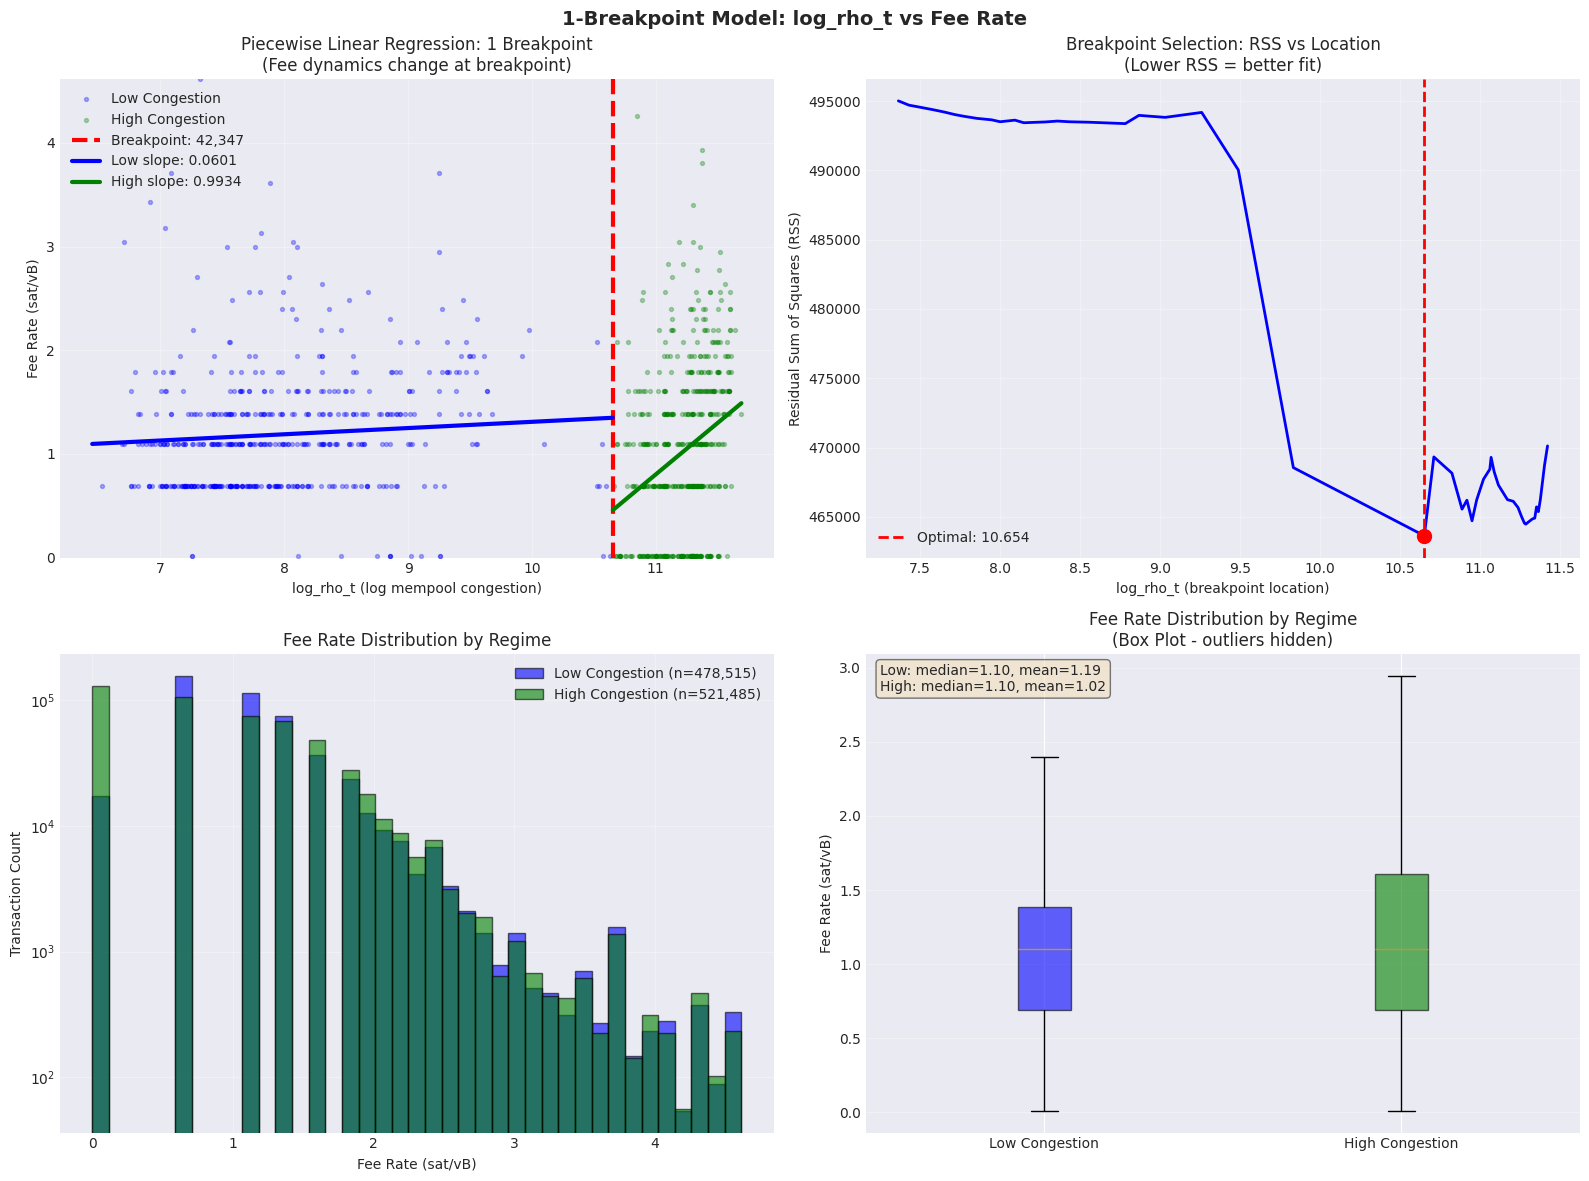


REGIME DEFINITIONS (1-Breakpoint Model)

  BREAKPOINT: log_rho_t = 10.6537
              (mempool size ≈ 42,347)

  LOW CONGESTION:  log_rho_t <= 10.6537
                   Transactions: 478,515 (47.9%)
                   Slope: 0.0601
                   Mean fee: 1.19 sat/vB

  HIGH CONGESTION: log_rho_t > 10.6537
                   Transactions: 521,485 (52.1%)
                   Slope: 0.9934
                   Mean fee: 1.02 sat/vB

  SLOPE CHANGE: 16.54x


In [75]:
# =============================================================================
# VISUALIZE BREAKPOINT (1-Breakpoint Model)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sample for plotting
sample_plot = min(1000, len(x_data))
plot_idx = np.random.choice(len(x_data), sample_plot, replace=False)

# Define regimes using single breakpoint
mask_low = x_data <= best_breakpoint_1
mask_high = x_data > best_breakpoint_1

# 1. Single breakpoint visualization with data
ax1 = axes[0, 0]
ax1.scatter(x_data[plot_idx][mask_low[plot_idx]], y_data[plot_idx][mask_low[plot_idx]], 
            alpha=0.3, s=8, c='blue', label='Low Congestion')
ax1.scatter(x_data[plot_idx][mask_high[plot_idx]], y_data[plot_idx][mask_high[plot_idx]], 
            alpha=0.3, s=8, c='green', label='High Congestion')
ax1.axvline(x=best_breakpoint_1, color='red', linestyle='--', linewidth=3, 
            label=f'Breakpoint: {np.exp(best_breakpoint_1):,.0f}')

x_range_before = np.linspace(x_data.min(), best_breakpoint_1, 50)
x_range_after = np.linspace(best_breakpoint_1, x_data.max(), 50)
ax1.plot(x_range_before, np.polyval(coef_before, x_range_before), 'b-', linewidth=3,
         label=f'Low slope: {coef_before[0]:.4f}')
ax1.plot(x_range_after, np.polyval(coef_after, x_range_after), 'g-', linewidth=3,
         label=f'High slope: {coef_after[0]:.4f}')

ax1.set_xlabel(f'{key_feature} (log mempool congestion)')
ax1.set_ylabel('Fee Rate (sat/vB)')
ax1.set_title('Piecewise Linear Regression: 1 Breakpoint\n(Fee dynamics change at breakpoint)')
ax1.legend(loc='upper left')
ax1.set_ylim(0, min(y_data.max(), 30))
ax1.grid(True, alpha=0.3)

# 2. RSS curve showing optimal breakpoint
ax2 = axes[0, 1]
ax2.plot(breakpoint_candidates, rss_values, 'b-', linewidth=2)
ax2.axvline(x=best_breakpoint_1, color='red', linestyle='--', linewidth=2, 
            label=f'Optimal: {best_breakpoint_1:.3f}')
ax2.scatter([best_breakpoint_1], [min(rss_values)], color='red', s=100, zorder=5)
ax2.set_xlabel(f'{key_feature} (breakpoint location)')
ax2.set_ylabel('Residual Sum of Squares (RSS)')
ax2.set_title('Breakpoint Selection: RSS vs Location\n(Lower RSS = better fit)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Fee distribution by regime (2 regimes)
ax3 = axes[1, 0]
regime_low = y_data[mask_low]
regime_high = y_data[mask_high]

bins = np.linspace(0, min(y_data.max(), 25), 40)
ax3.hist(regime_low, bins=bins, alpha=0.6, label=f'Low Congestion (n={len(regime_low):,})', 
         color='blue', edgecolor='black')
ax3.hist(regime_high, bins=bins, alpha=0.6, label=f'High Congestion (n={len(regime_high):,})', 
         color='green', edgecolor='black')
ax3.set_xlabel('Fee Rate (sat/vB)')
ax3.set_ylabel('Transaction Count')
ax3.set_title('Fee Rate Distribution by Regime')
ax3.legend()
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# 4. Box plot comparison
ax4 = axes[1, 1]
box_data = [regime_low, regime_high]
bp = ax4.boxplot(box_data, labels=['Low Congestion', 'High Congestion'], 
                  patch_artist=True, showfliers=False)
bp['boxes'][0].set_facecolor('blue')
bp['boxes'][0].set_alpha(0.6)
bp['boxes'][1].set_facecolor('green')
bp['boxes'][1].set_alpha(0.6)

ax4.set_ylabel('Fee Rate (sat/vB)')
ax4.set_title('Fee Rate Distribution by Regime\n(Box Plot - outliers hidden)')
ax4.grid(True, alpha=0.3, axis='y')

# Add statistics as text
stats_text = f"Low: median={np.median(regime_low):.2f}, mean={np.mean(regime_low):.2f}\n"
stats_text += f"High: median={np.median(regime_high):.2f}, mean={np.mean(regime_high):.2f}"
ax4.text(0.02, 0.98, stats_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle(f'1-Breakpoint Model: {key_feature} vs Fee Rate', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print regime summary
print("\n" + "="*70)
print("REGIME DEFINITIONS (1-Breakpoint Model)")
print("="*70)
print(f"\n  BREAKPOINT: {key_feature} = {best_breakpoint_1:.4f}")
print(f"              (mempool size ≈ {np.exp(best_breakpoint_1):,.0f})")
print(f"\n  LOW CONGESTION:  {key_feature} <= {best_breakpoint_1:.4f}")
print(f"                   Transactions: {mask_low.sum():,} ({mask_low.sum()/len(x_data)*100:.1f}%)")
print(f"                   Slope: {coef_before[0]:.4f}")
print(f"                   Mean fee: {np.mean(regime_low):.2f} sat/vB")
print(f"\n  HIGH CONGESTION: {key_feature} > {best_breakpoint_1:.4f}")
print(f"                   Transactions: {mask_high.sum():,} ({mask_high.sum()/len(x_data)*100:.1f}%)")
print(f"                   Slope: {coef_after[0]:.4f}")
print(f"                   Mean fee: {np.mean(regime_high):.2f} sat/vB")
print(f"\n  SLOPE CHANGE: {coef_after[0]/coef_before[0]:.2f}x" if coef_before[0] != 0 else "")


REGIME-SPECIFIC CORRELATIONS (Low vs High Congestion)

Breakpoint: log_rho_t = 10.6537
Low Congestion: 478,515 transactions
High Congestion: 521,485 transactions

----------------------------------------------------------------------
Correlations with fee_rate by regime:
----------------------------------------------------------------------

Feature                            Low         High   Difference         Full
----------------------------------------------------------------------
log_rho_t                      +0.0857      +0.2893      +0.2035      -0.0725
log_V_it                       +0.2436      +0.3015      +0.0578      +0.2840
log_weight                     +0.0081      -0.0152      -0.0232      -0.0042
log_W_hat                      -0.0793      -0.3427      -0.2634      -0.2662
log_riemann_sum                +0.0215      -0.1146      -0.1361      -0.1005
log_time_cost_quantile         -0.0025      +0.1410      +0.1435      +0.0983
has_child                      -0.2625 

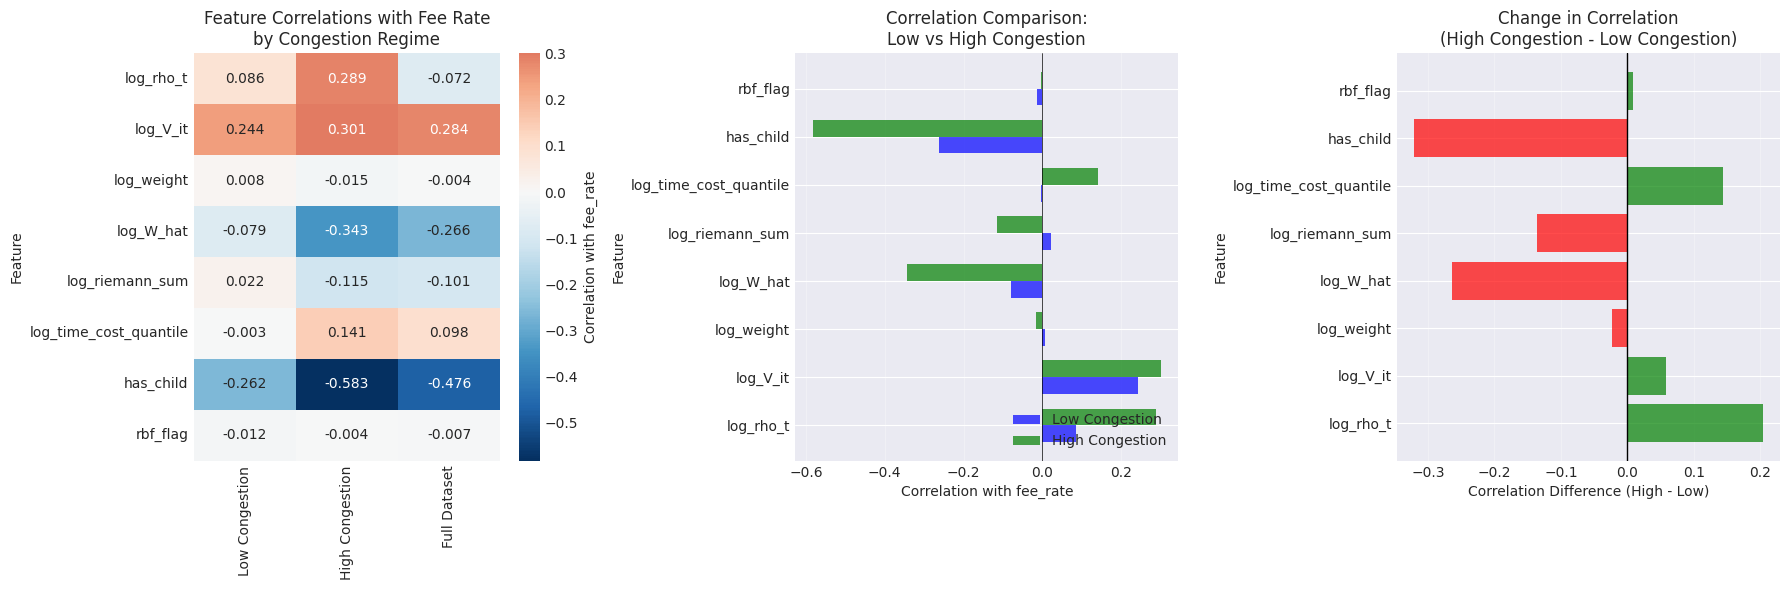


FEATURES WITH REGIME-DEPENDENT CORRELATIONS

(Features where correlation differs significantly between regimes)

  log_rho_t:
    Low Congestion:  +0.0857
    High Congestion: +0.2893
    Difference: +0.2035

  log_V_it:
    Low Congestion:  +0.2436
    High Congestion: +0.3015
    Difference: +0.0578

  log_W_hat:
    Low Congestion:  -0.0793
    High Congestion: -0.3427
    Difference: -0.2634

  log_riemann_sum:
    Low Congestion:  +0.0215
    High Congestion: -0.1146
    Difference: -0.1361
    ⚠️ SIGN CHANGE between regimes!

  log_time_cost_quantile:
    Low Congestion:  -0.0025
    High Congestion: +0.1410
    Difference: +0.1435
    ⚠️ SIGN CHANGE between regimes!

  has_child:
    Low Congestion:  -0.2625
    High Congestion: -0.5833
    Difference: -0.3209



In [76]:
# =============================================================================
# REGIME-SPECIFIC CORRELATION ANALYSIS (1-Breakpoint / 2 Regimes)
# =============================================================================

print("="*70)
print("REGIME-SPECIFIC CORRELATIONS (Low vs High Congestion)")
print("="*70)

# Apply single breakpoint to create 2 regimes
X_regime = X_bp.copy()
X_regime['fee_rate'] = y_bp.values
X_regime['regime'] = np.where(X_regime[key_feature] <= best_breakpoint_1, 'Low', 'High')

print(f"\nBreakpoint: {key_feature} = {best_breakpoint_1:.4f}")
print(f"Low Congestion: {(X_regime['regime']=='Low').sum():,} transactions")
print(f"High Congestion: {(X_regime['regime']=='High').sum():,} transactions")

# Features to analyze
corr_features = ['log_rho_t', 'log_V_it', 'log_weight', 'log_W_hat', 
                 'log_riemann_sum', 'log_time_cost_quantile',
                 'has_child', 'rbf_flag', 'NFT_it', 'from_exchange', 'to_exchange']
corr_features = [f for f in corr_features if f in X_regime.columns]

# Compute correlations for each regime
print("\n" + "-"*70)
print("Correlations with fee_rate by regime:")
print("-"*70)
print(f"\n{'Feature':<25} {'Low':>12} {'High':>12} {'Difference':>12} {'Full':>12}")
print("-"*70)

correlation_results = {}
for feat in corr_features:
    corr_low = X_regime[X_regime['regime']=='Low'][[feat, 'fee_rate']].corr().iloc[0,1]
    corr_high = X_regime[X_regime['regime']=='High'][[feat, 'fee_rate']].corr().iloc[0,1]
    corr_full = X_regime[[feat, 'fee_rate']].corr().iloc[0,1]
    diff = corr_high - corr_low
    
    correlation_results[feat] = {
        'Low': corr_low, 'High': corr_high, 'Full': corr_full, 'Diff': diff
    }
    print(f"{feat:<25} {corr_low:>+12.4f} {corr_high:>+12.4f} {diff:>+12.4f} {corr_full:>+12.4f}")

# Create correlation comparison DataFrame
corr_df = pd.DataFrame(correlation_results).T
corr_df.columns = ['Low Congestion', 'High Congestion', 'Full Dataset', 'Difference']

# Visualize regime-specific correlations
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Heatmap of correlations by regime
ax1 = axes[0]
heatmap_data = corr_df[['Low Congestion', 'High Congestion', 'Full Dataset']]
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            ax=ax1, cbar_kws={'label': 'Correlation with fee_rate'},
            annot_kws={'size': 10})
ax1.set_title('Feature Correlations with Fee Rate\nby Congestion Regime')
ax1.set_ylabel('Feature')

# 2. Bar chart comparing Low vs High
ax2 = axes[1]
x = np.arange(len(corr_features))
width = 0.35

bars1 = ax2.barh(x - width/2, corr_df['Low Congestion'], width, 
                 label='Low Congestion', color='blue', alpha=0.7)
bars2 = ax2.barh(x + width/2, corr_df['High Congestion'], width, 
                 label='High Congestion', color='green', alpha=0.7)

ax2.set_xlabel('Correlation with fee_rate')
ax2.set_ylabel('Feature')
ax2.set_title('Correlation Comparison:\nLow vs High Congestion')
ax2.set_yticks(x)
ax2.set_yticklabels(corr_features)
ax2.legend(loc='lower right')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax2.grid(True, alpha=0.3, axis='x')

# 3. Difference in correlations
ax3 = axes[2]
colors = ['green' if d > 0 else 'red' for d in corr_df['Difference']]
ax3.barh(x, corr_df['Difference'], color=colors, alpha=0.7)
ax3.set_xlabel('Correlation Difference (High - Low)')
ax3.set_ylabel('Feature')
ax3.set_title('Change in Correlation\n(High Congestion - Low Congestion)')
ax3.set_yticks(x)
ax3.set_yticklabels(corr_features)
ax3.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax3.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Identify features with regime-dependent behavior
print("\n" + "="*70)
print("FEATURES WITH REGIME-DEPENDENT CORRELATIONS")
print("="*70)
print("\n(Features where correlation differs significantly between regimes)\n")

for feat in corr_features:
    corr_low = correlation_results[feat]['Low']
    corr_high = correlation_results[feat]['High']
    diff = abs(corr_high - corr_low)
    
    if diff > 0.05:  # Meaningful difference
        print(f"  {feat}:")
        print(f"    Low Congestion:  {corr_low:+.4f}")
        print(f"    High Congestion: {corr_high:+.4f}")
        print(f"    Difference: {corr_high - corr_low:+.4f}")
        if corr_low * corr_high < 0:
            print(f"    ⚠️ SIGN CHANGE between regimes!")
        print()


REGIME-SPECIFIC REGRESSION MODELS (Low vs High Congestion)

LOW CONGESTION REGIME
--------------------------------------------------
  Samples: 478,515
  R²: 0.0490
  MAE: 2.22 sat/vB

  Coefficients (standardized):
    log_V_it            : +0.9889
    has_child           : -0.6175
    log_rho_t           : +0.5192
    log_weight          : -0.2928
    log_W_hat           : -0.1218
    rbf_flag            : -0.0744

HIGH CONGESTION REGIME
--------------------------------------------------
  Samples: 521,485
  R²: 0.1296
  MAE: 2.12 sat/vB

  Coefficients (standardized):
    has_child           : -1.1613
    log_V_it            : +1.1012
    log_rho_t           : +0.6321
    log_weight          : -0.3466
    log_W_hat           : -0.1465
    rbf_flag            : -0.0912

COEFFICIENT COMPARISON: LOW vs HIGH CONGESTION

               Low    High  Difference
log_rho_t   0.5192  0.6321      0.1129
log_V_it    0.9889  1.1012      0.1123
log_weight -0.2928 -0.3466     -0.0538
log_W_hat  -0

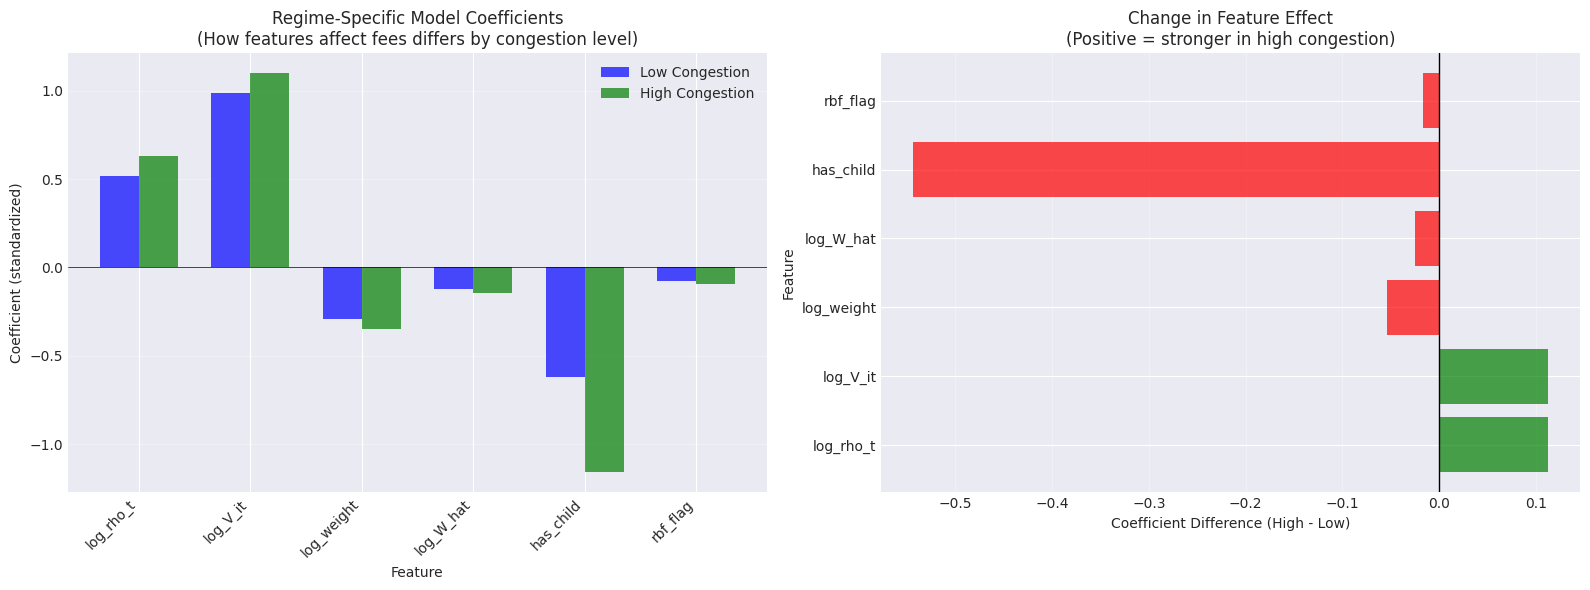


KEY INSIGHTS FROM 1-BREAKPOINT REGIME ANALYSIS

BREAKPOINT IDENTIFIED:
  • log_rho_t = 10.6537 (mempool ≈ 42,347)
  • Slope before: 0.4061
  • Slope after: 3.5613

MODEL PERFORMANCE BY REGIME:
  • Low Congestion:  R² = 0.0490, MAE = 2.22
  • High Congestion: R² = 0.1296, MAE = 2.12

MOST REGIME-DEPENDENT FEATURES (by coefficient change):

  1. has_child: ↓ 0.5438
     Low: -0.6175 → High: -1.1613
  2. log_rho_t: ↑ 0.1129
     Low: +0.5192 → High: +0.6321
  3. log_V_it: ↑ 0.1123
     Low: +0.9889 → High: +1.1012
  4. log_weight: ↓ 0.0538
     Low: -0.2928 → High: -0.3466
  5. log_W_hat: ↓ 0.0247
     Low: -0.1218 → High: -0.1465

IMPLICATIONS:
  • Features with large coefficient differences behave differently
    across congestion regimes
  • Consider regime-switching or interaction terms in the model
  • The spline model captures some of this non-linearity



In [67]:
# =============================================================================
# FIT SEPARATE MODELS FOR EACH REGIME (1-Breakpoint / 2 Regimes)
# =============================================================================

print("="*70)
print("REGIME-SPECIFIC REGRESSION MODELS (Low vs High Congestion)")
print("="*70)

# Features for regime-specific models
regime_features = ['log_rho_t', 'log_V_it', 'log_weight', 'log_W_hat', 
                   'has_child', 'rbf_flag', 'from_exchange', 'to_exchange']
regime_features = [f for f in regime_features if f in X_bp.columns]

# Fit models for each regime
regime_models = {}
regime_results = {}

for regime_name in ['Low', 'High']:
    regime_mask = X_regime['regime'] == regime_name
    X_reg = X_regime.loc[regime_mask, regime_features]
    y_reg = X_regime.loc[regime_mask, 'fee_rate']
    
    if len(X_reg) < 100:
        print(f"\n{regime_name} Regime: Insufficient data ({len(X_reg)} samples)")
        continue
    
    # Standardize
    scaler_reg = StandardScaler()
    X_reg_scaled = scaler_reg.fit_transform(X_reg)
    
    # Fit Ridge regression
    model_reg = Ridge(alpha=1.0)
    model_reg.fit(X_reg_scaled, y_reg)
    
    # Predictions and metrics
    y_pred_reg = model_reg.predict(X_reg_scaled)
    r2_reg = r2_score(y_reg, y_pred_reg)
    mae_reg = mean_absolute_error(y_reg, y_pred_reg)
    
    regime_models[regime_name] = model_reg
    regime_results[regime_name] = {
        'r2': r2_reg,
        'mae': mae_reg,
        'n_samples': len(X_reg),
        'coefs': dict(zip(regime_features, model_reg.coef_))
    }
    
    print(f"\n{regime_name.upper()} CONGESTION REGIME")
    print("-"*50)
    print(f"  Samples: {len(X_reg):,}")
    print(f"  R²: {r2_reg:.4f}")
    print(f"  MAE: {mae_reg:.2f} sat/vB")
    print(f"\n  Coefficients (standardized):")
    
    coef_sorted = sorted(zip(regime_features, model_reg.coef_), 
                         key=lambda x: abs(x[1]), reverse=True)
    for feat, coef in coef_sorted:
        print(f"    {feat:<20}: {coef:+.4f}")

# Compare coefficients across regimes
print("\n" + "="*70)
print("COEFFICIENT COMPARISON: LOW vs HIGH CONGESTION")
print("="*70)

coef_comparison = pd.DataFrame({
    regime: [regime_results[regime]['coefs'].get(f, np.nan) for f in regime_features]
    for regime in ['Low', 'High'] if regime in regime_results
}, index=regime_features)

# Add difference column
coef_comparison['Difference'] = coef_comparison['High'] - coef_comparison['Low']

print("\n" + coef_comparison.to_string())

# Visualize coefficient comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Side-by-side bar chart
ax1 = axes[0]
x = np.arange(len(regime_features))
width = 0.35

ax1.bar(x - width/2, coef_comparison['Low'], width, label='Low Congestion', color='blue', alpha=0.7)
ax1.bar(x + width/2, coef_comparison['High'], width, label='High Congestion', color='green', alpha=0.7)

ax1.set_xlabel('Feature')
ax1.set_ylabel('Coefficient (standardized)')
ax1.set_title('Regime-Specific Model Coefficients\n(How features affect fees differs by congestion level)')
ax1.set_xticks(x)
ax1.set_xticklabels(regime_features, rotation=45, ha='right')
ax1.legend()
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.grid(True, alpha=0.3, axis='y')

# 2. Coefficient difference
ax2 = axes[1]
colors = ['green' if d > 0 else 'red' for d in coef_comparison['Difference']]
ax2.barh(x, coef_comparison['Difference'], color=colors, alpha=0.7)
ax2.set_xlabel('Coefficient Difference (High - Low)')
ax2.set_ylabel('Feature')
ax2.set_title('Change in Feature Effect\n(Positive = stronger in high congestion)')
ax2.set_yticks(x)
ax2.set_yticklabels(regime_features)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Summary insights
print("\n" + "="*70)
print("KEY INSIGHTS FROM 1-BREAKPOINT REGIME ANALYSIS")
print("="*70)

# Find most regime-dependent features
coef_comparison_sorted = coef_comparison.reindex(
    coef_comparison['Difference'].abs().sort_values(ascending=False).index
)

print(f"""
BREAKPOINT IDENTIFIED:
  • {key_feature} = {best_breakpoint_1:.4f} (mempool ≈ {np.exp(best_breakpoint_1):,.0f})
  • Slope before: {coef_before[0]:.4f}
  • Slope after: {coef_after[0]:.4f}
  
MODEL PERFORMANCE BY REGIME:
  • Low Congestion:  R² = {regime_results['Low']['r2']:.4f}, MAE = {regime_results['Low']['mae']:.2f}
  • High Congestion: R² = {regime_results['High']['r2']:.4f}, MAE = {regime_results['High']['mae']:.2f}

MOST REGIME-DEPENDENT FEATURES (by coefficient change):
""")

for i, (feat, row) in enumerate(coef_comparison_sorted.head(5).iterrows()):
    direction = "↑" if row['Difference'] > 0 else "↓"
    print(f"  {i+1}. {feat}: {direction} {abs(row['Difference']):.4f}")
    print(f"     Low: {row['Low']:+.4f} → High: {row['High']:+.4f}")

print("""
IMPLICATIONS:
  • Features with large coefficient differences behave differently
    across congestion regimes
  • Consider regime-switching or interaction terms in the model
  • The spline model captures some of this non-linearity
""")


In [ ]:
# =============================================================================
# SPLINE REGRESSION ON HIGH CONGESTION REGIME (After Breakpoint)
# =============================================================================

print("="*70)
print("SPLINE REGRESSION: HIGH CONGESTION REGIME ONLY")
print("="*70)
print(f"\nFiltering to transactions where {key_feature} > {best_breakpoint_1:.4f}")
print(f"(mempool congestion > {np.exp(best_breakpoint_1):,.0f})")

# Filter training and test data to high congestion regime
high_cong_train_mask = X_train[key_feature] > best_breakpoint_1
high_cong_test_mask = X_test[key_feature] > best_breakpoint_1

X_train_high = X_train[high_cong_train_mask].copy()
y_train_high = y_train[high_cong_train_mask].copy()
X_test_high = X_test[high_cong_test_mask].copy()
y_test_high = y_test[high_cong_test_mask].copy()

print(f"\nHigh Congestion Training Set: {len(X_train_high):,} transactions")
print(f"High Congestion Test Set: {len(X_test_high):,} transactions")

# Use sample for computational efficiency
sample_size_spline_high = min(500000, len(X_train_high))
np.random.seed(42)
sample_idx_high = np.random.choice(len(X_train_high), sample_size_spline_high, replace=False)
X_train_spline_high = X_train_high.iloc[sample_idx_high].copy()
y_train_spline_high = y_train_high.iloc[sample_idx_high].copy()

# Also sample test for faster evaluation during sweep
sample_size_test = min(200000, len(X_test_high))
test_sample_idx = np.random.choice(len(X_test_high), sample_size_test, replace=False)
X_test_sample = X_test_high.iloc[test_sample_idx].copy()
y_test_sample = y_test_high.iloc[test_sample_idx].copy()

print(f"Using {sample_size_spline_high:,} training samples")
print(f"Using {sample_size_test:,} test samples for feature sweep")

# =============================================================================
# FEATURE SWEEP: Determine which features benefit from spline transformation
# =============================================================================

print("\n" + "="*70)
print("FEATURE SWEEP: Finding Optimal Spline Features")
print("="*70)

# Identify continuous vs binary features
all_continuous = [f for f in all_model_features 
                  if f not in ['has_child', 'rbf_flag', 'NFT_it', 'from_exchange', 'to_exchange']]
binary_features = [f for f in ['has_child', 'rbf_flag', 'NFT_it', 'from_exchange', 'to_exchange'] 
                   if f in all_model_features]

print(f"\nContinuous features to test: {all_continuous}")
print(f"Binary features (always linear): {binary_features}")

# Baseline: All linear model
scaler_base = StandardScaler()
X_train_scaled_base = scaler_base.fit_transform(X_train_spline_high[all_model_features])
X_test_scaled_base = scaler_base.transform(X_test_sample[all_model_features])

model_baseline = Ridge(alpha=1.0)
model_baseline.fit(X_train_scaled_base, y_train_spline_high)
y_pred_baseline = model_baseline.predict(X_test_scaled_base)
r2_baseline = r2_score(y_test_sample, y_pred_baseline)
mae_baseline = mean_absolute_error(y_test_sample, y_pred_baseline)

print(f"\n📊 Baseline (all linear): R² = {r2_baseline:.4f}, MAE = {mae_baseline:.2f}")

# Test spline transformation on each continuous feature
n_knots_test = 4
degree_test = 3

print(f"\nSpline config for sweep: {n_knots_test} knots, degree {degree_test}")
print("\nTesting each feature with spline transformation...")
print("-"*80)
print(f"{'Feature':<30} {'R² (spline)':>12} {'R² Δ':>12} {'MAE':>10} {'MAE Δ':>10} {'Benefit?'}")
print("-"*80)

feature_sweep_results = {}

for feat in all_continuous:
    other_feats = [f for f in all_model_features if f != feat]
    
    try:
        preprocessor_sweep = ColumnTransformer(
            transformers=[
                ('spline', SplineTransformer(n_knots=n_knots_test, degree=degree_test, 
                                             include_bias=False), [feat]),
                ('passthrough', 'passthrough', other_feats)
            ],
            remainder='drop'
        )
        
        model_sweep = Pipeline([
            ('preprocessor', preprocessor_sweep),
            ('scaler', StandardScaler()),
            ('regressor', Ridge(alpha=1.0))
        ])
        
        model_sweep.fit(X_train_spline_high, y_train_spline_high)
        y_pred_sweep = model_sweep.predict(X_test_sample)
        
        r2_sweep = r2_score(y_test_sample, y_pred_sweep)
        mae_sweep = mean_absolute_error(y_test_sample, y_pred_sweep)
        
        r2_delta = r2_sweep - r2_baseline
        mae_delta = mae_sweep - mae_baseline
        
        # Does spline help?
        benefit = "✓ YES" if r2_delta > 0.002 or mae_delta < -0.02 else "no"
        
        feature_sweep_results[feat] = {
            'r2': r2_sweep,
            'mae': mae_sweep,
            'r2_delta': r2_delta,
            'mae_delta': mae_delta,
            'benefits': r2_delta > 0.002 or mae_delta < -0.02
        }
        
        print(f"{feat:<30} {r2_sweep:>12.4f} {r2_delta:>+12.4f} {mae_sweep:>10.2f} {mae_delta:>+10.2f} {benefit:>8}")
        
    except Exception as e:
        print(f"{feat:<30} ERROR: {str(e)[:40]}")

# Rank features by improvement
sorted_by_r2 = sorted(feature_sweep_results.items(), key=lambda x: x[1]['r2_delta'], reverse=True)

print("\n" + "-"*80)
print("FEATURES RANKED BY R² IMPROVEMENT:")
print("-"*80)

spline_features_high = []
for feat, results in sorted_by_r2:
    status = "★ USE SPLINE" if results['benefits'] else "  linear ok"
    print(f"  {feat:<28}: R² Δ = {results['r2_delta']:>+.4f}, MAE Δ = {results['mae_delta']:>+.2f}  {status}")
    if results['benefits']:
        spline_features_high.append(feat)

# If no features benefit, use top ones anyway
if len(spline_features_high) == 0:
    print("\n⚠ No features showed significant improvement. Using top 3 by R²:")
    spline_features_high = [f for f, r in sorted_by_r2[:3]]
    
print(f"\n✓ Selected spline features: {spline_features_high}")
other_features_high = [f for f in all_model_features if f not in spline_features_high]
print(f"  Linear features: {other_features_high}")

# Configure spline transformer with selected features
n_knots_high = 8
degree_high = 3

print(f"\nFinal spline configuration:")
print(f"  Knots: {n_knots_high}")
print(f"  Degree: {degree_high} (cubic)")

# Create column transformer
preprocessor_high = ColumnTransformer(
    transformers=[
        ('splines', SplineTransformer(n_knots=n_knots_high, degree=degree_high, include_bias=False), 
         spline_features_high),
        ('passthrough', 'passthrough', other_features_high)
    ],
    remainder='drop'
)

# Build pipeline
model_spline_high = Pipeline([
    ('preprocessor', preprocessor_high),
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=0.01))
])

# Fit the model
print("\nFitting spline regression on high congestion data...")
model_spline_high.fit(X_train_spline_high, y_train_spline_high)

# Predictions
y_pred_train_spline_high = model_spline_high.predict(X_train_spline_high)
y_pred_test_spline_high = model_spline_high.predict(X_test_high)

# Evaluate
r2_train_high = r2_score(y_train_spline_high, y_pred_train_spline_high)
r2_test_high = r2_score(y_test_high, y_pred_test_spline_high)
mae_train_high = mean_absolute_error(y_train_spline_high, y_pred_train_spline_high)
mae_test_high = mean_absolute_error(y_test_high, y_pred_test_spline_high)
rmse_test_high = np.sqrt(mean_squared_error(y_test_high, y_pred_test_spline_high))
medae_test_high = np.median(np.abs(y_test_high - y_pred_test_spline_high))

print(f"\n" + "-"*50)
print("MODEL PERFORMANCE (High Congestion Regime)")
print("-"*50)
print(f"\nTraining Set:")
print(f"  R²: {r2_train_high:.4f}")
print(f"  MAE: {mae_train_high:.2f} sat/vB")

print(f"\nTest Set:")
print(f"  R²: {r2_test_high:.4f}")
print(f"  MAE: {mae_test_high:.2f} sat/vB")
print(f"  Median AE: {medae_test_high:.2f} sat/vB")
print(f"  RMSE: {rmse_test_high:.2f} sat/vB")

# Compare to full dataset spline model
print(f"\n" + "-"*50)
print("COMPARISON: High Congestion vs Full Dataset Spline")
print("-"*50)
print(f"\n{'Metric':<20} {'High Congestion':>18} {'Full Dataset':>18}")
print("-"*60)
print(f"{'Test R²':<20} {r2_test_high:>18.4f} {r2_test_spline:>18.4f}")
print(f"{'Test MAE':<20} {mae_test_high:>18.2f} {mae_test_spline:>18.2f}")
print(f"{'Test Median AE':<20} {medae_test_high:>18.2f} {medae_test_spline:>18.2f}")

# Visualize partial dependence plots for high congestion
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, feat in enumerate(spline_features_high):
    ax = axes[idx // 2, idx % 2]
    
    # Create a range of values for this feature (within high congestion range)
    feat_min = X_train_spline_high[feat].quantile(0.01)
    feat_max = X_train_spline_high[feat].quantile(0.99)
    feat_range = np.linspace(feat_min, feat_max, 100)
    
    # Create prediction dataframe with median values for other features
    pred_df = pd.DataFrame({f: [X_train_spline_high[f].median()] * 100 
                           for f in all_model_features})
    pred_df[feat] = feat_range
    
    # Predict
    y_pred_partial = model_spline_high.predict(pred_df)
    
    # Plot
    ax.plot(feat_range, y_pred_partial, 'g-', linewidth=2, label='Spline fit (High Cong.)')
    ax.axhline(y=y_train_spline_high.median(), color='gray', linestyle='--', 
               alpha=0.5, label=f'Median fee ({y_train_spline_high.median():.1f})')
    
    # Add rug plot
    sample_rug = X_train_spline_high[feat].sample(min(500, len(X_train_spline_high)))
    ax.scatter(sample_rug, [ax.get_ylim()[0]] * len(sample_rug), alpha=0.1, s=2, c='green')
    
    ax.set_xlabel(feat)
    ax.set_ylabel('Predicted Fee Rate (sat/vB)')
    ax.set_title(f'Partial Dependence: {feat}\n(High Congestion Only)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.suptitle('Spline Regression - High Congestion Regime\nPartial Dependence Plots', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Actual vs Predicted scatter
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# High congestion predictions
ax1 = axes[0]
sample_plot = min(10000, len(y_test_high))
plot_idx = np.random.choice(len(y_test_high), sample_plot, replace=False)

hb = ax1.hexbin(y_test_high.iloc[plot_idx].values, y_pred_test_spline_high[plot_idx], 
                gridsize=40, cmap='Greens', mincnt=1)
ax1.plot([0, 30], [0, 30], 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Fee Rate (sat/vB)')
ax1.set_ylabel('Predicted Fee Rate (sat/vB)')
ax1.set_title(f'High Congestion: Actual vs Predicted\n(R² = {r2_test_high:.4f})')
ax1.set_xlim(0, 30)
ax1.set_ylim(0, 30)
ax1.legend()
plt.colorbar(hb, ax=ax1, label='Count')

# Residual distribution
ax2 = axes[1]
residuals_high = y_test_high.values - y_pred_test_spline_high
ax2.hist(residuals_high, bins=50, alpha=0.7, color='green', edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax2.axvline(x=np.median(residuals_high), color='orange', linestyle='--', linewidth=2,
            label=f'Median: {np.median(residuals_high):.2f}')
ax2.set_xlabel('Residual (Actual - Predicted)')
ax2.set_ylabel('Count')
ax2.set_title('Residual Distribution (High Congestion)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("SUMMARY: Spline Regression on High Congestion Regime")
print("="*70)
print(f"""
By fitting a spline model only on the HIGH CONGESTION regime
(transactions after the breakpoint), we can:

1. Capture non-linear dynamics specific to congested periods
2. Avoid mixing different fee-setting behaviors from low congestion
3. Better model the regime where fees are most variable/important

Key Results:
  • High Congestion R²: {r2_test_high:.4f}
  • High Congestion MAE: {mae_test_high:.2f} sat/vB
  • High Congestion transactions: {len(X_test_high):,} ({len(X_test_high)/len(X_test)*100:.1f}% of test set)
""")


In [1]:
# =============================================================================
# SPLINE REGRESSION: Fee Rate vs Transaction Count (High Congestion Regime)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Use high congestion test predictions
y_test_hc = y_test_high
y_pred_hc = y_pred_test_spline_high

# 1. Histogram: Actual vs Predicted Fee Rate Distribution (Transaction Count per Fee Rate Bin)
ax1 = axes[0, 0]
fee_bins = np.linspace(0, min(y_test_hc.max(), 30), 50)

ax1.hist(y_test_hc, bins=fee_bins, alpha=0.6, label='Actual Fee Rate', color='#3498db', edgecolor='black')
ax1.hist(y_pred_hc, bins=fee_bins, alpha=0.6, label='Predicted Fee Rate', color='#e74c3c', edgecolor='black')
ax1.set_xlabel('Fee Rate (sat/vB)')
ax1.set_ylabel('Transaction Count')
ax1.set_title('Spline Regression (High Congestion): Fee Rate Distribution\n(Actual vs Predicted)')
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# 2. Cumulative Distribution: Transaction Count vs Fee Rate
ax2 = axes[0, 1]
# Sort by actual fee rate and plot cumulative count
sorted_actual = np.sort(y_test_hc.values)
sorted_pred = np.sort(y_pred_hc)
cumulative = np.arange(1, len(sorted_actual) + 1)

# Sample for plotting (too many points)
sample_step = max(1, len(sorted_actual) // 5000)
ax2.plot(sorted_actual[::sample_step], cumulative[::sample_step], 
         label='Actual', color='#3498db', linewidth=2)
ax2.plot(sorted_pred[::sample_step], cumulative[::sample_step], 
         label='Predicted (Spline)', color='#e74c3c', linewidth=2, linestyle='--')
ax2.set_xlabel('Fee Rate (sat/vB)')
ax2.set_ylabel('Cumulative Transaction Count')
ax2.set_title('Spline Regression (High Congestion): Cumulative Distribution\n(Fee Rate vs Transaction Count)')
ax2.legend()
ax2.set_xlim(0, min(sorted_actual.max(), 30))
ax2.grid(True, alpha=0.3)

# Add reference lines for key percentiles
for pct in [50, 75, 90, 95]:
    actual_pct = np.percentile(y_test_hc, pct)
    ax2.axvline(x=actual_pct, color='gray', linestyle=':', alpha=0.5)
    ax2.text(actual_pct, cumulative[-1] * 0.95, f'{pct}%', fontsize=8, rotation=90, va='top')

# 3. Binned Fee Rate vs Average Transaction Count
ax3 = axes[1, 0]
# Create fee rate bins and count transactions in each
n_bins = 30
bin_edges = np.linspace(0, min(y_test_hc.max(), 25), n_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Count actual transactions per bin
actual_counts, _ = np.histogram(y_test_hc, bins=bin_edges)
pred_counts, _ = np.histogram(y_pred_hc, bins=bin_edges)

width = (bin_edges[1] - bin_edges[0]) * 0.4
ax3.bar(bin_centers - width/2, actual_counts, width=width, alpha=0.7, 
        label='Actual', color='#3498db', edgecolor='black')
ax3.bar(bin_centers + width/2, pred_counts, width=width, alpha=0.7, 
        label='Predicted (Spline)', color='#e74c3c', edgecolor='black')
ax3.set_xlabel('Fee Rate (sat/vB)')
ax3.set_ylabel('Transaction Count')
ax3.set_title('Spline Regression (High Congestion): Transaction Count per Fee Rate Bin')
ax3.legend()
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Scatter: Actual vs Predicted with density coloring
ax4 = axes[1, 1]
# Sample for visualization
sample_size_plot = min(50000, len(y_test_hc))
np.random.seed(42)
plot_idx = np.random.choice(len(y_test_hc), sample_size_plot, replace=False)

y_test_sample = y_test_hc.iloc[plot_idx].values
y_pred_sample = y_pred_hc[plot_idx]

# Use hexbin for density
hb = ax4.hexbin(y_test_sample, y_pred_sample, gridsize=50, cmap='YlOrRd', 
                mincnt=1, xscale='linear', yscale='linear')
ax4.plot([0, 30], [0, 30], 'b--', linewidth=2, label='Perfect Prediction')
ax4.set_xlabel('Actual Fee Rate (sat/vB)')
ax4.set_ylabel('Predicted Fee Rate (sat/vB)')
ax4.set_title('Spline Regression (High Congestion): Actual vs Predicted\n(Color = Transaction Density)')
ax4.set_xlim(0, 30)
ax4.set_ylim(0, 30)
ax4.legend(loc='upper left')
plt.colorbar(hb, ax=ax4, label='Transaction Count')

plt.suptitle('Spline Regression - Fee Rate vs Transaction Count Analysis (High Congestion Regime)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("SPLINE REGRESSION: FEE RATE DISTRIBUTION SUMMARY (HIGH CONGESTION)")
print("="*70)
print(f"\nActual Fee Rate Distribution:")
print(f"  Total transactions: {len(y_test_hc):,}")
print(f"  Mean: {y_test_hc.mean():.2f} sat/vB")
print(f"  Median: {y_test_hc.median():.2f} sat/vB")
print(f"  Std Dev: {y_test_hc.std():.2f} sat/vB")

print(f"\nPredicted Fee Rate Distribution (Spline Model):")
print(f"  Mean: {y_pred_hc.mean():.2f} sat/vB")
print(f"  Median: {np.median(y_pred_hc):.2f} sat/vB")
print(f"  Std Dev: {y_pred_hc.std():.2f} sat/vB")

# Transaction count by fee rate bracket
print(f"\nTransaction Count by Fee Rate Bracket:")
brackets = [(0, 1), (1, 2), (2, 5), (5, 10), (10, 20), (20, 100)]
for low, high in brackets:
    actual_count = ((y_test_hc >= low) & (y_test_hc < high)).sum()
    pred_count = ((y_pred_hc >= low) & (y_pred_hc < high)).sum()
    print(f"  {low:2d}-{high:3d} sat/vB: Actual {actual_count:>10,} | Predicted {pred_count:>10,}")


NameError: name 'plt' is not defined

F-STATISTICS: Variable Significance in Spline Regression

Using high congestion data: 500,000 samples
Using 11 available features: ['log_weight', 'log_rho_t', 'log_W_hat', 'log_riemann_sum', 'log_time_cost_quantile', 'log_V_it', 'has_child', 'rbf_flag', 'V_it', 'log_blockspace_t', 'log_waittime']

----------------------------------------------------------------------
PART 1: F-Statistics for Base Features (Linear Model)
----------------------------------------------------------------------

Full Model R²: 0.1305
Full Model Adj R²: 0.1305
Full Model F-statistic: 6824.41
Full Model F p-value: 0.00e+00

Feature                              F-stat         p-value    Significant?
---------------------------------------------------------------------------
log_weight                          2232.13        1.11e-16   *** (p<0.001)
log_rho_t                           3698.05        1.11e-16   *** (p<0.001)
log_W_hat                              7.97        4.76e-03     ** (p<0.01)
log_riemann_

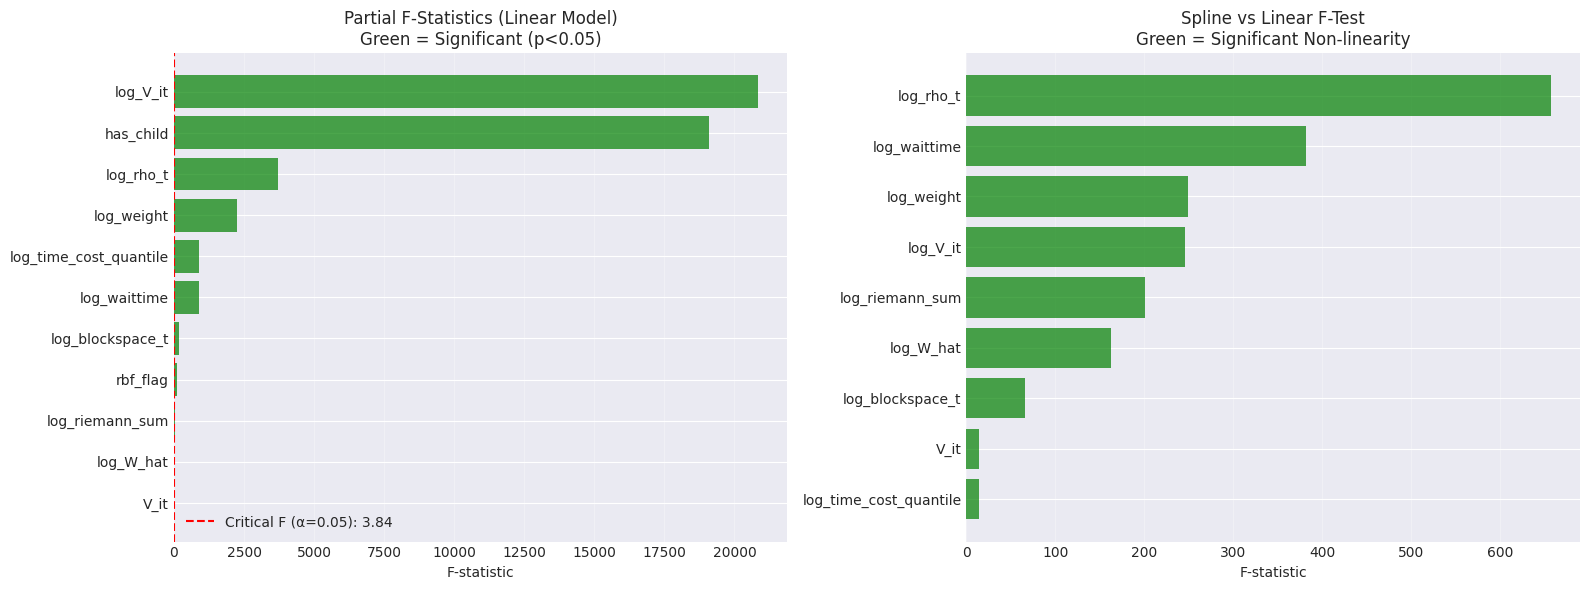


----------------------------------------------------------------------
INTERPRETATION:
----------------------------------------------------------------------

• Linear F-statistics test if each variable contributes to predicting fees
  (controlling for other variables)

• Spline F-statistics test if non-linear (spline) modeling improves over 
  linear modeling for each feature

• High F-stat + low p-value = significant contribution/improvement
• Features with significant spline F-tests have important non-linear effects



In [37]:
# =============================================================================
# F-STATISTICS FOR SPLINE REGRESSION VARIABLES
# =============================================================================
# Compute F-statistics to test significance of each variable/feature group

print("="*70)
print("F-STATISTICS: Variable Significance in Spline Regression")
print("="*70)

from scipy.stats import f as f_dist

# Use the high congestion spline model data
# Re-fit using statsmodels for proper statistical inference
print(f"\nUsing high congestion data: {len(X_train_spline_high):,} samples")

# Get features that are actually present in the dataframe
available_features = [f for f in all_model_features if f in X_train_spline_high.columns]
missing_features = [f for f in all_model_features if f not in X_train_spline_high.columns]
if missing_features:
    print(f"⚠ Features not in high congestion data (re-run earlier cells to include): {missing_features}")
print(f"Using {len(available_features)} available features: {available_features}")

# First, let's compute F-stats for the LINEAR model (easier interpretation)
# Then we'll do it for spline features

# =============================================================================
# Part 1: F-Statistics for Base Features (Linear Model)
# =============================================================================
print("\n" + "-"*70)
print("PART 1: F-Statistics for Base Features (Linear Model)")
print("-"*70)

# Prepare data
X_f = X_train_spline_high[available_features].copy()
y_f = y_train_spline_high.copy()

# Add constant for statsmodels
X_f_const = sm.add_constant(X_f)

# Fit full model
model_full = sm.OLS(y_f, X_f_const).fit()

print(f"\nFull Model R²: {model_full.rsquared:.4f}")
print(f"Full Model Adj R²: {model_full.rsquared_adj:.4f}")
print(f"Full Model F-statistic: {model_full.fvalue:.2f}")
print(f"Full Model F p-value: {model_full.f_pvalue:.2e}")

# Compute partial F-statistics for each variable
# F = [(RSS_reduced - RSS_full) / p] / [RSS_full / (n - k - 1)]
# Where p = number of parameters removed, k = total parameters in full model

n = len(y_f)
k = len(available_features)  # number of features (excluding constant)
RSS_full = model_full.ssr  # residual sum of squares

print(f"\n{'Feature':<30} {'F-stat':>12} {'p-value':>15} {'Significant?':>15}")
print("-"*75)

f_stats_linear = {}

for feat in available_features:
    # Fit reduced model without this feature
    X_reduced = X_f.drop(columns=[feat])
    X_reduced_const = sm.add_constant(X_reduced)
    model_reduced = sm.OLS(y_f, X_reduced_const).fit()
    
    RSS_reduced = model_reduced.ssr
    p = 1  # removing 1 parameter
    
    # Partial F-statistic
    F_stat = ((RSS_reduced - RSS_full) / p) / (RSS_full / (n - k - 1))
    
    # p-value from F-distribution
    p_value = 1 - f_dist.cdf(F_stat, p, n - k - 1)
    
    # Significance
    if p_value < 0.001:
        sig = "*** (p<0.001)"
    elif p_value < 0.01:
        sig = "** (p<0.01)"
    elif p_value < 0.05:
        sig = "* (p<0.05)"
    else:
        sig = "not sig"
    
    f_stats_linear[feat] = {'F': F_stat, 'p': p_value, 'sig': sig}
    print(f"{feat:<30} {F_stat:>12.2f} {p_value:>15.2e} {sig:>15}")

# =============================================================================
# Part 2: F-Statistics for Spline Features (Testing Spline vs Linear)
# =============================================================================
print("\n" + "-"*70)
print("PART 2: F-Statistics for Spline Terms (Non-linearity Test)")
print("-"*70)
print("Testing: Does spline transformation improve over linear for each feature?")

# Test ALL continuous features for spline non-linearity (not just selected ones)
all_continuous_for_test = [f for f in available_features 
                           if f not in ['has_child', 'rbf_flag', 'NFT_it', 'from_exchange', 'to_exchange']]
print(f"Testing {len(all_continuous_for_test)} continuous features: {all_continuous_for_test}")

f_stats_spline = {}

for feat in all_continuous_for_test:
    # Model with spline for this feature
    other_feats = [f for f in available_features if f != feat]
    
    preprocessor_spline = ColumnTransformer(
        transformers=[
            ('spline', SplineTransformer(n_knots=n_knots_high, degree=degree_high, 
                                         include_bias=False), [feat]),
            ('passthrough', 'passthrough', other_feats)
        ],
        remainder='drop'
    )
    
    X_spline = preprocessor_spline.fit_transform(X_train_spline_high)
    X_spline_const = sm.add_constant(X_spline)
    
    model_spline = sm.OLS(y_f, X_spline_const).fit()
    
    # Model with just linear for this feature (baseline)
    X_linear = X_f_const  # Already has all features linear
    model_linear = sm.OLS(y_f, X_linear).fit()
    
    # Get number of extra parameters from spline
    n_spline_params = preprocessor_spline.named_transformers_['spline'].n_features_out_
    p_extra = n_spline_params - 1  # Extra params beyond linear (subtract 1 for the linear term)
    
    RSS_linear = model_linear.ssr
    RSS_spline = model_spline.ssr
    
    # F-test for improvement
    k_spline = X_spline.shape[1]
    F_stat = ((RSS_linear - RSS_spline) / p_extra) / (RSS_spline / (n - k_spline - 1))
    p_value = 1 - f_dist.cdf(F_stat, p_extra, n - k_spline - 1)
    
    # R² improvement
    r2_linear = model_linear.rsquared
    r2_spline = model_spline.rsquared
    r2_improvement = r2_spline - r2_linear
    
    if p_value < 0.001:
        sig = "*** SIGNIFICANT"
    elif p_value < 0.01:
        sig = "** significant"
    elif p_value < 0.05:
        sig = "* marginal"
    else:
        sig = "not significant"
    
    f_stats_spline[feat] = {
        'F': F_stat, 
        'p': p_value, 
        'df1': p_extra,
        'r2_linear': r2_linear,
        'r2_spline': r2_spline,
        'r2_improvement': r2_improvement,
        'sig': sig
    }
    
    print(f"\n{feat}:")
    print(f"  Spline params: {n_spline_params} (vs 1 linear)")
    print(f"  F-statistic: {F_stat:.2f} (df1={p_extra}, df2={n-k_spline-1})")
    print(f"  p-value: {p_value:.2e}")
    print(f"  R² improvement: {r2_linear:.4f} → {r2_spline:.4f} (+{r2_improvement:.4f})")
    print(f"  Result: {sig}")

# =============================================================================
# Part 3: Summary Table
# =============================================================================
print("\n" + "="*70)
print("SUMMARY: F-STATISTICS")
print("="*70)

# Create summary DataFrame
summary_data = []
for feat in available_features:
    row = {
        'Feature': feat,
        'Linear_F': f_stats_linear[feat]['F'],
        'Linear_p': f_stats_linear[feat]['p'],
        'Linear_Sig': '***' if f_stats_linear[feat]['p'] < 0.001 else ('**' if f_stats_linear[feat]['p'] < 0.01 else ('*' if f_stats_linear[feat]['p'] < 0.05 else ''))
    }
    
    if feat in f_stats_spline:
        row['Spline_F'] = f_stats_spline[feat]['F']
        row['Spline_p'] = f_stats_spline[feat]['p']
        row['R2_Gain'] = f_stats_spline[feat]['r2_improvement']
        row['Nonlinear?'] = 'YES' if f_stats_spline[feat]['p'] < 0.05 else 'no'
    else:
        row['Spline_F'] = np.nan
        row['Spline_p'] = np.nan
        row['R2_Gain'] = np.nan
        row['Nonlinear?'] = 'N/A (binary)'
    
    summary_data.append(row)

f_stats_df = pd.DataFrame(summary_data)
f_stats_df = f_stats_df.sort_values('Linear_F', ascending=False)

print("\n" + f_stats_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F-statistics for linear model
ax1 = axes[0]
f_stats_sorted = f_stats_df.sort_values('Linear_F', ascending=True)
colors = ['green' if p < 0.05 else 'gray' for p in f_stats_sorted['Linear_p']]
ax1.barh(range(len(f_stats_sorted)), f_stats_sorted['Linear_F'], color=colors, alpha=0.7)
ax1.set_yticks(range(len(f_stats_sorted)))
ax1.set_yticklabels(f_stats_sorted['Feature'])
ax1.set_xlabel('F-statistic')
ax1.set_title('Partial F-Statistics (Linear Model)\nGreen = Significant (p<0.05)')
ax1.axvline(x=f_dist.ppf(0.95, 1, n-k-1), color='red', linestyle='--', 
            label=f'Critical F (α=0.05): {f_dist.ppf(0.95, 1, n-k-1):.2f}')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# Spline non-linearity test
ax2 = axes[1]
spline_df = f_stats_df[f_stats_df['Spline_F'].notna()].sort_values('Spline_F', ascending=True)
colors2 = ['green' if p < 0.05 else 'gray' for p in spline_df['Spline_p']]
ax2.barh(range(len(spline_df)), spline_df['Spline_F'], color=colors2, alpha=0.7)
ax2.set_yticks(range(len(spline_df)))
ax2.set_yticklabels(spline_df['Feature'])
ax2.set_xlabel('F-statistic')
ax2.set_title('Spline vs Linear F-Test\nGreen = Significant Non-linearity')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n" + "-"*70)
print("INTERPRETATION:")
print("-"*70)
print("""
• Linear F-statistics test if each variable contributes to predicting fees
  (controlling for other variables)
  
• Spline F-statistics test if non-linear (spline) modeling improves over 
  linear modeling for each feature
  
• High F-stat + low p-value = significant contribution/improvement
• Features with significant spline F-tests have important non-linear effects
""")


---
## Section 6: Model Diagnostics & Insights


---
## Section 7: Summary & Conclusions


---
## Conclusion

This notebook analyzed the **November 2025 dataset** (~15M transactions) using the Equation 4 structural model for Bitcoin fee prediction. The analysis follows the same methodology as the previous dataset but adapts to the new SQLite data format.
